In [1]:
from keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TerminateOnNaN, CSVLogger
from keras import backend as K
from keras.models import load_model
from math import ceil
import numpy as np
import os

from matplotlib import pyplot as plt

from models.keras_ssd300 import ssd_300
from keras_loss_function.keras_ssd_loss import SSDLoss
from keras_layers.keras_layer_AnchorBoxes import AnchorBoxes
from keras_layers.keras_layer_DecodeDetections import DecodeDetections
from keras_layers.keras_layer_DecodeDetectionsFast import DecodeDetectionsFast
from keras_layers.keras_layer_L2Normalization import L2Normalization

from ssd_encoder_decoder.ssd_input_encoder import SSDInputEncoder
from ssd_encoder_decoder.ssd_output_decoder import decode_detections, decode_detections_fast

from data_generator.object_detection_2d_data_generator import DataGenerator
from data_generator.object_detection_2d_geometric_ops import Resize
from data_generator.object_detection_2d_photometric_ops import ConvertTo3Channels

from data_generator.data_augmentation_chain_original_ssd import SSDDataAugmentation
from data_generator.object_detection_2d_misc_utils import apply_inverse_transforms

%matplotlib inline

/home/auv/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
##################################################################################
# # # # # # # # # # #            SSD TRAINING            # # # # # # # # # # # #
##################################################################################

In [2]:

img_height = 300 # Height of the model input images
img_width = 300 # Width of the model input images
img_channels = 3 # Number of color channels of the model input images
mean_color = [123, 117, 104] # The per-channel mean of the images in the dataset. Do not change this value if you're using any of the pre-trained weights.
swap_channels = [2, 1, 0] # The color channel order in the original SSD is BGR, so we'll have the model reverse the color channel order of the input images.
n_classes = 4 # Number of positive classes, e.g. 20 for Pascal VOC, 80 for MS COCO
scales_pascal = [0.1, 0.2, 0.37, 0.54, 0.71, 0.88, 1.05] # The anchor box scaling factors used in the original SSD300 for the Pascal VOC datasets
scales_coco = [0.07, 0.15, 0.33, 0.51, 0.69, 0.87, 1.05] # The anchor box scaling factors used in the original SSD300 for the MS COCO datasets
scales = scales_pascal
aspect_ratios = [[1.0, 2.0, 0.5],
                 [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                 [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                 [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                 [1.0, 2.0, 0.5],
                 [1.0, 2.0, 0.5]] # The anchor box aspect ratios used in the original SSD300; the order matters
two_boxes_for_ar1 = True
steps = [8, 16, 32, 64, 100, 300] # The space between two adjacent anchor box center points for each predictor layer.
offsets = [0.5, 0.5, 0.5, 0.5, 0.5, 0.5] # The offsets of the first anchor box center points from the top and left borders of the image as a fraction of the step size for each predictor layer.
clip_boxes = False # Whether or not to clip the anchor boxes to lie entirely within the image boundaries
variances = [0.1, 0.1, 0.2, 0.2] # The variances by which the encoded target coordinates are divided as in the original implementation
normalize_coords = True




# 1: Build the Keras model.

K.clear_session() # Clear previous models from memory.

model = ssd_300(image_size=(img_height, img_width, img_channels),
                n_classes=n_classes,
                mode='training',
                l2_regularization=0.0005,
                scales=scales,
                aspect_ratios_per_layer=aspect_ratios,
                two_boxes_for_ar1=two_boxes_for_ar1,
                steps=steps,
                offsets=offsets,
                clip_boxes=clip_boxes,
                variances=variances,
                normalize_coords=normalize_coords,
                subtract_mean=mean_color,
                swap_channels=swap_channels)

# 2: Load some weights into the model.

# TODO: Set the path to the weights you want to load.
weights_path = '/home/auv/ssd_keras/weights/VGG_ILSVRC_16_layers_fc_reduced.h5'

model.load_weights(weights_path, by_name=True)

# 3: Instantiate an optimizer and the SSD loss function and compile the model.
#    If you want to follow the original Caffe implementation, use the preset SGD
#    optimizer, otherwise I'd recommend the commented-out Adam optimizer.

adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
#sgd = SGD(lr=0.001, momentum=0.9, decay=0.0, nesterov=False)

ssd_loss = SSDLoss(neg_pos_ratio=3, alpha=1.0)

model.compile(optimizer=adam, loss=ssd_loss.compute_loss)

In [4]:
#################################################################################
# # # # # # # # # # #        DATA PREPARATION          # # # # # # # # # # # # #
#################################################################################
#https://github.com/pierluigiferrari/data_generator_object_detection_2d

# 1: Instantiate two `DataGenerator` objects: One for training, one for validation.

train_dataset = DataGenerator(load_images_into_memory=False, hdf5_dataset_path=None)
val_dataset = DataGenerator(load_images_into_memory=False, hdf5_dataset_path=None)

# 2: Parse the image and label lists for the training and validation datasets. This can take a while.

# TODO: Set the paths to the datasets here.

data_path = '/media/auv/Untitled/201009_PacStorm/'

# The directories that contain the images.
pacstorm920_images_dir      = os.path.join(data_path , "d20100920_1", "down_images")
pacstorm922_images_dir      =  os.path.join(data_path , "d20100922_1", "down_images")
pacstorm923_images_dir      =  os.path.join(data_path , "d20100923_1", "down_images")


# The directories that contain the annotations.
pacstorm920_annotations_dir      = os.path.join(data_path , "d20100920_1", "down_Annotations")
pacstorm922_annotations_dir      = os.path.join(data_path , "d20100922_1", "down_Annotations")
pacstorm923_annotations_dir = os.path.join(data_path , "d20100923_1", "down_Annotations")

# The paths to the image sets.
pacstorm920_train_image_set_filename    =  os.path.join(data_path , "d20100920_1",'down_images.txt')
pacstorm922_train_image_set_filename    =  os.path.join(data_path , "d20100922_1",'down_images.txt')
pacstorm923_val_image_set_filename      =  os.path.join(data_path , "d20100923_1",'down_images.txt')


# The XML parser needs to now what object class names to look for and in which order to map them to integers.
classes = ['background','fish', 'starfish','coral', 'mud']

train_dataset.parse_xml(images_dirs=[pacstorm920_images_dir,
                                     pacstorm922_images_dir],
                        image_set_filenames=[pacstorm920_train_image_set_filename,
                                             pacstorm922_train_image_set_filename],
                        annotations_dirs=[pacstorm920_annotations_dir,
                                          pacstorm922_annotations_dir],
                        classes=classes,
                        include_classes=[0,1,2,3],
                        exclude_truncated=False,
                        exclude_difficult=False,
                        ret=False)

val_dataset.parse_xml(images_dirs=[pacstorm923_images_dir],
                      image_set_filenames=[pacstorm923_val_image_set_filename],
                      annotations_dirs=[pacstorm923_annotations_dir],
                      classes=classes,
                      include_classes=[0,1,2,3],
                      exclude_truncated=False,
                      exclude_difficult=True,
                      ret=False)

# Optional: Convert the dataset into an HDF5 dataset. This will require more disk space, but will
# speed up the training. Doing this is not relevant in case you activated the `load_images_into_memory`
# option in the constructor, because in that cas the images are in memory already anyway. If you don't
# want to create HDF5 datasets, comment out the subsequent two function calls.

train_dataset.create_hdf5_dataset(file_path='dataset_fish_pacstorm_trainval.h5',
                                  resize=False,
                                  variable_image_size=True,
                                  verbose=True)

val_dataset.create_hdf5_dataset(file_path='dataset_fish_pacstorm_test.h5',
                                resize=False,
                                variable_image_size=True,
                                verbose=True)


# 3: Set the batch size.

batch_size = 8 # Change the batch size if you like, or if you run into GPU memory issues.

# 4: Set the image transformations for pre-processing and data augmentation options.

# For the training generator:
ssd_data_augmentation = SSDDataAugmentation(img_height=img_height,
                                            img_width=img_width,
                                            background=mean_color)

# For the validation generator:
convert_to_3_channels = ConvertTo3Channels()
resize = Resize(height=img_height, width=img_width)

# 5: Instantiate an encoder that can encode ground truth labels into the format needed by the SSD loss function.

# The encoder constructor needs the spatial dimensions of the model's predictor layers to create the anchor boxes.
predictor_sizes = [model.get_layer('conv4_3_norm_mbox_conf').output_shape[1:3],
                   model.get_layer('fc7_mbox_conf').output_shape[1:3],
                   model.get_layer('conv6_2_mbox_conf').output_shape[1:3],
                   model.get_layer('conv7_2_mbox_conf').output_shape[1:3],
                   model.get_layer('conv8_2_mbox_conf').output_shape[1:3],
                   model.get_layer('conv9_2_mbox_conf').output_shape[1:3]]

ssd_input_encoder = SSDInputEncoder(img_height=img_height,
                                    img_width=img_width,
                                    n_classes=n_classes,
                                    predictor_sizes=predictor_sizes,
                                    scales=scales,
                                    aspect_ratios_per_layer=aspect_ratios,
                                    two_boxes_for_ar1=two_boxes_for_ar1,
                                    steps=steps,
                                    offsets=offsets,
                                    clip_boxes=clip_boxes,
                                    variances=variances,
                                    matching_type='multi',
                                    pos_iou_threshold=0.5,
                                    neg_iou_limit=0.5,
                                    normalize_coords=normalize_coords)

# 6: Create the generator handles that will be passed to Keras' `fit_generator()` function.

train_generator = train_dataset.generate(batch_size=batch_size,
                                         shuffle=True,
                                         transformations=[ssd_data_augmentation],
                                         label_encoder=ssd_input_encoder,
                                         returns={'processed_images',
                                                 'encoded_labels'},
                                         keep_images_without_gt=False)

val_generator = val_dataset.generate(batch_size=batch_size,
                                     shuffle=False,
                                     transformations=[convert_to_3_channels,
                                                      resize],
                                     label_encoder=ssd_input_encoder,
                                     returns={'processed_images',
                                              'encoded_labels'},
                                     keep_images_without_gt=False)

# Get the number of samples in the training and validations datasets.
train_dataset_size = train_dataset.get_dataset_size()
val_dataset_size   = val_dataset.get_dataset_size()

print("Number of images in the training dataset:\t{:>6}".format(train_dataset_size))
print("Number of images in the validation dataset:\t{:>6}".format(val_dataset_size))


Processing image set 'down_images.txt':   0%|          | 0/1521 [00:00<?, ?it/s]

Processing image set 'down_images.txt':   1%|▏         | 21/1521 [00:00<00:07, 208.83it/s]

Processing image set 'down_images.txt':   4%|▍         | 62/1521 [00:00<00:05, 244.47it/s]

Processing image set 'down_images.txt':   8%|▊         | 115/1521 [00:00<00:04, 291.31it/s]

Processing image set 'down_images.txt':  11%|█         | 171/1521 [00:00<00:03, 340.03it/s]

Processing image set 'down_images.txt':  15%|█▍        | 221/1521 [00:00<00:03, 375.43it/s]

Processing image set 'down_images.txt':  18%|█▊        | 280/1521 [00:00<00:02, 420.51it/s]

Processing image set 'down_images.txt':  22%|██▏       | 335/1521 [00:00<00:02, 451.35it/s]

Processing image set 'down_images.txt':  26%|██▌       | 388/1521 [00:00<00:02, 470.64it/s]

Processing image set 'down_images.txt':  29%|██▉       | 444/1521 [00:00<00:02, 493.60it/s]

Processing image set 'down_images.txt':  33%|███▎      | 498/1521 [00:01<00:02, 505.46it/s]

Processing image set 'down_images.txt':  36%|███▋      | 553/1521 [00:01<00:01, 517.18it/s]

Processing image set 'down_images.txt':  40%|███▉      | 607/1521 [00:01<00:01, 521.78it/s]

Processing image set 'down_images.txt':  43%|████▎     | 660/1521 [00:01<00:01, 511.01it/s]

Processing image set 'down_images.txt':  47%|████▋     | 720/1521 [00:01<00:01, 532.91it/s]

Processing image set 'down_images.txt':  51%|█████     | 775/1521 [00:01<00:01, 537.83it/s]

Processing image set 'down_images.txt':  55%|█████▍    | 830/1521 [00:01<00:01, 521.40it/s]

Processing image set 'down_images.txt':  58%|█████▊    | 883/1521 [00:01<00:01, 515.60it/s]

Processing image set 'down_images.txt':  62%|██████▏   | 941/1521 [00:01<00:01, 533.16it/s]

Processing image set 'down_images.txt':  65%|██████▌   | 996/1521 [00:01<00:00, 537.20it/s]

Processing image set 'down_images.txt':  69%|██████▉   | 1050/1521 [00:02<00:00, 538.01it/s]

Processing image set 'down_images.txt':  73%|███████▎  | 1104/1521 [00:02<00:00, 538.23it/s]

Processing image set 'down_images.txt':  76%|███████▌  | 1158/1521 [00:02<00:00, 533.31it/s]

Processing image set 'down_images.txt':  81%|████████  | 1229/1521 [00:02<00:00, 574.99it/s]

Processing image set 'down_images.txt':  86%|████████▌ | 1311/1521 [00:02<00:00, 630.72it/s]

Processing image set 'down_images.txt':  92%|█████████▏| 1392/1521 [00:02<00:00, 674.50it/s]

Processing image set 'down_images.txt':  96%|█████████▋| 1466/1521 [00:02<00:00, 690.34it/s]

Processing image set 'down_images.txt': 100%|██████████| 1521/1521 [00:02<00:00, 553.71it/s]


Processing image set 'down_images.txt': 0it [00:00, ?it/s]


Processing image set 'down_images.txt':   0%|          | 0/380 [00:00<?, ?it/s]

Processing image set 'down_images.txt':   7%|▋         | 27/380 [00:00<00:01, 265.99it/s]

Processing image set 'down_images.txt':  16%|█▌        | 61/380 [00:00<00:01, 282.20it/s]

Processing image set 'down_images.txt':  27%|██▋       | 103/380 [00:00<00:00, 312.40it/s]

Processing image set 'down_images.txt':  37%|███▋      | 140/380 [00:00<00:00, 326.79it/s]

Processing image set 'down_images.txt':  44%|████▍     | 168/380 [00:00<00:00, 295.03it/s]

Processing image set 'down_images.txt':  51%|█████▏    | 195/380 [00:00<00:00, 254.71it/s]

Processing image set 'down_images.txt':  61%|██████    | 232/380 [00:00<00:00, 279.76it/s]

Processing image set 'down_images.txt':  71%|███████   | 269/380 [00:00<00:00, 298.48it/s]

Processing image set 'down_images.txt':  81%|████████  | 308/380 [00:00<00:00, 319.24it/s]

Processing image set 'down_images.txt':  90%|████████▉ | 341/380 [00:01<00:00, 301.27it/s]

Processing image set 'down_images.txt': 100%|█████████▉| 379/380 [00:01<00:00, 320.46it/s]

Processing image set 'down_images.txt': 100%|██████████| 380/380 [00:01<00:00, 316.85it/s]

OSError: Unable to create file (unable to truncate a file which is already open)

In [5]:

# Define a learning rate schedule.

def lr_schedule(epoch):
    if epoch < 80:
        return 0.001
    elif epoch < 100:
        return 0.0001
    else:
        return 0.00001
    
# Define model callbacks.

# TODO: Set the filepath under which you want to save the model.
model_checkpoint = ModelCheckpoint(filepath='ssd300_fish_pacstorm_epoch-{epoch:02d}_loss-{loss:.4f}_val_loss-{val_loss:.4f}.h5',
                                   monitor='val_loss',
                                   verbose=1,
                                   save_best_only=True,
                                   save_weights_only=False,
                                   mode='auto',
                                   period=1)
#model_checkpoint.best = 

csv_logger = CSVLogger(filename='ssd300_fish_pacstorm_training_log.csv',
                       separator=',',
                       append=True)

learning_rate_scheduler = LearningRateScheduler(schedule=lr_schedule,
                                                verbose=1)

terminate_on_nan = TerminateOnNaN()

callbacks = [model_checkpoint,
             csv_logger,
             learning_rate_scheduler,
             terminate_on_nan]

# If you're resuming a previous training, set `initial_epoch` and `final_epoch` accordingly.
initial_epoch   = 0
final_epoch     = 3
steps_per_epoch = 1000


history = model.fit_generator(generator=train_generator,
                              steps_per_epoch=steps_per_epoch,
                              epochs=final_epoch,
                              callbacks=callbacks,
                              validation_data=val_generator,
                              validation_steps=ceil(val_dataset_size/batch_size),
                              initial_epoch=initial_epoch)

Epoch 1/3



Epoch 00001: LearningRateScheduler setting learning rate to 0.001.


   1/1000 [..............................] - ETA: 3:23:15 - loss: 26.5112

   2/1000 [..............................] - ETA: 1:45:19 - loss: 26.6302

   3/1000 [..............................] - ETA: 1:12:43 - loss: 25.3540

   4/1000 [..............................] - ETA: 56:24 - loss: 24.0450  

   5/1000 [..............................] - ETA: 54:05 - loss: 23.1177

   6/1000 [..............................] - ETA: 50:48 - loss: 22.9297

   7/1000 [..............................] - ETA: 47:36 - loss: 21.9390

   8/1000 [..............................] - ETA: 45:44 - loss: 23.2815

   9/1000 [..............................] - ETA: 44:09 - loss: 22.4506

  10/1000 [..............................] - ETA: 43:38 - loss: 22.9023

  11/1000 [..............................] - ETA: 43:39 - loss: 22.3932

  12/1000 [..............................] - ETA: 43:22 - loss: 22.1000

  13/1000 [..............................] - ETA: 43:44 - loss: 24.8642

  14/1000 [..............................] - ETA: 43:24 - loss: 24.5094

  15/1000 [..............................] - ETA: 43:28 - loss: 24.3061

  16/1000 [..............................] - ETA: 43:40 - loss: 23.8022

  17/1000 [..............................] - ETA: 43:48 - loss: 23.4023

  18/1000 [..............................] - ETA: 44:07 - loss: 22.9339

  19/1000 [..............................] - ETA: 45:46 - loss: 22.8498

  20/1000 [..............................] - ETA: 45:25 - loss: 23.6904

  21/1000 [..............................] - ETA: 46:18 - loss: 23.2404

  22/1000 [..............................] - ETA: 45:37 - loss: 23.0224

  23/1000 [..............................] - ETA: 45:33 - loss: 23.0894

  24/1000 [..............................] - ETA: 45:20 - loss: 22.7659

  25/1000 [..............................] - ETA: 44:44 - loss: 22.3614

  26/1000 [..............................] - ETA: 45:22 - loss: 21.9292

  27/1000 [..............................] - ETA: 45:11 - loss: 22.1718

  28/1000 [..............................] - ETA: 45:06 - loss: 21.7725

  29/1000 [..............................] - ETA: 44:40 - loss: 22.0105

  30/1000 [..............................] - ETA: 44:25 - loss: 21.5898

  31/1000 [..............................] - ETA: 44:07 - loss: 21.2222

  32/1000 [..............................] - ETA: 44:21 - loss: 21.0355

  33/1000 [..............................] - ETA: 44:10 - loss: 20.7360

  34/1000 [>.............................] - ETA: 44:27 - loss: 20.4909

  35/1000 [>.............................] - ETA: 44:26 - loss: 20.1789

  36/1000 [>.............................] - ETA: 44:31 - loss: 19.9946

  37/1000 [>.............................] - ETA: 44:31 - loss: 19.7324

  38/1000 [>.............................] - ETA: 44:42 - loss: 19.6305

  39/1000 [>.............................] - ETA: 44:26 - loss: 19.4736

  40/1000 [>.............................] - ETA: 44:23 - loss: 19.2536

  41/1000 [>.............................] - ETA: 44:17 - loss: 19.0167

  42/1000 [>.............................] - ETA: 44:09 - loss: 18.8827

  43/1000 [>.............................] - ETA: 44:08 - loss: 18.6798

  44/1000 [>.............................] - ETA: 44:12 - loss: 18.4597

  45/1000 [>.............................] - ETA: 44:05 - loss: 18.2843

  46/1000 [>.............................] - ETA: 43:53 - loss: 18.1027

  47/1000 [>.............................] - ETA: 43:47 - loss: 17.9391

  48/1000 [>.............................] - ETA: 43:32 - loss: 17.7673

  49/1000 [>.............................] - ETA: 43:19 - loss: 17.5612

  50/1000 [>.............................] - ETA: 43:05 - loss: 17.4135

  51/1000 [>.............................] - ETA: 42:46 - loss: 17.2457

  52/1000 [>.............................] - ETA: 42:53 - loss: 17.1198

  53/1000 [>.............................] - ETA: 42:53 - loss: 16.9782

  54/1000 [>.............................] - ETA: 43:40 - loss: 16.8526

  55/1000 [>.............................] - ETA: 44:16 - loss: 16.7082

  56/1000 [>.............................] - ETA: 43:36 - loss: 16.5719

  57/1000 [>.............................] - ETA: 44:01 - loss: 16.4885

  58/1000 [>.............................] - ETA: 43:52 - loss: 16.3481

  59/1000 [>.............................] - ETA: 44:07 - loss: 16.2317

  60/1000 [>.............................] - ETA: 43:53 - loss: 16.1063

  61/1000 [>.............................] - ETA: 44:06 - loss: 16.0191

  62/1000 [>.............................] - ETA: 43:55 - loss: 16.0735

  63/1000 [>.............................] - ETA: 43:56 - loss: 15.9748

  64/1000 [>.............................] - ETA: 43:51 - loss: 15.8779

  65/1000 [>.............................] - ETA: 43:39 - loss: 15.7692

  66/1000 [>.............................] - ETA: 43:56 - loss: 15.6834

  67/1000 [=>............................] - ETA: 43:52 - loss: 15.5827

  68/1000 [=>............................] - ETA: 43:53 - loss: 15.4926

  69/1000 [=>............................] - ETA: 43:51 - loss: 15.4016

  70/1000 [=>............................] - ETA: 43:50 - loss: 15.3176

  71/1000 [=>............................] - ETA: 43:59 - loss: 15.2770

  72/1000 [=>............................] - ETA: 44:19 - loss: 15.2902

  73/1000 [=>............................] - ETA: 44:04 - loss: 15.2313

  74/1000 [=>............................] - ETA: 43:50 - loss: 15.1582

  75/1000 [=>............................] - ETA: 43:41 - loss: 15.0824

  76/1000 [=>............................] - ETA: 43:54 - loss: 15.0338

  77/1000 [=>............................] - ETA: 43:50 - loss: 14.9676

  78/1000 [=>............................] - ETA: 43:56 - loss: 14.8927

  79/1000 [=>............................] - ETA: 44:09 - loss: 14.8249

  80/1000 [=>............................] - ETA: 44:10 - loss: 14.7596

  81/1000 [=>............................] - ETA: 44:13 - loss: 14.7011

  82/1000 [=>............................] - ETA: 44:01 - loss: 14.6276

  83/1000 [=>............................] - ETA: 43:59 - loss: 14.5715

  84/1000 [=>............................] - ETA: 44:04 - loss: 14.5318

  85/1000 [=>............................] - ETA: 44:00 - loss: 14.4641

  86/1000 [=>............................] - ETA: 44:01 - loss: 14.4529

  87/1000 [=>............................] - ETA: 43:53 - loss: 14.3840

  88/1000 [=>............................] - ETA: 43:45 - loss: 14.3152

  89/1000 [=>............................] - ETA: 43:36 - loss: 14.2597

  90/1000 [=>............................] - ETA: 43:36 - loss: 14.2131

  91/1000 [=>............................] - ETA: 43:34 - loss: 14.1505

  92/1000 [=>............................] - ETA: 43:35 - loss: 14.1059

  93/1000 [=>............................] - ETA: 43:26 - loss: 14.0561

  94/1000 [=>............................] - ETA: 43:20 - loss: 14.0240

  95/1000 [=>............................] - ETA: 43:18 - loss: 13.9888

  96/1000 [=>............................] - ETA: 43:20 - loss: 13.9440

  97/1000 [=>............................] - ETA: 43:13 - loss: 13.8901

  98/1000 [=>............................] - ETA: 43:15 - loss: 13.8699

  99/1000 [=>............................] - ETA: 43:11 - loss: 13.8119

 100/1000 [==>...........................] - ETA: 43:07 - loss: 13.7615

 101/1000 [==>...........................] - ETA: 43:07 - loss: 13.7089

 102/1000 [==>...........................] - ETA: 43:00 - loss: 13.6726

 103/1000 [==>...........................] - ETA: 42:47 - loss: 13.6271

 104/1000 [==>...........................] - ETA: 42:44 - loss: 13.5856

 105/1000 [==>...........................] - ETA: 42:38 - loss: 13.5372

 106/1000 [==>...........................] - ETA: 42:35 - loss: 13.4887

 107/1000 [==>...........................] - ETA: 42:31 - loss: 13.4472

 108/1000 [==>...........................] - ETA: 42:35 - loss: 13.4060

 109/1000 [==>...........................] - ETA: 42:43 - loss: 13.4027

 110/1000 [==>...........................] - ETA: 42:42 - loss: 13.3536

 111/1000 [==>...........................] - ETA: 42:40 - loss: 13.3037

 112/1000 [==>...........................] - ETA: 42:40 - loss: 13.2787

 113/1000 [==>...........................] - ETA: 42:40 - loss: 13.2568

 114/1000 [==>...........................] - ETA: 42:43 - loss: 13.2224

 115/1000 [==>...........................] - ETA: 42:42 - loss: 13.1935

 116/1000 [==>...........................] - ETA: 42:38 - loss: 13.1630

 117/1000 [==>...........................] - ETA: 42:38 - loss: 13.1206

 118/1000 [==>...........................] - ETA: 42:32 - loss: 13.0856

 119/1000 [==>...........................] - ETA: 42:25 - loss: 13.0431

 120/1000 [==>...........................] - ETA: 42:28 - loss: 13.0288

 121/1000 [==>...........................] - ETA: 42:23 - loss: 13.0050

 122/1000 [==>...........................] - ETA: 42:17 - loss: 12.9715

 123/1000 [==>...........................] - ETA: 42:19 - loss: 12.9699

 124/1000 [==>...........................] - ETA: 42:13 - loss: 12.9552

 125/1000 [==>...........................] - ETA: 42:13 - loss: 12.9280

 126/1000 [==>...........................] - ETA: 42:08 - loss: 12.8991

 127/1000 [==>...........................] - ETA: 42:08 - loss: 12.8662

 128/1000 [==>...........................] - ETA: 42:05 - loss: 12.8381

 129/1000 [==>...........................] - ETA: 42:00 - loss: 12.8009

 130/1000 [==>...........................] - ETA: 41:55 - loss: 12.7724

 131/1000 [==>...........................] - ETA: 41:50 - loss: 12.7442

 132/1000 [==>...........................] - ETA: 41:56 - loss: 12.7353

 133/1000 [==>...........................] - ETA: 41:52 - loss: 12.7071

 134/1000 [===>..........................] - ETA: 41:49 - loss: 12.6815

 135/1000 [===>..........................] - ETA: 41:42 - loss: 12.6505

 136/1000 [===>..........................] - ETA: 41:40 - loss: 12.6403

 137/1000 [===>..........................] - ETA: 41:34 - loss: 12.6167

 138/1000 [===>..........................] - ETA: 41:34 - loss: 12.5820

 139/1000 [===>..........................] - ETA: 41:33 - loss: 12.5537

 140/1000 [===>..........................] - ETA: 41:30 - loss: 12.5345

 141/1000 [===>..........................] - ETA: 41:37 - loss: 12.5190

 142/1000 [===>..........................] - ETA: 41:26 - loss: 12.4957

 143/1000 [===>..........................] - ETA: 41:21 - loss: 12.4692

 144/1000 [===>..........................] - ETA: 41:14 - loss: 12.4486

 145/1000 [===>..........................] - ETA: 41:12 - loss: 12.4489

 146/1000 [===>..........................] - ETA: 41:13 - loss: 12.4212

 147/1000 [===>..........................] - ETA: 41:08 - loss: 12.3932

 148/1000 [===>..........................] - ETA: 41:02 - loss: 12.3638

 149/1000 [===>..........................] - ETA: 41:00 - loss: 12.3390

 150/1000 [===>..........................] - ETA: 40:56 - loss: 12.3142

 151/1000 [===>..........................] - ETA: 40:53 - loss: 12.3015

 152/1000 [===>..........................] - ETA: 40:49 - loss: 12.2733

 153/1000 [===>..........................] - ETA: 40:40 - loss: 12.2607

 154/1000 [===>..........................] - ETA: 40:42 - loss: 12.2326

 155/1000 [===>..........................] - ETA: 40:42 - loss: 12.2065

 156/1000 [===>..........................] - ETA: 40:36 - loss: 12.1745

 157/1000 [===>..........................] - ETA: 40:29 - loss: 12.1501

 158/1000 [===>..........................] - ETA: 40:29 - loss: 12.1319

 159/1000 [===>..........................] - ETA: 40:31 - loss: 12.1100

 160/1000 [===>..........................] - ETA: 40:28 - loss: 12.0846

 161/1000 [===>..........................] - ETA: 40:24 - loss: 12.0533

 162/1000 [===>..........................] - ETA: 40:18 - loss: 12.0538

 163/1000 [===>..........................] - ETA: 40:16 - loss: 12.0308

 164/1000 [===>..........................] - ETA: 40:07 - loss: 12.0048

 165/1000 [===>..........................] - ETA: 39:59 - loss: 11.9776

 166/1000 [===>..........................] - ETA: 39:55 - loss: 11.9491

 167/1000 [====>.........................] - ETA: 39:46 - loss: 11.9184

 168/1000 [====>.........................] - ETA: 39:40 - loss: 11.8862

 169/1000 [====>.........................] - ETA: 39:36 - loss: 11.8804

 170/1000 [====>.........................] - ETA: 39:37 - loss: 11.8706

 171/1000 [====>.........................] - ETA: 39:33 - loss: 11.8554

 172/1000 [====>.........................] - ETA: 39:33 - loss: 11.8374

 173/1000 [====>.........................] - ETA: 39:32 - loss: 11.8220

 174/1000 [====>.........................] - ETA: 39:28 - loss: 11.7968

 175/1000 [====>.........................] - ETA: 39:25 - loss: 11.7797

 176/1000 [====>.........................] - ETA: 39:22 - loss: 11.7603

 177/1000 [====>.........................] - ETA: 39:24 - loss: 11.7425

 178/1000 [====>.........................] - ETA: 39:21 - loss: 11.7255

 179/1000 [====>.........................] - ETA: 39:20 - loss: 11.7026

 180/1000 [====>.........................] - ETA: 39:17 - loss: 11.6791

 181/1000 [====>.........................] - ETA: 39:15 - loss: 11.6606

 182/1000 [====>.........................] - ETA: 39:14 - loss: 11.6636

 183/1000 [====>.........................] - ETA: 39:12 - loss: 11.6436

 184/1000 [====>.........................] - ETA: 39:10 - loss: 11.6245

 185/1000 [====>.........................] - ETA: 39:08 - loss: 11.6098

 186/1000 [====>.........................] - ETA: 39:03 - loss: 11.5973

 187/1000 [====>.........................] - ETA: 39:01 - loss: 11.5789

 188/1000 [====>.........................] - ETA: 38:58 - loss: 11.5634

 189/1000 [====>.........................] - ETA: 38:55 - loss: 11.5446

 190/1000 [====>.........................] - ETA: 38:50 - loss: 11.5230

 191/1000 [====>.........................] - ETA: 38:43 - loss: 11.4906

 192/1000 [====>.........................] - ETA: 38:34 - loss: 11.4772

 193/1000 [====>.........................] - ETA: 38:30 - loss: 11.4570

 194/1000 [====>.........................] - ETA: 38:27 - loss: 11.4518

 195/1000 [====>.........................] - ETA: 38:26 - loss: 11.4366

 196/1000 [====>.........................] - ETA: 38:21 - loss: 11.4160

 197/1000 [====>.........................] - ETA: 38:20 - loss: 11.4077

 198/1000 [====>.........................] - ETA: 38:17 - loss: 11.3938

 199/1000 [====>.........................] - ETA: 38:14 - loss: 11.3743

 200/1000 [=====>........................] - ETA: 38:13 - loss: 11.3556

 201/1000 [=====>........................] - ETA: 38:10 - loss: 11.3357

 202/1000 [=====>........................] - ETA: 38:10 - loss: 11.3262

 203/1000 [=====>........................] - ETA: 38:11 - loss: 11.3174

 204/1000 [=====>........................] - ETA: 38:09 - loss: 11.3038

 205/1000 [=====>........................] - ETA: 38:08 - loss: 11.2948

 206/1000 [=====>........................] - ETA: 38:04 - loss: 11.2735

 207/1000 [=====>........................] - ETA: 38:04 - loss: 11.2635

 208/1000 [=====>........................] - ETA: 38:02 - loss: 11.2477

 209/1000 [=====>........................] - ETA: 38:02 - loss: 11.2297

 210/1000 [=====>........................] - ETA: 37:58 - loss: 11.2077

 211/1000 [=====>........................] - ETA: 37:54 - loss: 11.1897

 212/1000 [=====>........................] - ETA: 37:59 - loss: 11.1851

 213/1000 [=====>........................] - ETA: 37:59 - loss: 11.1810

 214/1000 [=====>........................] - ETA: 37:57 - loss: 11.1633

 215/1000 [=====>........................] - ETA: 37:53 - loss: 11.1443

 216/1000 [=====>........................] - ETA: 37:49 - loss: 11.1314

 217/1000 [=====>........................] - ETA: 37:47 - loss: 11.1157

 218/1000 [=====>........................] - ETA: 37:48 - loss: 11.0985

 219/1000 [=====>........................] - ETA: 37:46 - loss: 11.0820

 220/1000 [=====>........................] - ETA: 38:47 - loss: 11.0661

 221/1000 [=====>........................] - ETA: 39:46 - loss: 11.0571

 222/1000 [=====>........................] - ETA: 41:24 - loss: 11.0431

 223/1000 [=====>........................] - ETA: 42:39 - loss: 11.0331

 224/1000 [=====>........................] - ETA: 42:54 - loss: 11.0170

 225/1000 [=====>........................] - ETA: 42:48 - loss: 11.0048

 226/1000 [=====>........................] - ETA: 42:44 - loss: 10.9885

 227/1000 [=====>........................] - ETA: 42:38 - loss: 10.9847

 228/1000 [=====>........................] - ETA: 42:33 - loss: 10.9699

 229/1000 [=====>........................] - ETA: 42:26 - loss: 10.9566

 230/1000 [=====>........................] - ETA: 42:24 - loss: 10.9506

 231/1000 [=====>........................] - ETA: 42:17 - loss: 10.9345

 232/1000 [=====>........................] - ETA: 42:09 - loss: 10.9167

 233/1000 [=====>........................] - ETA: 42:06 - loss: 10.9088

 234/1000 [======>.......................] - ETA: 42:05 - loss: 10.8967

 235/1000 [======>.......................] - ETA: 42:01 - loss: 10.8870

 236/1000 [======>.......................] - ETA: 41:54 - loss: 10.8768

 237/1000 [======>.......................] - ETA: 41:49 - loss: 10.8600

 238/1000 [======>.......................] - ETA: 41:43 - loss: 10.8426

 239/1000 [======>.......................] - ETA: 41:41 - loss: 10.8281

 240/1000 [======>.......................] - ETA: 41:35 - loss: 10.8110

 241/1000 [======>.......................] - ETA: 41:32 - loss: 10.7997

 242/1000 [======>.......................] - ETA: 41:28 - loss: 10.7924

 243/1000 [======>.......................] - ETA: 41:21 - loss: 10.7737

 244/1000 [======>.......................] - ETA: 41:16 - loss: 10.7557

 245/1000 [======>.......................] - ETA: 41:12 - loss: 10.7411

 246/1000 [======>.......................] - ETA: 41:07 - loss: 10.7277

 247/1000 [======>.......................] - ETA: 41:08 - loss: 10.7200

 248/1000 [======>.......................] - ETA: 41:00 - loss: 10.7092

 249/1000 [======>.......................] - ETA: 40:52 - loss: 10.6980

 250/1000 [======>.......................] - ETA: 40:47 - loss: 10.6863

 251/1000 [======>.......................] - ETA: 40:41 - loss: 10.6664

 252/1000 [======>.......................] - ETA: 40:39 - loss: 10.6527

 253/1000 [======>.......................] - ETA: 40:35 - loss: 10.6412

 254/1000 [======>.......................] - ETA: 40:31 - loss: 10.6281

 255/1000 [======>.......................] - ETA: 40:24 - loss: 10.6128

 256/1000 [======>.......................] - ETA: 40:56 - loss: 10.6053

 257/1000 [======>.......................] - ETA: 41:59 - loss: 10.5939

 258/1000 [======>.......................] - ETA: 42:42 - loss: 10.5775

 259/1000 [======>.......................] - ETA: 43:38 - loss: 10.5609

 260/1000 [======>.......................] - ETA: 43:34 - loss: 10.5491

 261/1000 [======>.......................] - ETA: 43:28 - loss: 10.5358

 262/1000 [======>.......................] - ETA: 43:22 - loss: 10.5193

 263/1000 [======>.......................] - ETA: 43:18 - loss: 10.5076

 264/1000 [======>.......................] - ETA: 43:14 - loss: 10.4986

 265/1000 [======>.......................] - ETA: 43:10 - loss: 10.4830

 266/1000 [======>.......................] - ETA: 43:04 - loss: 10.4729

 267/1000 [=======>......................] - ETA: 42:59 - loss: 10.4614

 268/1000 [=======>......................] - ETA: 42:55 - loss: 10.4499

 269/1000 [=======>......................] - ETA: 42:49 - loss: 10.4453

 270/1000 [=======>......................] - ETA: 42:45 - loss: 10.4309

 271/1000 [=======>......................] - ETA: 42:38 - loss: 10.4215

 272/1000 [=======>......................] - ETA: 42:32 - loss: 10.4090

 273/1000 [=======>......................] - ETA: 42:25 - loss: 10.3982

 274/1000 [=======>......................] - ETA: 42:21 - loss: 10.3974

 275/1000 [=======>......................] - ETA: 42:18 - loss: 10.3888

 276/1000 [=======>......................] - ETA: 42:16 - loss: 10.3842

 277/1000 [=======>......................] - ETA: 42:09 - loss: 10.3781

 278/1000 [=======>......................] - ETA: 42:02 - loss: 10.3670

 279/1000 [=======>......................] - ETA: 41:54 - loss: 10.3617

 280/1000 [=======>......................] - ETA: 41:50 - loss: 10.3528

 281/1000 [=======>......................] - ETA: 41:49 - loss: 10.3584

 282/1000 [=======>......................] - ETA: 41:46 - loss: 10.3520

 283/1000 [=======>......................] - ETA: 41:42 - loss: 10.3445

 284/1000 [=======>......................] - ETA: 41:36 - loss: 10.3321

 285/1000 [=======>......................] - ETA: 41:34 - loss: 10.3223

 286/1000 [=======>......................] - ETA: 41:30 - loss: 10.3115

 287/1000 [=======>......................] - ETA: 41:25 - loss: 10.3037

 288/1000 [=======>......................] - ETA: 41:22 - loss: 10.2942

 289/1000 [=======>......................] - ETA: 41:15 - loss: 10.2816

 290/1000 [=======>......................] - ETA: 41:34 - loss: 10.2745

 291/1000 [=======>......................] - ETA: 42:01 - loss: 10.2643

 292/1000 [=======>......................] - ETA: 42:28 - loss: 10.2475

 293/1000 [=======>......................] - ETA: 43:13 - loss: 10.2418

 294/1000 [=======>......................] - ETA: 43:56 - loss: 10.2373

 295/1000 [=======>......................] - ETA: 43:48 - loss: 10.2280

 296/1000 [=======>......................] - ETA: 43:43 - loss: 10.2164

 297/1000 [=======>......................] - ETA: 43:36 - loss: 10.2087

 298/1000 [=======>......................] - ETA: 43:31 - loss: 10.2009

 299/1000 [=======>......................] - ETA: 43:27 - loss: 10.1917

 300/1000 [========>.....................] - ETA: 43:22 - loss: 10.1834

 301/1000 [========>.....................] - ETA: 43:16 - loss: 10.1817

 302/1000 [========>.....................] - ETA: 43:09 - loss: 10.1729

 303/1000 [========>.....................] - ETA: 43:03 - loss: 10.1621

 304/1000 [========>.....................] - ETA: 42:56 - loss: 10.1522

 305/1000 [========>.....................] - ETA: 42:49 - loss: 10.1410

 306/1000 [========>.....................] - ETA: 42:42 - loss: 10.1405

 307/1000 [========>.....................] - ETA: 42:37 - loss: 10.1317

 308/1000 [========>.....................] - ETA: 42:33 - loss: 10.1233

 309/1000 [========>.....................] - ETA: 42:27 - loss: 10.1159

 310/1000 [========>.....................] - ETA: 42:22 - loss: 10.1054

 311/1000 [========>.....................] - ETA: 42:18 - loss: 10.1057

 312/1000 [========>.....................] - ETA: 42:15 - loss: 10.1023

 313/1000 [========>.....................] - ETA: 42:13 - loss: 10.0961

 314/1000 [========>.....................] - ETA: 42:09 - loss: 10.0926

 315/1000 [========>.....................] - ETA: 42:03 - loss: 10.0885

 316/1000 [========>.....................] - ETA: 41:58 - loss: 10.0837

 317/1000 [========>.....................] - ETA: 41:52 - loss: 10.0771

 318/1000 [========>.....................] - ETA: 41:46 - loss: 10.0696

 319/1000 [========>.....................] - ETA: 41:39 - loss: 10.0609

 320/1000 [========>.....................] - ETA: 41:33 - loss: 10.0504

 321/1000 [========>.....................] - ETA: 41:27 - loss: 10.0433

 322/1000 [========>.....................] - ETA: 41:20 - loss: 10.0372

 323/1000 [========>.....................] - ETA: 41:15 - loss: 10.0297

 324/1000 [========>.....................] - ETA: 41:33 - loss: 10.0231

 325/1000 [========>.....................] - ETA: 42:09 - loss: 10.0145

 326/1000 [========>.....................] - ETA: 42:43 - loss: 10.0091

 327/1000 [========>.....................] - ETA: 43:18 - loss: 9.9976 

 328/1000 [========>.....................] - ETA: 43:39 - loss: 9.9915

 329/1000 [========>.....................] - ETA: 43:35 - loss: 9.9868

 330/1000 [========>.....................] - ETA: 43:29 - loss: 9.9796

 331/1000 [========>.....................] - ETA: 43:24 - loss: 9.9720

 332/1000 [========>.....................] - ETA: 43:16 - loss: 9.9616

 333/1000 [========>.....................] - ETA: 43:10 - loss: 9.9556

 334/1000 [=========>....................] - ETA: 43:04 - loss: 9.9498

 335/1000 [=========>....................] - ETA: 42:58 - loss: 9.9381

 336/1000 [=========>....................] - ETA: 42:51 - loss: 9.9325

 337/1000 [=========>....................] - ETA: 42:44 - loss: 9.9265

 338/1000 [=========>....................] - ETA: 42:39 - loss: 9.9194

 339/1000 [=========>....................] - ETA: 42:32 - loss: 9.9114

 340/1000 [=========>....................] - ETA: 42:25 - loss: 9.9041

 341/1000 [=========>....................] - ETA: 42:19 - loss: 9.8950

 342/1000 [=========>....................] - ETA: 42:14 - loss: 9.8891

 343/1000 [=========>....................] - ETA: 42:08 - loss: 9.8809

 344/1000 [=========>....................] - ETA: 42:06 - loss: 9.8855

 345/1000 [=========>....................] - ETA: 42:01 - loss: 9.8772

 346/1000 [=========>....................] - ETA: 41:59 - loss: 9.8789

 347/1000 [=========>....................] - ETA: 41:56 - loss: 9.8724

 348/1000 [=========>....................] - ETA: 41:51 - loss: 9.8639

 349/1000 [=========>....................] - ETA: 41:45 - loss: 9.8532

 350/1000 [=========>....................] - ETA: 41:39 - loss: 9.8430

 351/1000 [=========>....................] - ETA: 41:33 - loss: 9.8353

 352/1000 [=========>....................] - ETA: 41:27 - loss: 9.8240

 353/1000 [=========>....................] - ETA: 41:21 - loss: 9.8155

 354/1000 [=========>....................] - ETA: 41:16 - loss: 9.8056

 355/1000 [=========>....................] - ETA: 41:11 - loss: 9.8025

 356/1000 [=========>....................] - ETA: 41:05 - loss: 9.7945

 357/1000 [=========>....................] - ETA: 40:58 - loss: 9.7947

 358/1000 [=========>....................] - ETA: 40:53 - loss: 9.7904

 359/1000 [=========>....................] - ETA: 40:45 - loss: 9.7815

 360/1000 [=========>....................] - ETA: 40:41 - loss: 9.7746

 361/1000 [=========>....................] - ETA: 40:34 - loss: 9.7676

 362/1000 [=========>....................] - ETA: 40:28 - loss: 9.7561

 363/1000 [=========>....................] - ETA: 40:51 - loss: 9.7485

 364/1000 [=========>....................] - ETA: 41:18 - loss: 9.7417

 365/1000 [=========>....................] - ETA: 41:37 - loss: 9.7353

 366/1000 [=========>....................] - ETA: 42:08 - loss: 9.7279

 367/1000 [==========>...................] - ETA: 42:24 - loss: 9.7198

 368/1000 [==========>...................] - ETA: 42:25 - loss: 9.7200

 369/1000 [==========>...................] - ETA: 42:22 - loss: 9.7215

 370/1000 [==========>...................] - ETA: 42:15 - loss: 9.7131

 371/1000 [==========>...................] - ETA: 42:10 - loss: 9.7052

 372/1000 [==========>...................] - ETA: 42:05 - loss: 9.7012

 373/1000 [==========>...................] - ETA: 41:57 - loss: 9.6951

 374/1000 [==========>...................] - ETA: 41:50 - loss: 9.6883

 375/1000 [==========>...................] - ETA: 41:43 - loss: 9.6796

 376/1000 [==========>...................] - ETA: 41:37 - loss: 9.6697

 377/1000 [==========>...................] - ETA: 41:31 - loss: 9.6623

 378/1000 [==========>...................] - ETA: 41:26 - loss: 9.6580

 379/1000 [==========>...................] - ETA: 41:20 - loss: 9.6535

 380/1000 [==========>...................] - ETA: 41:15 - loss: 9.6444

 381/1000 [==========>...................] - ETA: 41:13 - loss: 9.6399

 382/1000 [==========>...................] - ETA: 41:04 - loss: 9.6288

 383/1000 [==========>...................] - ETA: 41:03 - loss: 9.6215

 384/1000 [==========>...................] - ETA: 40:57 - loss: 9.6145

 385/1000 [==========>...................] - ETA: 40:51 - loss: 9.6069

 386/1000 [==========>...................] - ETA: 40:46 - loss: 9.6005

 387/1000 [==========>...................] - ETA: 40:41 - loss: 9.5930

 388/1000 [==========>...................] - ETA: 40:37 - loss: 9.5862

 389/1000 [==========>...................] - ETA: 40:32 - loss: 9.5783

 390/1000 [==========>...................] - ETA: 40:26 - loss: 9.5724

 391/1000 [==========>...................] - ETA: 40:21 - loss: 9.5678

 392/1000 [==========>...................] - ETA: 40:14 - loss: 9.5587

 393/1000 [==========>...................] - ETA: 40:08 - loss: 9.5513

 394/1000 [==========>...................] - ETA: 40:02 - loss: 9.5456

 395/1000 [==========>...................] - ETA: 39:57 - loss: 9.5409

 396/1000 [==========>...................] - ETA: 39:52 - loss: 9.5335

 397/1000 [==========>...................] - ETA: 39:46 - loss: 9.5278

 398/1000 [==========>...................] - ETA: 39:40 - loss: 9.5204

 399/1000 [==========>...................] - ETA: 39:34 - loss: 9.5136

 400/1000 [===========>..................] - ETA: 39:30 - loss: 9.5075

 401/1000 [===========>..................] - ETA: 39:26 - loss: 9.5043

 402/1000 [===========>..................] - ETA: 39:19 - loss: 9.4987

 403/1000 [===========>..................] - ETA: 39:15 - loss: 9.4935

 404/1000 [===========>..................] - ETA: 39:11 - loss: 9.4893

 405/1000 [===========>..................] - ETA: 39:05 - loss: 9.4827

 406/1000 [===========>..................] - ETA: 38:59 - loss: 9.4767

 407/1000 [===========>..................] - ETA: 38:54 - loss: 9.4752

 408/1000 [===========>..................] - ETA: 38:47 - loss: 9.4682

 409/1000 [===========>..................] - ETA: 38:40 - loss: 9.4607

 410/1000 [===========>..................] - ETA: 38:38 - loss: 9.4532

 411/1000 [===========>..................] - ETA: 38:33 - loss: 9.4472

 412/1000 [===========>..................] - ETA: 38:29 - loss: 9.4397

 413/1000 [===========>..................] - ETA: 38:24 - loss: 9.4332

 414/1000 [===========>..................] - ETA: 38:18 - loss: 9.4260

 415/1000 [===========>..................] - ETA: 38:14 - loss: 9.4197

 416/1000 [===========>..................] - ETA: 38:08 - loss: 9.4121

 417/1000 [===========>..................] - ETA: 38:02 - loss: 9.4061

 418/1000 [===========>..................] - ETA: 37:56 - loss: 9.4011

 419/1000 [===========>..................] - ETA: 37:51 - loss: 9.3959

 420/1000 [===========>..................] - ETA: 37:48 - loss: 9.3921

 421/1000 [===========>..................] - ETA: 37:42 - loss: 9.3844

 422/1000 [===========>..................] - ETA: 37:36 - loss: 9.3756

 423/1000 [===========>..................] - ETA: 37:30 - loss: 9.3689

 424/1000 [===========>..................] - ETA: 37:26 - loss: 9.3654

 425/1000 [===========>..................] - ETA: 37:21 - loss: 9.3624

 426/1000 [===========>..................] - ETA: 37:17 - loss: 9.3561

 427/1000 [===========>..................] - ETA: 37:10 - loss: 9.3493

 428/1000 [===========>..................] - ETA: 37:05 - loss: 9.3431

 429/1000 [===========>..................] - ETA: 36:58 - loss: 9.3376

 430/1000 [===========>..................] - ETA: 36:53 - loss: 9.3332

 431/1000 [===========>..................] - ETA: 36:47 - loss: 9.3269

 432/1000 [===========>..................] - ETA: 36:41 - loss: 9.3193

 433/1000 [===========>..................] - ETA: 36:36 - loss: 9.3145

 434/1000 [============>.................] - ETA: 36:31 - loss: 9.3090

 435/1000 [============>.................] - ETA: 36:25 - loss: 9.3021

 436/1000 [============>.................] - ETA: 36:20 - loss: 9.2976

 437/1000 [============>.................] - ETA: 36:15 - loss: 9.2918

 438/1000 [============>.................] - ETA: 36:09 - loss: 9.2852

 439/1000 [============>.................] - ETA: 36:05 - loss: 9.2826

 440/1000 [============>.................] - ETA: 35:59 - loss: 9.2767

 441/1000 [============>.................] - ETA: 35:53 - loss: 9.2719

 442/1000 [============>.................] - ETA: 35:48 - loss: 9.2656

 443/1000 [============>.................] - ETA: 35:43 - loss: 9.2613

 444/1000 [============>.................] - ETA: 35:40 - loss: 9.2572

 445/1000 [============>.................] - ETA: 35:36 - loss: 9.2487

 446/1000 [============>.................] - ETA: 35:30 - loss: 9.2451

 447/1000 [============>.................] - ETA: 35:25 - loss: 9.2388

 448/1000 [============>.................] - ETA: 35:20 - loss: 9.2318

 449/1000 [============>.................] - ETA: 35:14 - loss: 9.2244

 450/1000 [============>.................] - ETA: 35:08 - loss: 9.2207

 451/1000 [============>.................] - ETA: 35:03 - loss: 9.2187

 452/1000 [============>.................] - ETA: 34:58 - loss: 9.2119

 453/1000 [============>.................] - ETA: 34:53 - loss: 9.2059

 454/1000 [============>.................] - ETA: 34:48 - loss: 9.2005

 455/1000 [============>.................] - ETA: 34:43 - loss: 9.1955

 456/1000 [============>.................] - ETA: 34:38 - loss: 9.1888

 457/1000 [============>.................] - ETA: 34:32 - loss: 9.1822

 458/1000 [============>.................] - ETA: 34:26 - loss: 9.1760

 459/1000 [============>.................] - ETA: 34:21 - loss: 9.1696

 460/1000 [============>.................] - ETA: 34:16 - loss: 9.1639

 461/1000 [============>.................] - ETA: 34:11 - loss: 9.1573

 462/1000 [============>.................] - ETA: 34:09 - loss: 9.1562

 463/1000 [============>.................] - ETA: 34:05 - loss: 9.1626

 464/1000 [============>.................] - ETA: 34:03 - loss: 9.1601

 465/1000 [============>.................] - ETA: 33:58 - loss: 9.1559

 466/1000 [============>.................] - ETA: 33:53 - loss: 9.1578

 467/1000 [=============>................] - ETA: 33:47 - loss: 9.1506

 468/1000 [=============>................] - ETA: 33:42 - loss: 9.1439

 469/1000 [=============>................] - ETA: 33:36 - loss: 9.1411

 470/1000 [=============>................] - ETA: 33:32 - loss: 9.1422

 471/1000 [=============>................] - ETA: 33:27 - loss: 9.1373

 472/1000 [=============>................] - ETA: 33:22 - loss: 9.1337

 473/1000 [=============>................] - ETA: 33:17 - loss: 9.1272

 474/1000 [=============>................] - ETA: 33:12 - loss: 9.1237

 475/1000 [=============>................] - ETA: 33:06 - loss: 9.1194

 476/1000 [=============>................] - ETA: 33:01 - loss: 9.1145

 477/1000 [=============>................] - ETA: 32:55 - loss: 9.1073

 478/1000 [=============>................] - ETA: 32:50 - loss: 9.1046

 479/1000 [=============>................] - ETA: 32:44 - loss: 9.0990

 480/1000 [=============>................] - ETA: 32:39 - loss: 9.0945

 481/1000 [=============>................] - ETA: 32:35 - loss: 9.0893

 482/1000 [=============>................] - ETA: 32:30 - loss: 9.0841

 483/1000 [=============>................] - ETA: 32:25 - loss: 9.0823

 484/1000 [=============>................] - ETA: 32:20 - loss: 9.0785

 485/1000 [=============>................] - ETA: 32:16 - loss: 9.0745

 486/1000 [=============>................] - ETA: 32:11 - loss: 9.0701

 487/1000 [=============>................] - ETA: 32:06 - loss: 9.0676

 488/1000 [=============>................] - ETA: 32:00 - loss: 9.0644

 489/1000 [=============>................] - ETA: 31:56 - loss: 9.0598

 490/1000 [=============>................] - ETA: 31:51 - loss: 9.0545

 491/1000 [=============>................] - ETA: 31:47 - loss: 9.0528

 492/1000 [=============>................] - ETA: 31:42 - loss: 9.0508

 493/1000 [=============>................] - ETA: 31:37 - loss: 9.0450

 494/1000 [=============>................] - ETA: 31:32 - loss: 9.0421

 495/1000 [=============>................] - ETA: 31:28 - loss: 9.0357

 496/1000 [=============>................] - ETA: 31:23 - loss: 9.0316

 497/1000 [=============>................] - ETA: 31:19 - loss: 9.0279

 498/1000 [=============>................] - ETA: 31:14 - loss: 9.0245

 499/1000 [=============>................] - ETA: 31:09 - loss: 9.0186

 500/1000 [==============>...............] - ETA: 31:05 - loss: 9.0120

 501/1000 [==============>...............] - ETA: 31:00 - loss: 9.0087

 502/1000 [==============>...............] - ETA: 30:56 - loss: 9.0063

 503/1000 [==============>...............] - ETA: 30:52 - loss: 9.0017

 504/1000 [==============>...............] - ETA: 30:47 - loss: 8.9980

 505/1000 [==============>...............] - ETA: 30:43 - loss: 8.9929

 506/1000 [==============>...............] - ETA: 30:38 - loss: 8.9857

 507/1000 [==============>...............] - ETA: 30:34 - loss: 8.9794

 508/1000 [==============>...............] - ETA: 30:30 - loss: 8.9756

 509/1000 [==============>...............] - ETA: 30:25 - loss: 8.9714

 510/1000 [==============>...............] - ETA: 30:20 - loss: 8.9649

 511/1000 [==============>...............] - ETA: 30:15 - loss: 8.9599

 512/1000 [==============>...............] - ETA: 30:11 - loss: 8.9553

 513/1000 [==============>...............] - ETA: 30:08 - loss: 8.9532

 514/1000 [==============>...............] - ETA: 30:03 - loss: 8.9486

 515/1000 [==============>...............] - ETA: 29:58 - loss: 8.9460

 516/1000 [==============>...............] - ETA: 29:54 - loss: 8.9432

 517/1000 [==============>...............] - ETA: 29:51 - loss: 8.9398

 518/1000 [==============>...............] - ETA: 29:46 - loss: 8.9354

 519/1000 [==============>...............] - ETA: 29:42 - loss: 8.9302

 520/1000 [==============>...............] - ETA: 29:38 - loss: 8.9290

 521/1000 [==============>...............] - ETA: 29:33 - loss: 8.9231

 522/1000 [==============>...............] - ETA: 29:28 - loss: 8.9188

 523/1000 [==============>...............] - ETA: 29:25 - loss: 8.9220

 524/1000 [==============>...............] - ETA: 29:21 - loss: 8.9206

 525/1000 [==============>...............] - ETA: 29:16 - loss: 8.9142

 526/1000 [==============>...............] - ETA: 29:11 - loss: 8.9110

 527/1000 [==============>...............] - ETA: 29:06 - loss: 8.9060

 528/1000 [==============>...............] - ETA: 29:03 - loss: 8.9009

 529/1000 [==============>...............] - ETA: 28:58 - loss: 8.8963

 530/1000 [==============>...............] - ETA: 28:54 - loss: 8.8931

 531/1000 [==============>...............] - ETA: 28:49 - loss: 8.8940

 532/1000 [==============>...............] - ETA: 28:44 - loss: 8.8888

 533/1000 [==============>...............] - ETA: 28:39 - loss: 8.8849

 534/1000 [===============>..............] - ETA: 28:36 - loss: 8.8854

 535/1000 [===============>..............] - ETA: 28:32 - loss: 8.8805

 536/1000 [===============>..............] - ETA: 28:29 - loss: 8.8786

 537/1000 [===============>..............] - ETA: 28:25 - loss: 8.8736

 538/1000 [===============>..............] - ETA: 28:20 - loss: 8.8662

 539/1000 [===============>..............] - ETA: 28:16 - loss: 8.8620

 540/1000 [===============>..............] - ETA: 28:11 - loss: 8.8580

 541/1000 [===============>..............] - ETA: 28:06 - loss: 8.8538

 542/1000 [===============>..............] - ETA: 28:03 - loss: 8.8547

 543/1000 [===============>..............] - ETA: 27:58 - loss: 8.8487

 544/1000 [===============>..............] - ETA: 27:54 - loss: 8.8442

 545/1000 [===============>..............] - ETA: 27:49 - loss: 8.8416

 546/1000 [===============>..............] - ETA: 27:44 - loss: 8.8379

 547/1000 [===============>..............] - ETA: 27:40 - loss: 8.8354

 548/1000 [===============>..............] - ETA: 27:35 - loss: 8.8315

 549/1000 [===============>..............] - ETA: 27:30 - loss: 8.8266

 550/1000 [===============>..............] - ETA: 27:26 - loss: 8.8294

 551/1000 [===============>..............] - ETA: 27:22 - loss: 8.8247

 552/1000 [===============>..............] - ETA: 27:17 - loss: 8.8195

 553/1000 [===============>..............] - ETA: 27:12 - loss: 8.8137

 554/1000 [===============>..............] - ETA: 27:08 - loss: 8.8114

 555/1000 [===============>..............] - ETA: 27:04 - loss: 8.8070

 556/1000 [===============>..............] - ETA: 26:59 - loss: 8.8010

 557/1000 [===============>..............] - ETA: 26:55 - loss: 8.7963

 558/1000 [===============>..............] - ETA: 26:51 - loss: 8.7932

 559/1000 [===============>..............] - ETA: 26:47 - loss: 8.7905

 560/1000 [===============>..............] - ETA: 26:43 - loss: 8.7876

 561/1000 [===============>..............] - ETA: 26:38 - loss: 8.7840

 562/1000 [===============>..............] - ETA: 26:34 - loss: 8.7810

 563/1000 [===============>..............] - ETA: 26:30 - loss: 8.7765

 564/1000 [===============>..............] - ETA: 26:25 - loss: 8.7745

 565/1000 [===============>..............] - ETA: 26:21 - loss: 8.7703

 566/1000 [===============>..............] - ETA: 26:16 - loss: 8.7651

 567/1000 [================>.............] - ETA: 26:12 - loss: 8.7606

 568/1000 [================>.............] - ETA: 26:08 - loss: 8.7570

 569/1000 [================>.............] - ETA: 26:04 - loss: 8.7519

 570/1000 [================>.............] - ETA: 25:59 - loss: 8.7468

 571/1000 [================>.............] - ETA: 25:55 - loss: 8.7433

 572/1000 [================>.............] - ETA: 25:50 - loss: 8.7392

 573/1000 [================>.............] - ETA: 25:44 - loss: 8.7316

 574/1000 [================>.............] - ETA: 25:40 - loss: 8.7258

 575/1000 [================>.............] - ETA: 25:35 - loss: 8.7200

 576/1000 [================>.............] - ETA: 25:31 - loss: 8.7161

 577/1000 [================>.............] - ETA: 25:27 - loss: 8.7149

 578/1000 [================>.............] - ETA: 25:23 - loss: 8.7113

 579/1000 [================>.............] - ETA: 25:19 - loss: 8.7082

 580/1000 [================>.............] - ETA: 25:14 - loss: 8.7043

 581/1000 [================>.............] - ETA: 25:11 - loss: 8.7008

 582/1000 [================>.............] - ETA: 25:06 - loss: 8.6962

 583/1000 [================>.............] - ETA: 25:02 - loss: 8.6920

 584/1000 [================>.............] - ETA: 24:58 - loss: 8.6893

 585/1000 [================>.............] - ETA: 24:54 - loss: 8.6845

 586/1000 [================>.............] - ETA: 24:49 - loss: 8.6802

 587/1000 [================>.............] - ETA: 24:45 - loss: 8.6750

 588/1000 [================>.............] - ETA: 24:41 - loss: 8.6698

 589/1000 [================>.............] - ETA: 24:36 - loss: 8.6671

 590/1000 [================>.............] - ETA: 24:33 - loss: 8.6641

 591/1000 [================>.............] - ETA: 24:29 - loss: 8.6603

 592/1000 [================>.............] - ETA: 24:26 - loss: 8.6549

 593/1000 [================>.............] - ETA: 24:21 - loss: 8.6509

 594/1000 [================>.............] - ETA: 24:17 - loss: 8.6469

 595/1000 [================>.............] - ETA: 24:13 - loss: 8.6427

 596/1000 [================>.............] - ETA: 24:09 - loss: 8.6383

 597/1000 [================>.............] - ETA: 24:04 - loss: 8.6346

 598/1000 [================>.............] - ETA: 24:01 - loss: 8.6347

 599/1000 [================>.............] - ETA: 23:56 - loss: 8.6301

 600/1000 [=================>............] - ETA: 23:52 - loss: 8.6312

 601/1000 [=================>............] - ETA: 23:48 - loss: 8.6273

 602/1000 [=================>............] - ETA: 23:43 - loss: 8.6239

 603/1000 [=================>............] - ETA: 23:39 - loss: 8.6196

 604/1000 [=================>............] - ETA: 23:35 - loss: 8.6175

 605/1000 [=================>............] - ETA: 23:31 - loss: 8.6145

 606/1000 [=================>............] - ETA: 23:27 - loss: 8.6109

 607/1000 [=================>............] - ETA: 23:23 - loss: 8.6103

 608/1000 [=================>............] - ETA: 23:19 - loss: 8.6065

 609/1000 [=================>............] - ETA: 23:15 - loss: 8.6025

 610/1000 [=================>............] - ETA: 23:11 - loss: 8.6000

 611/1000 [=================>............] - ETA: 23:07 - loss: 8.5987

 612/1000 [=================>............] - ETA: 23:03 - loss: 8.5967

 613/1000 [=================>............] - ETA: 22:59 - loss: 8.5926

 614/1000 [=================>............] - ETA: 22:55 - loss: 8.5887

 615/1000 [=================>............] - ETA: 22:51 - loss: 8.5845

 616/1000 [=================>............] - ETA: 22:47 - loss: 8.5821

 617/1000 [=================>............] - ETA: 22:43 - loss: 8.5782

 618/1000 [=================>............] - ETA: 22:39 - loss: 8.5754

 619/1000 [=================>............] - ETA: 22:35 - loss: 8.5739

 620/1000 [=================>............] - ETA: 22:30 - loss: 8.5698

 621/1000 [=================>............] - ETA: 22:26 - loss: 8.5652

 622/1000 [=================>............] - ETA: 22:22 - loss: 8.5604

 623/1000 [=================>............] - ETA: 22:18 - loss: 8.5573

 624/1000 [=================>............] - ETA: 22:14 - loss: 8.5554

 625/1000 [=================>............] - ETA: 22:10 - loss: 8.5522

 626/1000 [=================>............] - ETA: 22:06 - loss: 8.5483

 627/1000 [=================>............] - ETA: 22:02 - loss: 8.5444

 628/1000 [=================>............] - ETA: 21:58 - loss: 8.5424

 629/1000 [=================>............] - ETA: 21:54 - loss: 8.5393

 630/1000 [=================>............] - ETA: 21:50 - loss: 8.5353

 631/1000 [=================>............] - ETA: 21:45 - loss: 8.5320

 632/1000 [=================>............] - ETA: 21:42 - loss: 8.5301

 633/1000 [=================>............] - ETA: 21:38 - loss: 8.5271

 634/1000 [==================>...........] - ETA: 21:34 - loss: 8.5215

 635/1000 [==================>...........] - ETA: 21:31 - loss: 8.5190

 636/1000 [==================>...........] - ETA: 21:27 - loss: 8.5150

 637/1000 [==================>...........] - ETA: 21:24 - loss: 8.5128

 638/1000 [==================>...........] - ETA: 21:20 - loss: 8.5101

 639/1000 [==================>...........] - ETA: 21:16 - loss: 8.5069

 640/1000 [==================>...........] - ETA: 21:13 - loss: 8.5041

 641/1000 [==================>...........] - ETA: 21:09 - loss: 8.5008

 642/1000 [==================>...........] - ETA: 21:06 - loss: 8.4992

 643/1000 [==================>...........] - ETA: 21:02 - loss: 8.4950

 644/1000 [==================>...........] - ETA: 20:58 - loss: 8.4914

 645/1000 [==================>...........] - ETA: 20:54 - loss: 8.4860

 646/1000 [==================>...........] - ETA: 20:50 - loss: 8.4830

 647/1000 [==================>...........] - ETA: 20:46 - loss: 8.4784

 648/1000 [==================>...........] - ETA: 20:42 - loss: 8.4757

 649/1000 [==================>...........] - ETA: 20:38 - loss: 8.4728

 650/1000 [==================>...........] - ETA: 20:33 - loss: 8.4703

 651/1000 [==================>...........] - ETA: 20:29 - loss: 8.4681

 652/1000 [==================>...........] - ETA: 20:25 - loss: 8.4658

 653/1000 [==================>...........] - ETA: 20:21 - loss: 8.4626

 654/1000 [==================>...........] - ETA: 20:17 - loss: 8.4600

 655/1000 [==================>...........] - ETA: 20:14 - loss: 8.4570

 656/1000 [==================>...........] - ETA: 20:10 - loss: 8.4552

 657/1000 [==================>...........] - ETA: 20:06 - loss: 8.4517

 658/1000 [==================>...........] - ETA: 20:03 - loss: 8.4508

 659/1000 [==================>...........] - ETA: 19:59 - loss: 8.4477

 660/1000 [==================>...........] - ETA: 19:55 - loss: 8.4443

 661/1000 [==================>...........] - ETA: 19:51 - loss: 8.4443

 662/1000 [==================>...........] - ETA: 19:47 - loss: 8.4414

 663/1000 [==================>...........] - ETA: 19:43 - loss: 8.4398

 664/1000 [==================>...........] - ETA: 19:40 - loss: 8.4364

 665/1000 [==================>...........] - ETA: 19:36 - loss: 8.4333

 666/1000 [==================>...........] - ETA: 19:32 - loss: 8.4287

 667/1000 [===================>..........] - ETA: 19:28 - loss: 8.4254

 668/1000 [===================>..........] - ETA: 19:24 - loss: 8.4235

 669/1000 [===================>..........] - ETA: 19:20 - loss: 8.4205

 670/1000 [===================>..........] - ETA: 19:17 - loss: 8.4199

 671/1000 [===================>..........] - ETA: 19:14 - loss: 8.4204

 672/1000 [===================>..........] - ETA: 19:10 - loss: 8.4185

 673/1000 [===================>..........] - ETA: 19:06 - loss: 8.4178

 674/1000 [===================>..........] - ETA: 19:03 - loss: 8.4158

 675/1000 [===================>..........] - ETA: 18:59 - loss: 8.4138

 676/1000 [===================>..........] - ETA: 18:55 - loss: 8.4092

 677/1000 [===================>..........] - ETA: 18:52 - loss: 8.4060

 678/1000 [===================>..........] - ETA: 18:48 - loss: 8.4041

 679/1000 [===================>..........] - ETA: 18:44 - loss: 8.4040

 680/1000 [===================>..........] - ETA: 18:41 - loss: 8.4047

 681/1000 [===================>..........] - ETA: 18:37 - loss: 8.4021

 682/1000 [===================>..........] - ETA: 18:34 - loss: 8.4001

 683/1000 [===================>..........] - ETA: 18:30 - loss: 8.3973

 684/1000 [===================>..........] - ETA: 18:25 - loss: 8.3937

 685/1000 [===================>..........] - ETA: 18:21 - loss: 8.3901

 686/1000 [===================>..........] - ETA: 18:17 - loss: 8.3875

 687/1000 [===================>..........] - ETA: 18:13 - loss: 8.3827

 688/1000 [===================>..........] - ETA: 18:10 - loss: 8.3827

 689/1000 [===================>..........] - ETA: 18:06 - loss: 8.3786

 690/1000 [===================>..........] - ETA: 18:01 - loss: 8.3756

 691/1000 [===================>..........] - ETA: 17:58 - loss: 8.3719

 692/1000 [===================>..........] - ETA: 17:54 - loss: 8.3701

 693/1000 [===================>..........] - ETA: 17:50 - loss: 8.3660

 694/1000 [===================>..........] - ETA: 17:46 - loss: 8.3637

 695/1000 [===================>..........] - ETA: 17:42 - loss: 8.3631

 696/1000 [===================>..........] - ETA: 17:38 - loss: 8.3590

 697/1000 [===================>..........] - ETA: 17:34 - loss: 8.3537

 698/1000 [===================>..........] - ETA: 17:30 - loss: 8.3505

 699/1000 [===================>..........] - ETA: 17:27 - loss: 8.3488

 700/1000 [====================>.........] - ETA: 17:23 - loss: 8.3448

 701/1000 [====================>.........] - ETA: 17:19 - loss: 8.3415

 702/1000 [====================>.........] - ETA: 17:16 - loss: 8.3381

 703/1000 [====================>.........] - ETA: 17:13 - loss: 8.3356

 704/1000 [====================>.........] - ETA: 17:10 - loss: 8.3327

 705/1000 [====================>.........] - ETA: 17:06 - loss: 8.3301

 706/1000 [====================>.........] - ETA: 17:02 - loss: 8.3279

 707/1000 [====================>.........] - ETA: 16:58 - loss: 8.3281

 708/1000 [====================>.........] - ETA: 16:54 - loss: 8.3249

 709/1000 [====================>.........] - ETA: 16:50 - loss: 8.3221

 710/1000 [====================>.........] - ETA: 16:46 - loss: 8.3196

 711/1000 [====================>.........] - ETA: 16:42 - loss: 8.3160

 712/1000 [====================>.........] - ETA: 16:38 - loss: 8.3140

 713/1000 [====================>.........] - ETA: 16:35 - loss: 8.3097

 714/1000 [====================>.........] - ETA: 16:31 - loss: 8.3078

 715/1000 [====================>.........] - ETA: 16:27 - loss: 8.3050

 716/1000 [====================>.........] - ETA: 16:24 - loss: 8.3026

 717/1000 [====================>.........] - ETA: 16:20 - loss: 8.2993

 718/1000 [====================>.........] - ETA: 16:16 - loss: 8.2973

 719/1000 [====================>.........] - ETA: 16:13 - loss: 8.2946

 720/1000 [====================>.........] - ETA: 16:09 - loss: 8.2926

 721/1000 [====================>.........] - ETA: 16:05 - loss: 8.2915

 722/1000 [====================>.........] - ETA: 16:02 - loss: 8.2870

 723/1000 [====================>.........] - ETA: 15:58 - loss: 8.2838

 724/1000 [====================>.........] - ETA: 15:54 - loss: 8.2812

 725/1000 [====================>.........] - ETA: 15:50 - loss: 8.2774

 726/1000 [====================>.........] - ETA: 15:47 - loss: 8.2739

 727/1000 [====================>.........] - ETA: 15:43 - loss: 8.2715

 728/1000 [====================>.........] - ETA: 15:39 - loss: 8.2681

 729/1000 [====================>.........] - ETA: 15:36 - loss: 8.2652

 730/1000 [====================>.........] - ETA: 15:32 - loss: 8.2606

 731/1000 [====================>.........] - ETA: 15:29 - loss: 8.2588

 732/1000 [====================>.........] - ETA: 15:25 - loss: 8.2546

 733/1000 [====================>.........] - ETA: 15:22 - loss: 8.2521

 734/1000 [=====================>........] - ETA: 15:18 - loss: 8.2480

 735/1000 [=====================>........] - ETA: 15:14 - loss: 8.2451

 736/1000 [=====================>........] - ETA: 15:10 - loss: 8.2413

 737/1000 [=====================>........] - ETA: 15:06 - loss: 8.2368

 738/1000 [=====================>........] - ETA: 15:02 - loss: 8.2331

 739/1000 [=====================>........] - ETA: 14:59 - loss: 8.2308

 740/1000 [=====================>........] - ETA: 14:55 - loss: 8.2268

 741/1000 [=====================>........] - ETA: 14:51 - loss: 8.2234

 742/1000 [=====================>........] - ETA: 14:47 - loss: 8.2184

 743/1000 [=====================>........] - ETA: 14:44 - loss: 8.2147

 744/1000 [=====================>........] - ETA: 14:40 - loss: 8.2101

 745/1000 [=====================>........] - ETA: 14:36 - loss: 8.2068

 746/1000 [=====================>........] - ETA: 14:32 - loss: 8.2038

 747/1000 [=====================>........] - ETA: 14:28 - loss: 8.1995

 748/1000 [=====================>........] - ETA: 14:24 - loss: 8.1942

 749/1000 [=====================>........] - ETA: 14:21 - loss: 8.1915

 750/1000 [=====================>........] - ETA: 14:17 - loss: 8.1903

 751/1000 [=====================>........] - ETA: 14:13 - loss: 8.1870

 752/1000 [=====================>........] - ETA: 14:10 - loss: 8.1848

 753/1000 [=====================>........] - ETA: 14:06 - loss: 8.1823

 754/1000 [=====================>........] - ETA: 14:02 - loss: 8.1795

 755/1000 [=====================>........] - ETA: 13:59 - loss: 8.1759

 756/1000 [=====================>........] - ETA: 13:55 - loss: 8.1730

 757/1000 [=====================>........] - ETA: 13:51 - loss: 8.1719

 758/1000 [=====================>........] - ETA: 13:47 - loss: 8.1697

 759/1000 [=====================>........] - ETA: 13:43 - loss: 8.1662

 760/1000 [=====================>........] - ETA: 13:40 - loss: 8.1637

 761/1000 [=====================>........] - ETA: 13:36 - loss: 8.1608

 762/1000 [=====================>........] - ETA: 13:32 - loss: 8.1563

 763/1000 [=====================>........] - ETA: 13:29 - loss: 8.1557

 764/1000 [=====================>........] - ETA: 13:24 - loss: 8.1600

 765/1000 [=====================>........] - ETA: 13:21 - loss: 8.1578

 766/1000 [=====================>........] - ETA: 13:17 - loss: 8.1559

 767/1000 [======================>.......] - ETA: 13:14 - loss: 8.1560

 768/1000 [======================>.......] - ETA: 13:10 - loss: 8.1544

 769/1000 [======================>.......] - ETA: 13:06 - loss: 8.1548

 770/1000 [======================>.......] - ETA: 13:03 - loss: 8.1542

 771/1000 [======================>.......] - ETA: 12:59 - loss: 8.1524

 772/1000 [======================>.......] - ETA: 12:56 - loss: 8.1523

 773/1000 [======================>.......] - ETA: 12:52 - loss: 8.1497

 774/1000 [======================>.......] - ETA: 12:48 - loss: 8.1460

 775/1000 [======================>.......] - ETA: 12:45 - loss: 8.1428

 776/1000 [======================>.......] - ETA: 12:41 - loss: 8.1391

 777/1000 [======================>.......] - ETA: 12:38 - loss: 8.1373

 778/1000 [======================>.......] - ETA: 12:34 - loss: 8.1360

 779/1000 [======================>.......] - ETA: 12:30 - loss: 8.1337

 780/1000 [======================>.......] - ETA: 12:27 - loss: 8.1316

 781/1000 [======================>.......] - ETA: 12:23 - loss: 8.1293

 782/1000 [======================>.......] - ETA: 12:19 - loss: 8.1261

 783/1000 [======================>.......] - ETA: 12:16 - loss: 8.1233

 784/1000 [======================>.......] - ETA: 12:12 - loss: 8.1213

 785/1000 [======================>.......] - ETA: 12:09 - loss: 8.1200

 786/1000 [======================>.......] - ETA: 12:05 - loss: 8.1177

 787/1000 [======================>.......] - ETA: 12:02 - loss: 8.1156

 788/1000 [======================>.......] - ETA: 11:58 - loss: 8.1127

 789/1000 [======================>.......] - ETA: 11:55 - loss: 8.1105

 790/1000 [======================>.......] - ETA: 11:51 - loss: 8.1066

 791/1000 [======================>.......] - ETA: 11:47 - loss: 8.1036

 792/1000 [======================>.......] - ETA: 11:44 - loss: 8.1003

 793/1000 [======================>.......] - ETA: 11:40 - loss: 8.0984

 794/1000 [======================>.......] - ETA: 11:37 - loss: 8.1357

 795/1000 [======================>.......] - ETA: 11:33 - loss: 8.1640

 796/1000 [======================>.......] - ETA: 11:29 - loss: 8.1619

 797/1000 [======================>.......] - ETA: 11:26 - loss: 8.1591

 798/1000 [======================>.......] - ETA: 11:22 - loss: 8.1576

 799/1000 [======================>.......] - ETA: 11:19 - loss: 8.1545

 800/1000 [=======================>......] - ETA: 11:15 - loss: 8.1568

 801/1000 [=======================>......] - ETA: 11:12 - loss: 8.1582

 802/1000 [=======================>......] - ETA: 11:08 - loss: 8.1552

 803/1000 [=======================>......] - ETA: 11:05 - loss: 8.1561

 804/1000 [=======================>......] - ETA: 11:01 - loss: 8.1564

 805/1000 [=======================>......] - ETA: 10:58 - loss: 8.1560

 806/1000 [=======================>......] - ETA: 10:54 - loss: 8.1598

 807/1000 [=======================>......] - ETA: 10:51 - loss: 8.1580

 808/1000 [=======================>......] - ETA: 10:47 - loss: 8.1566

 809/1000 [=======================>......] - ETA: 10:44 - loss: 8.1577

 810/1000 [=======================>......] - ETA: 10:40 - loss: 8.1571

 811/1000 [=======================>......] - ETA: 10:36 - loss: 8.1582

 812/1000 [=======================>......] - ETA: 10:33 - loss: 8.1587

 813/1000 [=======================>......] - ETA: 10:29 - loss: 8.1567

 814/1000 [=======================>......] - ETA: 10:26 - loss: 8.1561

 815/1000 [=======================>......] - ETA: 10:22 - loss: 8.1690

 816/1000 [=======================>......] - ETA: 10:19 - loss: 8.1688

 817/1000 [=======================>......] - ETA: 10:15 - loss: 8.1683

 818/1000 [=======================>......] - ETA: 10:12 - loss: 8.1683

 819/1000 [=======================>......] - ETA: 10:08 - loss: 8.1698

 820/1000 [=======================>......] - ETA: 10:05 - loss: 8.1681

 821/1000 [=======================>......] - ETA: 10:01 - loss: 8.1695

 822/1000 [=======================>......] - ETA: 9:58 - loss: 8.1706 

 823/1000 [=======================>......] - ETA: 9:54 - loss: 8.1700

 824/1000 [=======================>......] - ETA: 9:51 - loss: 8.1688

 825/1000 [=======================>......] - ETA: 9:47 - loss: 8.1679

 826/1000 [=======================>......] - ETA: 9:44 - loss: 8.1686

 827/1000 [=======================>......] - ETA: 9:40 - loss: 8.1660

 828/1000 [=======================>......] - ETA: 9:37 - loss: 8.1660

 829/1000 [=======================>......] - ETA: 9:33 - loss: 8.1636

 830/1000 [=======================>......] - ETA: 9:30 - loss: 8.1623

 831/1000 [=======================>......] - ETA: 9:26 - loss: 8.1678

 832/1000 [=======================>......] - ETA: 9:23 - loss: 8.1703

 833/1000 [=======================>......] - ETA: 9:19 - loss: 8.1856

 834/1000 [========================>.....] - ETA: 9:16 - loss: 8.1863

 835/1000 [========================>.....] - ETA: 9:12 - loss: 8.1881

 836/1000 [========================>.....] - ETA: 9:09 - loss: 8.1887

 837/1000 [========================>.....] - ETA: 9:05 - loss: 8.2052

 838/1000 [========================>.....] - ETA: 9:02 - loss: 8.2050

 839/1000 [========================>.....] - ETA: 8:58 - loss: 8.2081

 840/1000 [========================>.....] - ETA: 8:55 - loss: 8.2085

 841/1000 [========================>.....] - ETA: 8:51 - loss: 8.2128

 842/1000 [========================>.....] - ETA: 8:48 - loss: 8.2166

 843/1000 [========================>.....] - ETA: 8:44 - loss: 8.2205

 844/1000 [========================>.....] - ETA: 8:41 - loss: 8.2200

 845/1000 [========================>.....] - ETA: 8:37 - loss: 8.2202

 846/1000 [========================>.....] - ETA: 8:34 - loss: 8.2257

 847/1000 [========================>.....] - ETA: 8:30 - loss: 8.2255

 848/1000 [========================>.....] - ETA: 8:27 - loss: 8.2351

 849/1000 [========================>.....] - ETA: 8:24 - loss: 8.2390

 850/1000 [========================>.....] - ETA: 8:20 - loss: 8.2382

 851/1000 [========================>.....] - ETA: 8:17 - loss: 8.2419

 852/1000 [========================>.....] - ETA: 8:13 - loss: 8.2536

 853/1000 [========================>.....] - ETA: 8:10 - loss: 8.2676

 854/1000 [========================>.....] - ETA: 8:07 - loss: 8.2748

 855/1000 [========================>.....] - ETA: 8:03 - loss: 8.2751

 856/1000 [========================>.....] - ETA: 8:00 - loss: 8.2764

 857/1000 [========================>.....] - ETA: 7:56 - loss: 8.2769

 858/1000 [========================>.....] - ETA: 7:53 - loss: 8.2741

 859/1000 [========================>.....] - ETA: 7:49 - loss: 8.2901

 860/1000 [========================>.....] - ETA: 7:46 - loss: 8.2886

 861/1000 [========================>.....] - ETA: 7:43 - loss: 8.2900

 862/1000 [========================>.....] - ETA: 7:39 - loss: 8.2892

 863/1000 [========================>.....] - ETA: 7:36 - loss: 8.2926

 864/1000 [========================>.....] - ETA: 7:32 - loss: 8.2925

 865/1000 [========================>.....] - ETA: 7:29 - loss: 8.2940

 866/1000 [========================>.....] - ETA: 7:25 - loss: 8.2947

 867/1000 [=========================>....] - ETA: 7:22 - loss: 8.2961

 868/1000 [=========================>....] - ETA: 7:19 - loss: 8.2962

 869/1000 [=========================>....] - ETA: 7:15 - loss: 8.2973

 870/1000 [=========================>....] - ETA: 7:12 - loss: 8.2986

 871/1000 [=========================>....] - ETA: 7:09 - loss: 8.2983

 872/1000 [=========================>....] - ETA: 7:05 - loss: 8.2987

 873/1000 [=========================>....] - ETA: 7:02 - loss: 8.2990

 874/1000 [=========================>....] - ETA: 6:58 - loss: 8.2981

 875/1000 [=========================>....] - ETA: 6:55 - loss: 8.2983

 876/1000 [=========================>....] - ETA: 6:51 - loss: 8.2994

 877/1000 [=========================>....] - ETA: 6:48 - loss: 8.3030

 878/1000 [=========================>....] - ETA: 6:45 - loss: 8.3041

 879/1000 [=========================>....] - ETA: 6:41 - loss: 8.3041

 880/1000 [=========================>....] - ETA: 6:38 - loss: 8.3036

 881/1000 [=========================>....] - ETA: 6:34 - loss: 8.3019

 882/1000 [=========================>....] - ETA: 6:31 - loss: 8.2999

 883/1000 [=========================>....] - ETA: 6:27 - loss: 8.3007

 884/1000 [=========================>....] - ETA: 6:24 - loss: 8.2994

 885/1000 [=========================>....] - ETA: 6:21 - loss: 8.3129

 886/1000 [=========================>....] - ETA: 6:17 - loss: 8.3122

 887/1000 [=========================>....] - ETA: 6:14 - loss: 8.3125

 888/1000 [=========================>....] - ETA: 6:11 - loss: 8.3134

 889/1000 [=========================>....] - ETA: 6:07 - loss: 8.3152

 890/1000 [=========================>....] - ETA: 6:04 - loss: 8.3166

 891/1000 [=========================>....] - ETA: 6:00 - loss: 8.3159

 892/1000 [=========================>....] - ETA: 5:57 - loss: 8.3171

 893/1000 [=========================>....] - ETA: 5:53 - loss: 8.3176

 894/1000 [=========================>....] - ETA: 5:50 - loss: 8.3183

 895/1000 [=========================>....] - ETA: 5:47 - loss: 8.3215

 896/1000 [=========================>....] - ETA: 5:43 - loss: 8.3231

 897/1000 [=========================>....] - ETA: 5:40 - loss: 8.3209

 898/1000 [=========================>....] - ETA: 5:36 - loss: 8.3203

 899/1000 [=========================>....] - ETA: 5:33 - loss: 8.3226

 900/1000 [==========================>...] - ETA: 5:30 - loss: 8.3209

 901/1000 [==========================>...] - ETA: 5:27 - loss: 8.3189

 902/1000 [==========================>...] - ETA: 5:23 - loss: 8.3193

 903/1000 [==========================>...] - ETA: 5:20 - loss: 8.3198

 904/1000 [==========================>...] - ETA: 5:17 - loss: 8.3847

 905/1000 [==========================>...] - ETA: 5:13 - loss: 8.3876

 906/1000 [==========================>...] - ETA: 5:10 - loss: 8.3906

 907/1000 [==========================>...] - ETA: 5:06 - loss: 8.3908

 908/1000 [==========================>...] - ETA: 5:03 - loss: 8.3902

 909/1000 [==========================>...] - ETA: 5:00 - loss: 8.3900

 910/1000 [==========================>...] - ETA: 4:56 - loss: 8.3892

 911/1000 [==========================>...] - ETA: 4:53 - loss: 8.3897

 912/1000 [==========================>...] - ETA: 4:49 - loss: 8.3892

 913/1000 [==========================>...] - ETA: 4:46 - loss: 8.3884

 914/1000 [==========================>...] - ETA: 4:43 - loss: 8.3887

 915/1000 [==========================>...] - ETA: 4:39 - loss: 8.3924

 916/1000 [==========================>...] - ETA: 4:36 - loss: 8.3938

 917/1000 [==========================>...] - ETA: 4:33 - loss: 8.3932

 918/1000 [==========================>...] - ETA: 4:29 - loss: 8.3927

 919/1000 [==========================>...] - ETA: 4:26 - loss: 8.3981

 920/1000 [==========================>...] - ETA: 4:23 - loss: 8.3991

 921/1000 [==========================>...] - ETA: 4:19 - loss: 8.3978

 922/1000 [==========================>...] - ETA: 4:16 - loss: 8.3990

 923/1000 [==========================>...] - ETA: 4:13 - loss: 8.4027

 924/1000 [==========================>...] - ETA: 4:10 - loss: 8.4064

 925/1000 [==========================>...] - ETA: 4:06 - loss: 8.4075

 926/1000 [==========================>...] - ETA: 4:03 - loss: 8.4075

 927/1000 [==========================>...] - ETA: 4:00 - loss: 8.4093

 928/1000 [==========================>...] - ETA: 3:56 - loss: 8.4089

 929/1000 [==========================>...] - ETA: 3:53 - loss: 8.4099

 930/1000 [==========================>...] - ETA: 3:50 - loss: 8.4113

 931/1000 [==========================>...] - ETA: 3:46 - loss: 8.4106

 932/1000 [==========================>...] - ETA: 3:43 - loss: 8.4103

 933/1000 [==========================>...] - ETA: 3:40 - loss: 8.4116

 934/1000 [===========================>..] - ETA: 3:36 - loss: 8.4108

 935/1000 [===========================>..] - ETA: 3:33 - loss: 8.4105

 936/1000 [===========================>..] - ETA: 3:30 - loss: 8.4095

 937/1000 [===========================>..] - ETA: 3:26 - loss: 8.4095

 938/1000 [===========================>..] - ETA: 3:23 - loss: 8.4112

 939/1000 [===========================>..] - ETA: 3:20 - loss: 8.4109

 940/1000 [===========================>..] - ETA: 3:16 - loss: 8.4133

 941/1000 [===========================>..] - ETA: 3:13 - loss: 8.4119

 942/1000 [===========================>..] - ETA: 3:10 - loss: 8.4123

 943/1000 [===========================>..] - ETA: 3:06 - loss: 8.4114

 944/1000 [===========================>..] - ETA: 3:03 - loss: 8.4102

 945/1000 [===========================>..] - ETA: 3:00 - loss: 8.4106

 946/1000 [===========================>..] - ETA: 2:56 - loss: 8.4116

 947/1000 [===========================>..] - ETA: 2:53 - loss: 8.4108

 948/1000 [===========================>..] - ETA: 2:50 - loss: 8.4103

 949/1000 [===========================>..] - ETA: 2:47 - loss: 8.4098

 950/1000 [===========================>..] - ETA: 2:43 - loss: 8.4117

 951/1000 [===========================>..] - ETA: 2:40 - loss: 8.4114

 952/1000 [===========================>..] - ETA: 2:37 - loss: 8.4224

 953/1000 [===========================>..] - ETA: 2:33 - loss: 8.4218

 954/1000 [===========================>..] - ETA: 2:30 - loss: 8.4211

 955/1000 [===========================>..] - ETA: 2:27 - loss: 8.4207

 956/1000 [===========================>..] - ETA: 2:23 - loss: 8.4203

 957/1000 [===========================>..] - ETA: 2:20 - loss: 8.4205

 958/1000 [===========================>..] - ETA: 2:17 - loss: 8.4200

 959/1000 [===========================>..] - ETA: 2:13 - loss: 8.4221

 960/1000 [===========================>..] - ETA: 2:10 - loss: 8.4210

 961/1000 [===========================>..] - ETA: 2:07 - loss: 8.4194

 962/1000 [===========================>..] - ETA: 2:04 - loss: 8.4183

 963/1000 [===========================>..] - ETA: 2:00 - loss: 8.4164

 964/1000 [===========================>..] - ETA: 1:57 - loss: 8.4158

 965/1000 [===========================>..] - ETA: 1:54 - loss: 8.4149

 966/1000 [===========================>..] - ETA: 1:50 - loss: 8.4161

 967/1000 [============================>.] - ETA: 1:47 - loss: 8.4153

 968/1000 [============================>.] - ETA: 1:44 - loss: 8.4160

 969/1000 [============================>.] - ETA: 1:41 - loss: 8.4156

 970/1000 [============================>.] - ETA: 1:37 - loss: 8.4151

 971/1000 [============================>.] - ETA: 1:34 - loss: 8.4187

 972/1000 [============================>.] - ETA: 1:31 - loss: 8.4183

 973/1000 [============================>.] - ETA: 1:27 - loss: 8.4169

 974/1000 [============================>.] - ETA: 1:24 - loss: 8.4161

 975/1000 [============================>.] - ETA: 1:21 - loss: 8.4151

 976/1000 [============================>.] - ETA: 1:18 - loss: 8.4155

 977/1000 [============================>.] - ETA: 1:14 - loss: 8.4160

 978/1000 [============================>.] - ETA: 1:11 - loss: 8.4168

 979/1000 [============================>.] - ETA: 1:08 - loss: 8.4144

 980/1000 [============================>.] - ETA: 1:05 - loss: 8.4139

 981/1000 [============================>.] - ETA: 1:01 - loss: 8.4139

 982/1000 [============================>.] - ETA: 58s - loss: 8.4147 

 983/1000 [============================>.] - ETA: 55s - loss: 8.4144

 984/1000 [============================>.] - ETA: 52s - loss: 8.4134

 985/1000 [============================>.] - ETA: 48s - loss: 8.4117

 986/1000 [============================>.] - ETA: 45s - loss: 8.4108

 987/1000 [============================>.] - ETA: 42s - loss: 8.4099

 988/1000 [============================>.] - ETA: 39s - loss: 8.4110

 989/1000 [============================>.] - ETA: 35s - loss: 8.4094

 990/1000 [============================>.] - ETA: 32s - loss: 8.4096

 991/1000 [============================>.] - ETA: 29s - loss: 8.4076

 992/1000 [============================>.] - ETA: 25s - loss: 8.4073

 993/1000 [============================>.] - ETA: 22s - loss: 8.4061

 994/1000 [============================>.] - ETA: 19s - loss: 8.4051

 995/1000 [============================>.] - ETA: 16s - loss: 8.4042

 996/1000 [============================>.] - ETA: 12s - loss: 8.4024

 997/1000 [============================>.] - ETA: 9s - loss: 8.4006 

 998/1000 [============================>.] - ETA: 6s - loss: 8.4007

 999/1000 [============================>.] - ETA: 3s - loss: 8.3998

1000/1000 [==============================] - 3257s 3s/step - loss: 8.3995 - val_loss: 6.7760



Epoch 00001: val_loss improved from inf to 6.77598, saving model to ssd300_fish_pacstorm_epoch-01_loss-8.4062_val_loss-6.7760.h5


Epoch 2/3

Epoch 00002: LearningRateScheduler setting learning rate to 0.001.


   1/1000 [..............................] - ETA: 7:45 - loss: 6.4800

   2/1000 [..............................] - ETA: 7:48 - loss: 6.7842

   3/1000 [..............................] - ETA: 7:47 - loss: 7.0221

   4/1000 [..............................] - ETA: 7:47 - loss: 7.0630

   5/1000 [..............................] - ETA: 9:18 - loss: 7.1777

   6/1000 [..............................] - ETA: 13:04 - loss: 7.1407

   7/1000 [..............................] - ETA: 17:29 - loss: 7.1244

   8/1000 [..............................] - ETA: 18:40 - loss: 7.0733

   9/1000 [..............................] - ETA: 20:34 - loss: 7.0936

  10/1000 [..............................] - ETA: 23:13 - loss: 7.1987

  11/1000 [..............................] - ETA: 25:10 - loss: 7.2201

  12/1000 [..............................] - ETA: 26:35 - loss: 7.3228

  13/1000 [..............................] - ETA: 27:45 - loss: 7.3715

  14/1000 [..............................] - ETA: 28:27 - loss: 7.2425

  15/1000 [..............................] - ETA: 29:05 - loss: 7.2310

  16/1000 [..............................] - ETA: 29:35 - loss: 7.2173

  17/1000 [..............................] - ETA: 31:22 - loss: 7.2107

  18/1000 [..............................] - ETA: 32:56 - loss: 7.2286

  19/1000 [..............................] - ETA: 33:01 - loss: 7.2108

  20/1000 [..............................] - ETA: 34:06 - loss: 7.3419

  21/1000 [..............................] - ETA: 34:42 - loss: 7.3256

  22/1000 [..............................] - ETA: 34:46 - loss: 7.2796

  23/1000 [..............................] - ETA: 34:48 - loss: 7.2446

  24/1000 [..............................] - ETA: 34:43 - loss: 7.2197

  25/1000 [..............................] - ETA: 34:59 - loss: 7.2953

  26/1000 [..............................] - ETA: 35:27 - loss: 7.2977

  27/1000 [..............................] - ETA: 35:29 - loss: 7.2713

  28/1000 [..............................] - ETA: 35:16 - loss: 7.2349

  29/1000 [..............................] - ETA: 35:33 - loss: 7.2234

  30/1000 [..............................] - ETA: 36:02 - loss: 7.2022

  31/1000 [..............................] - ETA: 36:01 - loss: 7.2074

  32/1000 [..............................] - ETA: 36:00 - loss: 7.1953

  33/1000 [..............................] - ETA: 36:20 - loss: 7.2372

  34/1000 [>.............................] - ETA: 36:05 - loss: 7.1853

  35/1000 [>.............................] - ETA: 36:09 - loss: 7.1656

  36/1000 [>.............................] - ETA: 36:16 - loss: 7.1364

  37/1000 [>.............................] - ETA: 36:17 - loss: 7.0999

  38/1000 [>.............................] - ETA: 36:43 - loss: 7.1092

  39/1000 [>.............................] - ETA: 37:17 - loss: 7.1200

  40/1000 [>.............................] - ETA: 37:51 - loss: 7.1260

  41/1000 [>.............................] - ETA: 37:49 - loss: 7.1278

  42/1000 [>.............................] - ETA: 37:49 - loss: 7.1072

  43/1000 [>.............................] - ETA: 37:50 - loss: 7.1170

  44/1000 [>.............................] - ETA: 37:50 - loss: 7.1095

  45/1000 [>.............................] - ETA: 37:52 - loss: 7.0803

  46/1000 [>.............................] - ETA: 38:05 - loss: 7.0611

  47/1000 [>.............................] - ETA: 38:32 - loss: 7.0562

  48/1000 [>.............................] - ETA: 38:41 - loss: 7.0563

  49/1000 [>.............................] - ETA: 38:44 - loss: 7.0477

  50/1000 [>.............................] - ETA: 39:06 - loss: 7.0597

  51/1000 [>.............................] - ETA: 39:18 - loss: 7.0733

  52/1000 [>.............................] - ETA: 39:22 - loss: 7.0767

  53/1000 [>.............................] - ETA: 39:19 - loss: 7.0742

  54/1000 [>.............................] - ETA: 39:26 - loss: 7.0627

  55/1000 [>.............................] - ETA: 39:08 - loss: 7.0441

  56/1000 [>.............................] - ETA: 39:07 - loss: 7.0349

  57/1000 [>.............................] - ETA: 39:10 - loss: 7.0812

  58/1000 [>.............................] - ETA: 39:13 - loss: 7.0962

  59/1000 [>.............................] - ETA: 39:22 - loss: 7.1071

  60/1000 [>.............................] - ETA: 39:20 - loss: 7.1112

  61/1000 [>.............................] - ETA: 39:27 - loss: 7.1121

  62/1000 [>.............................] - ETA: 39:31 - loss: 7.1184

  63/1000 [>.............................] - ETA: 39:29 - loss: 7.1025

  64/1000 [>.............................] - ETA: 39:26 - loss: 7.0996

  65/1000 [>.............................] - ETA: 39:36 - loss: 7.1083

  66/1000 [>.............................] - ETA: 39:25 - loss: 7.0947

  67/1000 [=>............................] - ETA: 39:26 - loss: 7.0937

  68/1000 [=>............................] - ETA: 39:27 - loss: 7.0904

  69/1000 [=>............................] - ETA: 39:33 - loss: 7.0827

  70/1000 [=>............................] - ETA: 39:27 - loss: 7.0696

  71/1000 [=>............................] - ETA: 39:25 - loss: 7.0470

  72/1000 [=>............................] - ETA: 39:32 - loss: 7.0699

  73/1000 [=>............................] - ETA: 39:41 - loss: 7.1168

  74/1000 [=>............................] - ETA: 39:44 - loss: 7.1271

  75/1000 [=>............................] - ETA: 39:41 - loss: 7.1300

  76/1000 [=>............................] - ETA: 39:57 - loss: 7.1395

  77/1000 [=>............................] - ETA: 39:52 - loss: 7.1238

  78/1000 [=>............................] - ETA: 39:55 - loss: 7.1140

  79/1000 [=>............................] - ETA: 39:49 - loss: 7.1217

  80/1000 [=>............................] - ETA: 39:52 - loss: 7.1077

  81/1000 [=>............................] - ETA: 39:55 - loss: 7.1003

  82/1000 [=>............................] - ETA: 39:54 - loss: 7.1071

  83/1000 [=>............................] - ETA: 39:56 - loss: 7.1179

  84/1000 [=>............................] - ETA: 39:48 - loss: 7.1180

  85/1000 [=>............................] - ETA: 39:39 - loss: 7.1227

  86/1000 [=>............................] - ETA: 39:29 - loss: 7.1105

  87/1000 [=>............................] - ETA: 39:19 - loss: 7.1080

  88/1000 [=>............................] - ETA: 39:22 - loss: 7.0980

  89/1000 [=>............................] - ETA: 39:26 - loss: 7.1168

  90/1000 [=>............................] - ETA: 39:18 - loss: 7.1037

  91/1000 [=>............................] - ETA: 39:18 - loss: 7.1129

  92/1000 [=>............................] - ETA: 39:10 - loss: 7.1123

  93/1000 [=>............................] - ETA: 39:08 - loss: 7.1146

  94/1000 [=>............................] - ETA: 39:08 - loss: 7.1079

  95/1000 [=>............................] - ETA: 39:08 - loss: 7.0961

  96/1000 [=>............................] - ETA: 39:06 - loss: 7.0996

  97/1000 [=>............................] - ETA: 39:15 - loss: 7.0984

  98/1000 [=>............................] - ETA: 39:16 - loss: 7.1065

  99/1000 [=>............................] - ETA: 39:17 - loss: 7.0964

 100/1000 [==>...........................] - ETA: 39:16 - loss: 7.1154

 101/1000 [==>...........................] - ETA: 39:19 - loss: 7.1162

 102/1000 [==>...........................] - ETA: 39:14 - loss: 7.1021

 103/1000 [==>...........................] - ETA: 39:22 - loss: 7.0993

 104/1000 [==>...........................] - ETA: 39:32 - loss: 7.0865

 105/1000 [==>...........................] - ETA: 39:32 - loss: 7.0828

 106/1000 [==>...........................] - ETA: 39:33 - loss: 7.0760

 107/1000 [==>...........................] - ETA: 39:26 - loss: 7.0752

 108/1000 [==>...........................] - ETA: 39:20 - loss: 7.0745

 109/1000 [==>...........................] - ETA: 39:16 - loss: 7.0694

 110/1000 [==>...........................] - ETA: 39:07 - loss: 7.0644

 111/1000 [==>...........................] - ETA: 39:09 - loss: 7.0579

 112/1000 [==>...........................] - ETA: 39:08 - loss: 7.0497

 113/1000 [==>...........................] - ETA: 38:59 - loss: 7.0362

 114/1000 [==>...........................] - ETA: 38:57 - loss: 7.0411

 115/1000 [==>...........................] - ETA: 38:57 - loss: 7.0351

 116/1000 [==>...........................] - ETA: 38:50 - loss: 7.0243

 117/1000 [==>...........................] - ETA: 38:45 - loss: 7.0215

 118/1000 [==>...........................] - ETA: 38:49 - loss: 7.0285

 119/1000 [==>...........................] - ETA: 38:50 - loss: 7.0224

 120/1000 [==>...........................] - ETA: 38:54 - loss: 7.0243

 121/1000 [==>...........................] - ETA: 38:50 - loss: 7.0219

 122/1000 [==>...........................] - ETA: 38:51 - loss: 7.0183

 123/1000 [==>...........................] - ETA: 38:57 - loss: 7.0105

 124/1000 [==>...........................] - ETA: 38:57 - loss: 7.0103

 125/1000 [==>...........................] - ETA: 39:00 - loss: 7.0169

 126/1000 [==>...........................] - ETA: 38:59 - loss: 7.0206

 127/1000 [==>...........................] - ETA: 38:57 - loss: 7.0144

 128/1000 [==>...........................] - ETA: 39:01 - loss: 7.0052

 129/1000 [==>...........................] - ETA: 38:57 - loss: 6.9974

 130/1000 [==>...........................] - ETA: 38:58 - loss: 6.9853

 131/1000 [==>...........................] - ETA: 38:50 - loss: 6.9853

 132/1000 [==>...........................] - ETA: 38:52 - loss: 6.9936

 133/1000 [==>...........................] - ETA: 38:50 - loss: 6.9928

 134/1000 [===>..........................] - ETA: 38:49 - loss: 7.0089

 135/1000 [===>..........................] - ETA: 38:47 - loss: 7.0087

 136/1000 [===>..........................] - ETA: 38:53 - loss: 7.0097

 137/1000 [===>..........................] - ETA: 38:49 - loss: 7.0034

 138/1000 [===>..........................] - ETA: 38:45 - loss: 7.0152

 139/1000 [===>..........................] - ETA: 38:41 - loss: 7.0096

 140/1000 [===>..........................] - ETA: 38:46 - loss: 7.0221

 141/1000 [===>..........................] - ETA: 38:47 - loss: 7.0262

 142/1000 [===>..........................] - ETA: 38:44 - loss: 7.0226

 143/1000 [===>..........................] - ETA: 38:42 - loss: 7.0164

 144/1000 [===>..........................] - ETA: 38:39 - loss: 7.0115

 145/1000 [===>..........................] - ETA: 38:34 - loss: 7.0130

 146/1000 [===>..........................] - ETA: 38:17 - loss: 7.0497

 147/1000 [===>..........................] - ETA: 38:18 - loss: 7.0616

 148/1000 [===>..........................] - ETA: 38:11 - loss: 7.0677

 149/1000 [===>..........................] - ETA: 38:07 - loss: 7.0820

 150/1000 [===>..........................] - ETA: 38:09 - loss: 7.0814

 151/1000 [===>..........................] - ETA: 38:02 - loss: 7.0812

 152/1000 [===>..........................] - ETA: 38:00 - loss: 7.0794

 153/1000 [===>..........................] - ETA: 37:59 - loss: 7.0894

 154/1000 [===>..........................] - ETA: 38:04 - loss: 7.1084

 155/1000 [===>..........................] - ETA: 38:02 - loss: 7.0994

 156/1000 [===>..........................] - ETA: 37:59 - loss: 7.0919

 157/1000 [===>..........................] - ETA: 37:53 - loss: 7.0818

 158/1000 [===>..........................] - ETA: 37:48 - loss: 7.0776

 159/1000 [===>..........................] - ETA: 37:43 - loss: 7.0778

 160/1000 [===>..........................] - ETA: 37:45 - loss: 7.0786

 161/1000 [===>..........................] - ETA: 37:42 - loss: 7.0743

 162/1000 [===>..........................] - ETA: 37:38 - loss: 7.0697

 163/1000 [===>..........................] - ETA: 37:33 - loss: 7.0672

 164/1000 [===>..........................] - ETA: 37:26 - loss: 7.0632

 165/1000 [===>..........................] - ETA: 37:23 - loss: 7.0671

 166/1000 [===>..........................] - ETA: 37:16 - loss: 7.0608

 167/1000 [====>.........................] - ETA: 37:13 - loss: 7.0533

 168/1000 [====>.........................] - ETA: 37:11 - loss: 7.0546

 169/1000 [====>.........................] - ETA: 37:11 - loss: 7.0436

 170/1000 [====>.........................] - ETA: 37:09 - loss: 7.0413

 171/1000 [====>.........................] - ETA: 37:07 - loss: 7.0397

 172/1000 [====>.........................] - ETA: 36:59 - loss: 7.0348

 173/1000 [====>.........................] - ETA: 36:53 - loss: 7.0343

 174/1000 [====>.........................] - ETA: 36:48 - loss: 7.0279

 175/1000 [====>.........................] - ETA: 36:46 - loss: 7.0306

 176/1000 [====>.........................] - ETA: 36:42 - loss: 7.0278

 177/1000 [====>.........................] - ETA: 36:39 - loss: 7.0289

 178/1000 [====>.........................] - ETA: 36:32 - loss: 7.0227

 179/1000 [====>.........................] - ETA: 36:29 - loss: 7.0162

 180/1000 [====>.........................] - ETA: 36:29 - loss: 7.0166

 181/1000 [====>.........................] - ETA: 36:30 - loss: 7.0115

 182/1000 [====>.........................] - ETA: 36:27 - loss: 7.0085

 183/1000 [====>.........................] - ETA: 36:29 - loss: 6.9999

 184/1000 [====>.........................] - ETA: 36:24 - loss: 6.9961

 185/1000 [====>.........................] - ETA: 36:19 - loss: 6.9932

 186/1000 [====>.........................] - ETA: 36:18 - loss: 6.9883

 187/1000 [====>.........................] - ETA: 36:14 - loss: 6.9848

 188/1000 [====>.........................] - ETA: 36:12 - loss: 6.9788

 189/1000 [====>.........................] - ETA: 36:07 - loss: 6.9720

 190/1000 [====>.........................] - ETA: 36:04 - loss: 6.9667

 191/1000 [====>.........................] - ETA: 36:03 - loss: 6.9667

 192/1000 [====>.........................] - ETA: 35:57 - loss: 6.9606

 193/1000 [====>.........................] - ETA: 35:56 - loss: 6.9628

 194/1000 [====>.........................] - ETA: 35:51 - loss: 6.9581

 195/1000 [====>.........................] - ETA: 35:47 - loss: 6.9505

 196/1000 [====>.........................] - ETA: 35:42 - loss: 6.9451

 197/1000 [====>.........................] - ETA: 35:40 - loss: 6.9400

 198/1000 [====>.........................] - ETA: 35:37 - loss: 6.9329

 199/1000 [====>.........................] - ETA: 35:36 - loss: 6.9290

 200/1000 [=====>........................] - ETA: 35:34 - loss: 6.9304

 201/1000 [=====>........................] - ETA: 35:30 - loss: 6.9235

 202/1000 [=====>........................] - ETA: 35:27 - loss: 6.9255

 203/1000 [=====>........................] - ETA: 35:24 - loss: 6.9217

 204/1000 [=====>........................] - ETA: 35:23 - loss: 6.9213

 205/1000 [=====>........................] - ETA: 35:23 - loss: 6.9184

 206/1000 [=====>........................] - ETA: 35:22 - loss: 6.9110

 207/1000 [=====>........................] - ETA: 35:20 - loss: 6.9107

 208/1000 [=====>........................] - ETA: 35:19 - loss: 6.9037

 209/1000 [=====>........................] - ETA: 35:17 - loss: 6.8992

 210/1000 [=====>........................] - ETA: 35:14 - loss: 6.8917

 211/1000 [=====>........................] - ETA: 35:09 - loss: 6.8847

 212/1000 [=====>........................] - ETA: 35:06 - loss: 6.8843

 213/1000 [=====>........................] - ETA: 35:05 - loss: 6.8859

 214/1000 [=====>........................] - ETA: 35:03 - loss: 6.8812

 215/1000 [=====>........................] - ETA: 35:01 - loss: 6.8806

 216/1000 [=====>........................] - ETA: 35:00 - loss: 6.8765

 217/1000 [=====>........................] - ETA: 34:59 - loss: 6.8691

 218/1000 [=====>........................] - ETA: 34:52 - loss: 6.8593

 219/1000 [=====>........................] - ETA: 34:51 - loss: 6.8564

 220/1000 [=====>........................] - ETA: 34:51 - loss: 6.8553

 221/1000 [=====>........................] - ETA: 34:49 - loss: 6.8529

 222/1000 [=====>........................] - ETA: 34:44 - loss: 6.8485

 223/1000 [=====>........................] - ETA: 34:43 - loss: 6.8498

 224/1000 [=====>........................] - ETA: 34:45 - loss: 6.8494

 225/1000 [=====>........................] - ETA: 34:44 - loss: 6.8485

 226/1000 [=====>........................] - ETA: 34:41 - loss: 6.8378

 227/1000 [=====>........................] - ETA: 34:41 - loss: 6.8399

 228/1000 [=====>........................] - ETA: 34:38 - loss: 6.8328

 229/1000 [=====>........................] - ETA: 34:38 - loss: 6.8424

 230/1000 [=====>........................] - ETA: 34:34 - loss: 6.8418

 231/1000 [=====>........................] - ETA: 34:34 - loss: 6.8480

 232/1000 [=====>........................] - ETA: 34:33 - loss: 6.8408

 233/1000 [=====>........................] - ETA: 34:32 - loss: 6.8360

 234/1000 [======>.......................] - ETA: 34:30 - loss: 6.8364

 235/1000 [======>.......................] - ETA: 34:31 - loss: 6.8382

 236/1000 [======>.......................] - ETA: 34:29 - loss: 6.8377

 237/1000 [======>.......................] - ETA: 34:25 - loss: 6.8361

 238/1000 [======>.......................] - ETA: 34:20 - loss: 6.8334

 239/1000 [======>.......................] - ETA: 34:20 - loss: 6.8348

 240/1000 [======>.......................] - ETA: 34:17 - loss: 6.8322

 241/1000 [======>.......................] - ETA: 34:13 - loss: 6.8291

 242/1000 [======>.......................] - ETA: 34:14 - loss: 6.8256

 243/1000 [======>.......................] - ETA: 34:10 - loss: 6.8204

 244/1000 [======>.......................] - ETA: 34:05 - loss: 6.8160

 245/1000 [======>.......................] - ETA: 34:03 - loss: 6.8172

 246/1000 [======>.......................] - ETA: 33:57 - loss: 6.8160

 247/1000 [======>.......................] - ETA: 33:56 - loss: 6.8141

 248/1000 [======>.......................] - ETA: 33:55 - loss: 6.8092

 249/1000 [======>.......................] - ETA: 33:53 - loss: 6.8051

 250/1000 [======>.......................] - ETA: 33:52 - loss: 6.8088

 251/1000 [======>.......................] - ETA: 33:48 - loss: 6.8075

 252/1000 [======>.......................] - ETA: 33:45 - loss: 6.8018

 253/1000 [======>.......................] - ETA: 33:43 - loss: 6.7973

 254/1000 [======>.......................] - ETA: 33:41 - loss: 6.7936

 255/1000 [======>.......................] - ETA: 33:40 - loss: 6.7891

 256/1000 [======>.......................] - ETA: 33:38 - loss: 6.7937

 257/1000 [======>.......................] - ETA: 33:33 - loss: 6.7847

 258/1000 [======>.......................] - ETA: 33:31 - loss: 6.7856

 259/1000 [======>.......................] - ETA: 33:28 - loss: 6.7829

 260/1000 [======>.......................] - ETA: 33:27 - loss: 6.7834

 261/1000 [======>.......................] - ETA: 33:23 - loss: 6.7798

 262/1000 [======>.......................] - ETA: 33:18 - loss: 6.7749

 263/1000 [======>.......................] - ETA: 33:17 - loss: 6.7673

 264/1000 [======>.......................] - ETA: 33:16 - loss: 6.7657

 265/1000 [======>.......................] - ETA: 33:12 - loss: 6.7642

 266/1000 [======>.......................] - ETA: 33:12 - loss: 6.7643

 267/1000 [=======>......................] - ETA: 33:12 - loss: 6.7622

 268/1000 [=======>......................] - ETA: 33:12 - loss: 6.7680

 269/1000 [=======>......................] - ETA: 33:09 - loss: 6.7698

 270/1000 [=======>......................] - ETA: 33:04 - loss: 6.7700

 271/1000 [=======>......................] - ETA: 33:01 - loss: 6.7642

 272/1000 [=======>......................] - ETA: 32:58 - loss: 6.7568

 273/1000 [=======>......................] - ETA: 32:55 - loss: 6.7534

 274/1000 [=======>......................] - ETA: 32:54 - loss: 6.7505

 275/1000 [=======>......................] - ETA: 32:50 - loss: 6.7452

 276/1000 [=======>......................] - ETA: 32:46 - loss: 6.7407

 277/1000 [=======>......................] - ETA: 32:46 - loss: 6.7390

 278/1000 [=======>......................] - ETA: 32:43 - loss: 6.7431

 279/1000 [=======>......................] - ETA: 32:38 - loss: 6.7396

 280/1000 [=======>......................] - ETA: 32:36 - loss: 6.7358

 281/1000 [=======>......................] - ETA: 32:32 - loss: 6.7349

 282/1000 [=======>......................] - ETA: 32:29 - loss: 6.7283

 283/1000 [=======>......................] - ETA: 32:28 - loss: 6.7302

 284/1000 [=======>......................] - ETA: 32:26 - loss: 6.7272

 285/1000 [=======>......................] - ETA: 32:23 - loss: 6.7238

 286/1000 [=======>......................] - ETA: 32:24 - loss: 6.7232

 287/1000 [=======>......................] - ETA: 32:20 - loss: 6.7161

 288/1000 [=======>......................] - ETA: 32:18 - loss: 6.7188

 289/1000 [=======>......................] - ETA: 32:16 - loss: 6.7152

 290/1000 [=======>......................] - ETA: 32:16 - loss: 6.7281

 291/1000 [=======>......................] - ETA: 32:15 - loss: 6.7273

 292/1000 [=======>......................] - ETA: 32:12 - loss: 6.7275

 293/1000 [=======>......................] - ETA: 32:09 - loss: 6.7225

 294/1000 [=======>......................] - ETA: 32:05 - loss: 6.7181

 295/1000 [=======>......................] - ETA: 32:04 - loss: 6.7245

 296/1000 [=======>......................] - ETA: 32:00 - loss: 6.7184

 297/1000 [=======>......................] - ETA: 31:58 - loss: 6.7189

 298/1000 [=======>......................] - ETA: 31:57 - loss: 6.7154

 299/1000 [=======>......................] - ETA: 31:54 - loss: 6.7106

 300/1000 [========>.....................] - ETA: 31:51 - loss: 6.7087

 301/1000 [========>.....................] - ETA: 31:49 - loss: 6.7096

 302/1000 [========>.....................] - ETA: 31:47 - loss: 6.7142

 303/1000 [========>.....................] - ETA: 31:45 - loss: 6.7133

 304/1000 [========>.....................] - ETA: 31:43 - loss: 6.7074

 305/1000 [========>.....................] - ETA: 31:40 - loss: 6.7074

 306/1000 [========>.....................] - ETA: 31:38 - loss: 6.7043

 307/1000 [========>.....................] - ETA: 31:35 - loss: 6.7005

 308/1000 [========>.....................] - ETA: 31:30 - loss: 6.7004

 309/1000 [========>.....................] - ETA: 31:27 - loss: 6.7041

 310/1000 [========>.....................] - ETA: 31:24 - loss: 6.7032

 311/1000 [========>.....................] - ETA: 31:22 - loss: 6.7024

 312/1000 [========>.....................] - ETA: 31:17 - loss: 6.6984

 313/1000 [========>.....................] - ETA: 31:14 - loss: 6.6955

 314/1000 [========>.....................] - ETA: 31:11 - loss: 6.6973

 315/1000 [========>.....................] - ETA: 31:08 - loss: 6.6969

 316/1000 [========>.....................] - ETA: 31:06 - loss: 6.7009

 317/1000 [========>.....................] - ETA: 31:04 - loss: 6.6973

 318/1000 [========>.....................] - ETA: 31:00 - loss: 6.6969

 319/1000 [========>.....................] - ETA: 30:57 - loss: 6.6982

 320/1000 [========>.....................] - ETA: 30:54 - loss: 6.6937

 321/1000 [========>.....................] - ETA: 30:51 - loss: 6.6892

 322/1000 [========>.....................] - ETA: 30:48 - loss: 6.6852

 323/1000 [========>.....................] - ETA: 30:45 - loss: 6.6805

 324/1000 [========>.....................] - ETA: 30:42 - loss: 6.6790

 325/1000 [========>.....................] - ETA: 30:39 - loss: 6.6751

 326/1000 [========>.....................] - ETA: 30:36 - loss: 6.6724

 327/1000 [========>.....................] - ETA: 30:33 - loss: 6.6711

 328/1000 [========>.....................] - ETA: 30:28 - loss: 6.6701

 329/1000 [========>.....................] - ETA: 30:27 - loss: 6.6725

 330/1000 [========>.....................] - ETA: 30:24 - loss: 6.6680

 331/1000 [========>.....................] - ETA: 30:23 - loss: 6.6679

 332/1000 [========>.....................] - ETA: 30:20 - loss: 6.6644

 333/1000 [========>.....................] - ETA: 30:16 - loss: 6.6611

 334/1000 [=========>....................] - ETA: 30:13 - loss: 6.6564

 335/1000 [=========>....................] - ETA: 30:11 - loss: 6.6523

 336/1000 [=========>....................] - ETA: 30:08 - loss: 6.6524

 337/1000 [=========>....................] - ETA: 30:01 - loss: 6.6557

 338/1000 [=========>....................] - ETA: 29:57 - loss: 6.6499

 339/1000 [=========>....................] - ETA: 29:55 - loss: 6.6504

 340/1000 [=========>....................] - ETA: 29:52 - loss: 6.6489

 341/1000 [=========>....................] - ETA: 29:52 - loss: 6.6497

 342/1000 [=========>....................] - ETA: 29:48 - loss: 6.6449

 343/1000 [=========>....................] - ETA: 29:45 - loss: 6.6421

 344/1000 [=========>....................] - ETA: 29:44 - loss: 6.6391

 345/1000 [=========>....................] - ETA: 29:44 - loss: 6.6496

 346/1000 [=========>....................] - ETA: 29:43 - loss: 6.6552

 347/1000 [=========>....................] - ETA: 29:41 - loss: 6.6576

 348/1000 [=========>....................] - ETA: 29:38 - loss: 6.6548

 349/1000 [=========>....................] - ETA: 29:37 - loss: 6.6511

 350/1000 [=========>....................] - ETA: 29:35 - loss: 6.6494

 351/1000 [=========>....................] - ETA: 29:34 - loss: 6.6491

 352/1000 [=========>....................] - ETA: 29:30 - loss: 6.6489

 353/1000 [=========>....................] - ETA: 29:26 - loss: 6.6496

 354/1000 [=========>....................] - ETA: 29:23 - loss: 6.6485

 355/1000 [=========>....................] - ETA: 29:21 - loss: 6.6444

 356/1000 [=========>....................] - ETA: 29:18 - loss: 6.6419

 357/1000 [=========>....................] - ETA: 29:13 - loss: 6.6362

 358/1000 [=========>....................] - ETA: 29:12 - loss: 6.6351

 359/1000 [=========>....................] - ETA: 29:08 - loss: 6.6341

 360/1000 [=========>....................] - ETA: 29:05 - loss: 6.6364

 361/1000 [=========>....................] - ETA: 29:02 - loss: 6.6414

 362/1000 [=========>....................] - ETA: 28:59 - loss: 6.6388

 363/1000 [=========>....................] - ETA: 28:56 - loss: 6.6423

 364/1000 [=========>....................] - ETA: 28:53 - loss: 6.6393

 365/1000 [=========>....................] - ETA: 28:50 - loss: 6.6394

 366/1000 [=========>....................] - ETA: 28:46 - loss: 6.6403

 367/1000 [==========>...................] - ETA: 28:41 - loss: 6.6351

 368/1000 [==========>...................] - ETA: 28:40 - loss: 6.6342

 369/1000 [==========>...................] - ETA: 28:37 - loss: 6.6291

 370/1000 [==========>...................] - ETA: 28:37 - loss: 6.6265

 371/1000 [==========>...................] - ETA: 28:34 - loss: 6.6261

 372/1000 [==========>...................] - ETA: 28:30 - loss: 6.6239

 373/1000 [==========>...................] - ETA: 28:28 - loss: 6.6246

 374/1000 [==========>...................] - ETA: 28:24 - loss: 6.6328

 375/1000 [==========>...................] - ETA: 28:21 - loss: 6.6350

 376/1000 [==========>...................] - ETA: 28:19 - loss: 6.6333

 377/1000 [==========>...................] - ETA: 28:16 - loss: 6.6317

 378/1000 [==========>...................] - ETA: 28:12 - loss: 6.6288

 379/1000 [==========>...................] - ETA: 28:08 - loss: 6.6300

 380/1000 [==========>...................] - ETA: 28:04 - loss: 6.6282

 381/1000 [==========>...................] - ETA: 28:04 - loss: 6.6370

 382/1000 [==========>...................] - ETA: 28:02 - loss: 6.6350

 383/1000 [==========>...................] - ETA: 27:58 - loss: 6.6347

 384/1000 [==========>...................] - ETA: 27:55 - loss: 6.6327

 385/1000 [==========>...................] - ETA: 27:52 - loss: 6.6326

 386/1000 [==========>...................] - ETA: 27:49 - loss: 6.6308

 387/1000 [==========>...................] - ETA: 27:48 - loss: 6.6300

 388/1000 [==========>...................] - ETA: 27:45 - loss: 6.6295

 389/1000 [==========>...................] - ETA: 27:42 - loss: 6.6269

 390/1000 [==========>...................] - ETA: 27:41 - loss: 6.6237

 391/1000 [==========>...................] - ETA: 27:38 - loss: 6.6215

 392/1000 [==========>...................] - ETA: 27:34 - loss: 6.6210

 393/1000 [==========>...................] - ETA: 27:31 - loss: 6.6171

 394/1000 [==========>...................] - ETA: 27:28 - loss: 6.6142

 395/1000 [==========>...................] - ETA: 27:26 - loss: 6.6128

 396/1000 [==========>...................] - ETA: 27:22 - loss: 6.6104

 397/1000 [==========>...................] - ETA: 27:20 - loss: 6.6086

 398/1000 [==========>...................] - ETA: 27:17 - loss: 6.6046

 399/1000 [==========>...................] - ETA: 27:14 - loss: 6.6012

 400/1000 [===========>..................] - ETA: 27:11 - loss: 6.5979

 401/1000 [===========>..................] - ETA: 27:08 - loss: 6.6097

 402/1000 [===========>..................] - ETA: 27:05 - loss: 6.6127

 403/1000 [===========>..................] - ETA: 27:01 - loss: 6.6081

 404/1000 [===========>..................] - ETA: 26:58 - loss: 6.6057

 405/1000 [===========>..................] - ETA: 26:55 - loss: 6.6046

 406/1000 [===========>..................] - ETA: 26:53 - loss: 6.6040

 407/1000 [===========>..................] - ETA: 26:50 - loss: 6.6018

 408/1000 [===========>..................] - ETA: 26:47 - loss: 6.6017

 409/1000 [===========>..................] - ETA: 26:43 - loss: 6.5982

 410/1000 [===========>..................] - ETA: 26:40 - loss: 6.5972

 411/1000 [===========>..................] - ETA: 26:36 - loss: 6.5926

 412/1000 [===========>..................] - ETA: 26:32 - loss: 6.5899

 413/1000 [===========>..................] - ETA: 26:31 - loss: 6.5874

 414/1000 [===========>..................] - ETA: 26:28 - loss: 6.5850

 415/1000 [===========>..................] - ETA: 26:25 - loss: 6.5808

 416/1000 [===========>..................] - ETA: 26:23 - loss: 6.5789

 417/1000 [===========>..................] - ETA: 26:21 - loss: 6.5831

 418/1000 [===========>..................] - ETA: 26:17 - loss: 6.5800

 419/1000 [===========>..................] - ETA: 26:14 - loss: 6.5800

 420/1000 [===========>..................] - ETA: 26:13 - loss: 6.5774

 421/1000 [===========>..................] - ETA: 26:09 - loss: 6.5746

 422/1000 [===========>..................] - ETA: 26:06 - loss: 6.5699

 423/1000 [===========>..................] - ETA: 26:04 - loss: 6.5727

 424/1000 [===========>..................] - ETA: 26:00 - loss: 6.5691

 425/1000 [===========>..................] - ETA: 25:58 - loss: 6.5685

 426/1000 [===========>..................] - ETA: 25:55 - loss: 6.5686

 427/1000 [===========>..................] - ETA: 25:55 - loss: 6.5682

 428/1000 [===========>..................] - ETA: 25:52 - loss: 6.5669

 429/1000 [===========>..................] - ETA: 25:49 - loss: 6.5637

 430/1000 [===========>..................] - ETA: 25:48 - loss: 6.5638

 431/1000 [===========>..................] - ETA: 25:45 - loss: 6.5620

 432/1000 [===========>..................] - ETA: 25:43 - loss: 6.5595

 433/1000 [===========>..................] - ETA: 25:41 - loss: 6.5591

 434/1000 [============>.................] - ETA: 25:39 - loss: 6.5622

 435/1000 [============>.................] - ETA: 25:37 - loss: 6.5587

 436/1000 [============>.................] - ETA: 25:33 - loss: 6.5573

 437/1000 [============>.................] - ETA: 25:31 - loss: 6.5555

 438/1000 [============>.................] - ETA: 25:28 - loss: 6.5523

 439/1000 [============>.................] - ETA: 25:26 - loss: 6.5507

 440/1000 [============>.................] - ETA: 25:23 - loss: 6.5470

 441/1000 [============>.................] - ETA: 25:21 - loss: 6.5461

 442/1000 [============>.................] - ETA: 25:18 - loss: 6.5470

 443/1000 [============>.................] - ETA: 25:15 - loss: 6.5525

 444/1000 [============>.................] - ETA: 25:14 - loss: 6.5524

 445/1000 [============>.................] - ETA: 25:11 - loss: 6.5528

 446/1000 [============>.................] - ETA: 25:08 - loss: 6.5520

 447/1000 [============>.................] - ETA: 25:05 - loss: 6.5515

 448/1000 [============>.................] - ETA: 25:03 - loss: 6.5493

 449/1000 [============>.................] - ETA: 25:00 - loss: 6.5499

 450/1000 [============>.................] - ETA: 24:58 - loss: 6.5472

 451/1000 [============>.................] - ETA: 24:55 - loss: 6.5452

 452/1000 [============>.................] - ETA: 24:52 - loss: 6.5438

 453/1000 [============>.................] - ETA: 24:49 - loss: 6.5444

 454/1000 [============>.................] - ETA: 24:46 - loss: 6.5456

 455/1000 [============>.................] - ETA: 24:43 - loss: 6.5445

 456/1000 [============>.................] - ETA: 24:40 - loss: 6.5431

 457/1000 [============>.................] - ETA: 24:37 - loss: 6.5425

 458/1000 [============>.................] - ETA: 24:33 - loss: 6.5394

 459/1000 [============>.................] - ETA: 24:32 - loss: 6.5402

 460/1000 [============>.................] - ETA: 24:29 - loss: 6.5412

 461/1000 [============>.................] - ETA: 24:27 - loss: 6.5395

 462/1000 [============>.................] - ETA: 24:25 - loss: 6.5379

 463/1000 [============>.................] - ETA: 24:22 - loss: 6.5373

 464/1000 [============>.................] - ETA: 24:19 - loss: 6.5344

 465/1000 [============>.................] - ETA: 24:18 - loss: 6.5343

 466/1000 [============>.................] - ETA: 24:16 - loss: 6.5336

 467/1000 [=============>................] - ETA: 24:13 - loss: 6.5306

 468/1000 [=============>................] - ETA: 24:11 - loss: 6.5288

 469/1000 [=============>................] - ETA: 24:08 - loss: 6.5261

 470/1000 [=============>................] - ETA: 24:06 - loss: 6.5261

 471/1000 [=============>................] - ETA: 24:02 - loss: 6.5235

 472/1000 [=============>................] - ETA: 24:01 - loss: 6.5237

 473/1000 [=============>................] - ETA: 23:57 - loss: 6.5215

 474/1000 [=============>................] - ETA: 23:54 - loss: 6.5189

 475/1000 [=============>................] - ETA: 23:51 - loss: 6.5189

 476/1000 [=============>................] - ETA: 23:48 - loss: 6.5165

 477/1000 [=============>................] - ETA: 23:44 - loss: 6.5142

 478/1000 [=============>................] - ETA: 23:41 - loss: 6.5143

 479/1000 [=============>................] - ETA: 23:39 - loss: 6.5123

 480/1000 [=============>................] - ETA: 23:35 - loss: 6.5117

 481/1000 [=============>................] - ETA: 23:33 - loss: 6.5095

 482/1000 [=============>................] - ETA: 23:31 - loss: 6.5091

 483/1000 [=============>................] - ETA: 23:28 - loss: 6.5052

 484/1000 [=============>................] - ETA: 23:25 - loss: 6.5017

 485/1000 [=============>................] - ETA: 23:22 - loss: 6.4984

 486/1000 [=============>................] - ETA: 23:20 - loss: 6.4977

 487/1000 [=============>................] - ETA: 23:17 - loss: 6.4940

 488/1000 [=============>................] - ETA: 23:15 - loss: 6.4929

 489/1000 [=============>................] - ETA: 23:12 - loss: 6.4936

 490/1000 [=============>................] - ETA: 23:10 - loss: 6.4977

 491/1000 [=============>................] - ETA: 23:08 - loss: 6.4962

 492/1000 [=============>................] - ETA: 23:05 - loss: 6.4948

 493/1000 [=============>................] - ETA: 23:03 - loss: 6.4921

 494/1000 [=============>................] - ETA: 22:59 - loss: 6.4898

 495/1000 [=============>................] - ETA: 22:56 - loss: 6.4891

 496/1000 [=============>................] - ETA: 22:53 - loss: 6.4863

 497/1000 [=============>................] - ETA: 22:51 - loss: 6.4850

 498/1000 [=============>................] - ETA: 22:48 - loss: 6.4840

 499/1000 [=============>................] - ETA: 22:45 - loss: 6.4820

 500/1000 [==============>...............] - ETA: 22:43 - loss: 6.4783

 501/1000 [==============>...............] - ETA: 22:39 - loss: 6.4746

 502/1000 [==============>...............] - ETA: 22:36 - loss: 6.4718

 503/1000 [==============>...............] - ETA: 22:34 - loss: 6.4695

 504/1000 [==============>...............] - ETA: 22:32 - loss: 6.4705

 505/1000 [==============>...............] - ETA: 22:29 - loss: 6.4700

 506/1000 [==============>...............] - ETA: 22:27 - loss: 6.4721

 507/1000 [==============>...............] - ETA: 22:24 - loss: 6.4718

 508/1000 [==============>...............] - ETA: 22:22 - loss: 6.4705

 509/1000 [==============>...............] - ETA: 22:19 - loss: 6.4693

 510/1000 [==============>...............] - ETA: 22:16 - loss: 6.4700

 511/1000 [==============>...............] - ETA: 22:14 - loss: 6.4678

 512/1000 [==============>...............] - ETA: 22:12 - loss: 6.4729

 513/1000 [==============>...............] - ETA: 22:09 - loss: 6.4728

 514/1000 [==============>...............] - ETA: 22:07 - loss: 6.4736

 515/1000 [==============>...............] - ETA: 22:05 - loss: 6.4719

 516/1000 [==============>...............] - ETA: 22:02 - loss: 6.4680

 517/1000 [==============>...............] - ETA: 21:59 - loss: 6.4663

 518/1000 [==============>...............] - ETA: 21:56 - loss: 6.4632

 519/1000 [==============>...............] - ETA: 21:54 - loss: 6.4603

 520/1000 [==============>...............] - ETA: 21:53 - loss: 6.4626

 521/1000 [==============>...............] - ETA: 21:51 - loss: 6.4612

 522/1000 [==============>...............] - ETA: 21:48 - loss: 6.4587

 523/1000 [==============>...............] - ETA: 21:45 - loss: 6.4612

 524/1000 [==============>...............] - ETA: 21:42 - loss: 6.4585

 525/1000 [==============>...............] - ETA: 21:40 - loss: 6.4570

 526/1000 [==============>...............] - ETA: 21:37 - loss: 6.4547

 527/1000 [==============>...............] - ETA: 21:33 - loss: 6.4505

 528/1000 [==============>...............] - ETA: 21:28 - loss: 6.4470

 529/1000 [==============>...............] - ETA: 21:25 - loss: 6.4503

 530/1000 [==============>...............] - ETA: 21:23 - loss: 6.4481

 531/1000 [==============>...............] - ETA: 21:20 - loss: 6.4473

 532/1000 [==============>...............] - ETA: 21:18 - loss: 6.4466

 533/1000 [==============>...............] - ETA: 21:15 - loss: 6.4435

 534/1000 [===============>..............] - ETA: 21:13 - loss: 6.4413

 535/1000 [===============>..............] - ETA: 21:11 - loss: 6.4447

 536/1000 [===============>..............] - ETA: 21:08 - loss: 6.4414

 537/1000 [===============>..............] - ETA: 21:06 - loss: 6.4396

 538/1000 [===============>..............] - ETA: 21:03 - loss: 6.4364

 539/1000 [===============>..............] - ETA: 21:00 - loss: 6.4341

 540/1000 [===============>..............] - ETA: 20:57 - loss: 6.4322

 541/1000 [===============>..............] - ETA: 20:55 - loss: 6.4291

 542/1000 [===============>..............] - ETA: 20:52 - loss: 6.4270

 543/1000 [===============>..............] - ETA: 20:50 - loss: 6.4258

 544/1000 [===============>..............] - ETA: 20:47 - loss: 6.4242

 545/1000 [===============>..............] - ETA: 20:45 - loss: 6.4219

 546/1000 [===============>..............] - ETA: 20:43 - loss: 6.4224

 547/1000 [===============>..............] - ETA: 20:40 - loss: 6.4234

 548/1000 [===============>..............] - ETA: 20:37 - loss: 6.4201

 549/1000 [===============>..............] - ETA: 20:34 - loss: 6.4183

 550/1000 [===============>..............] - ETA: 20:32 - loss: 6.4171

 551/1000 [===============>..............] - ETA: 20:30 - loss: 6.4178

 552/1000 [===============>..............] - ETA: 20:27 - loss: 6.4174

 553/1000 [===============>..............] - ETA: 20:25 - loss: 6.4183

 554/1000 [===============>..............] - ETA: 20:23 - loss: 6.4212

 555/1000 [===============>..............] - ETA: 20:20 - loss: 6.4195

 556/1000 [===============>..............] - ETA: 20:17 - loss: 6.4181

 557/1000 [===============>..............] - ETA: 20:15 - loss: 6.4169

 558/1000 [===============>..............] - ETA: 20:12 - loss: 6.4148

 559/1000 [===============>..............] - ETA: 20:09 - loss: 6.4115

 560/1000 [===============>..............] - ETA: 20:06 - loss: 6.4089

 561/1000 [===============>..............] - ETA: 20:03 - loss: 6.4059

 562/1000 [===============>..............] - ETA: 20:00 - loss: 6.4060

 563/1000 [===============>..............] - ETA: 19:57 - loss: 6.4057

 564/1000 [===============>..............] - ETA: 19:53 - loss: 6.4044

 565/1000 [===============>..............] - ETA: 19:50 - loss: 6.4018

 566/1000 [===============>..............] - ETA: 19:47 - loss: 6.4016

 567/1000 [================>.............] - ETA: 19:44 - loss: 6.4013

 568/1000 [================>.............] - ETA: 19:42 - loss: 6.4006

 569/1000 [================>.............] - ETA: 19:38 - loss: 6.3978

 570/1000 [================>.............] - ETA: 19:35 - loss: 6.3955

 571/1000 [================>.............] - ETA: 19:32 - loss: 6.3937

 572/1000 [================>.............] - ETA: 19:30 - loss: 6.3942

 573/1000 [================>.............] - ETA: 19:27 - loss: 6.3917

 574/1000 [================>.............] - ETA: 19:24 - loss: 6.3898

 575/1000 [================>.............] - ETA: 19:21 - loss: 6.3907

 576/1000 [================>.............] - ETA: 19:18 - loss: 6.3903

 577/1000 [================>.............] - ETA: 19:14 - loss: 6.3866

 578/1000 [================>.............] - ETA: 19:12 - loss: 6.3840

 579/1000 [================>.............] - ETA: 19:09 - loss: 6.3825

 580/1000 [================>.............] - ETA: 19:06 - loss: 6.3821

 581/1000 [================>.............] - ETA: 19:03 - loss: 6.3816

 582/1000 [================>.............] - ETA: 19:00 - loss: 6.3804

 583/1000 [================>.............] - ETA: 18:57 - loss: 6.3806

 584/1000 [================>.............] - ETA: 18:55 - loss: 6.3835

 585/1000 [================>.............] - ETA: 18:51 - loss: 6.3817

 586/1000 [================>.............] - ETA: 18:48 - loss: 6.3820

 587/1000 [================>.............] - ETA: 18:46 - loss: 6.3812

 588/1000 [================>.............] - ETA: 18:43 - loss: 6.3808

 589/1000 [================>.............] - ETA: 18:40 - loss: 6.3797

 590/1000 [================>.............] - ETA: 18:37 - loss: 6.3800

 591/1000 [================>.............] - ETA: 18:35 - loss: 6.3798

 592/1000 [================>.............] - ETA: 18:33 - loss: 6.3812

 593/1000 [================>.............] - ETA: 18:30 - loss: 6.3778

 594/1000 [================>.............] - ETA: 18:28 - loss: 6.3776

 595/1000 [================>.............] - ETA: 18:25 - loss: 6.3746

 596/1000 [================>.............] - ETA: 18:22 - loss: 6.3711

 597/1000 [================>.............] - ETA: 18:19 - loss: 6.3694

 598/1000 [================>.............] - ETA: 18:17 - loss: 6.3679

 599/1000 [================>.............] - ETA: 18:14 - loss: 6.3661

 600/1000 [=================>............] - ETA: 18:11 - loss: 6.3654

 601/1000 [=================>............] - ETA: 18:08 - loss: 6.3657

 602/1000 [=================>............] - ETA: 18:06 - loss: 6.3638

 603/1000 [=================>............] - ETA: 18:03 - loss: 6.3615

 604/1000 [=================>............] - ETA: 18:02 - loss: 6.3611

 605/1000 [=================>............] - ETA: 17:59 - loss: 6.3605

 606/1000 [=================>............] - ETA: 17:56 - loss: 6.3660

 607/1000 [=================>............] - ETA: 17:53 - loss: 6.3665

 608/1000 [=================>............] - ETA: 17:50 - loss: 6.3664

 609/1000 [=================>............] - ETA: 17:47 - loss: 6.3656

 610/1000 [=================>............] - ETA: 17:44 - loss: 6.3635

 611/1000 [=================>............] - ETA: 17:41 - loss: 6.3634

 612/1000 [=================>............] - ETA: 17:38 - loss: 6.3606

 613/1000 [=================>............] - ETA: 17:36 - loss: 6.3613

 614/1000 [=================>............] - ETA: 17:32 - loss: 6.3590

 615/1000 [=================>............] - ETA: 17:29 - loss: 6.3565

 616/1000 [=================>............] - ETA: 17:27 - loss: 6.3547

 617/1000 [=================>............] - ETA: 17:24 - loss: 6.3552

 618/1000 [=================>............] - ETA: 17:22 - loss: 6.3565

 619/1000 [=================>............] - ETA: 17:19 - loss: 6.3556

 620/1000 [=================>............] - ETA: 17:16 - loss: 6.3534

 621/1000 [=================>............] - ETA: 17:14 - loss: 6.3508

 622/1000 [=================>............] - ETA: 17:11 - loss: 6.3499

 623/1000 [=================>............] - ETA: 17:08 - loss: 6.3487

 624/1000 [=================>............] - ETA: 17:05 - loss: 6.3468

 625/1000 [=================>............] - ETA: 17:03 - loss: 6.3449

 626/1000 [=================>............] - ETA: 17:00 - loss: 6.3431

 627/1000 [=================>............] - ETA: 16:58 - loss: 6.3416

 628/1000 [=================>............] - ETA: 16:55 - loss: 6.3407

 629/1000 [=================>............] - ETA: 16:52 - loss: 6.3435

 630/1000 [=================>............] - ETA: 16:50 - loss: 6.3433

 631/1000 [=================>............] - ETA: 16:48 - loss: 6.3403

 632/1000 [=================>............] - ETA: 16:45 - loss: 6.3397

 633/1000 [=================>............] - ETA: 16:43 - loss: 6.3363

 634/1000 [==================>...........] - ETA: 16:40 - loss: 6.3338

 635/1000 [==================>...........] - ETA: 16:37 - loss: 6.3323

 636/1000 [==================>...........] - ETA: 16:34 - loss: 6.3295

 637/1000 [==================>...........] - ETA: 16:31 - loss: 6.3270

 638/1000 [==================>...........] - ETA: 16:29 - loss: 6.3264

 639/1000 [==================>...........] - ETA: 16:27 - loss: 6.3256

 640/1000 [==================>...........] - ETA: 16:24 - loss: 6.3242

 641/1000 [==================>...........] - ETA: 16:21 - loss: 6.3232

 642/1000 [==================>...........] - ETA: 16:18 - loss: 6.3240

 643/1000 [==================>...........] - ETA: 16:16 - loss: 6.3237

 644/1000 [==================>...........] - ETA: 16:13 - loss: 6.3205

 645/1000 [==================>...........] - ETA: 16:10 - loss: 6.3203

 646/1000 [==================>...........] - ETA: 16:08 - loss: 6.3169

 647/1000 [==================>...........] - ETA: 16:05 - loss: 6.3137

 648/1000 [==================>...........] - ETA: 16:02 - loss: 6.3110

 649/1000 [==================>...........] - ETA: 15:59 - loss: 6.3091

 650/1000 [==================>...........] - ETA: 15:56 - loss: 6.3083

 651/1000 [==================>...........] - ETA: 15:54 - loss: 6.3092

 652/1000 [==================>...........] - ETA: 15:51 - loss: 6.3095

 653/1000 [==================>...........] - ETA: 15:48 - loss: 6.3072

 654/1000 [==================>...........] - ETA: 15:46 - loss: 6.3057

 655/1000 [==================>...........] - ETA: 15:43 - loss: 6.3034

 656/1000 [==================>...........] - ETA: 15:40 - loss: 6.3024

 657/1000 [==================>...........] - ETA: 15:37 - loss: 6.3026

 658/1000 [==================>...........] - ETA: 15:35 - loss: 6.3011

 659/1000 [==================>...........] - ETA: 15:32 - loss: 6.2995

 660/1000 [==================>...........] - ETA: 15:29 - loss: 6.2981

 661/1000 [==================>...........] - ETA: 15:27 - loss: 6.2958

 662/1000 [==================>...........] - ETA: 15:24 - loss: 6.2928

 663/1000 [==================>...........] - ETA: 15:21 - loss: 6.2901

 664/1000 [==================>...........] - ETA: 15:19 - loss: 6.2899

 665/1000 [==================>...........] - ETA: 15:16 - loss: 6.2886

 666/1000 [==================>...........] - ETA: 15:13 - loss: 6.2882

 667/1000 [===================>..........] - ETA: 15:11 - loss: 6.2874

 668/1000 [===================>..........] - ETA: 15:08 - loss: 6.2856

 669/1000 [===================>..........] - ETA: 15:05 - loss: 6.2858

 670/1000 [===================>..........] - ETA: 15:03 - loss: 6.2859

 671/1000 [===================>..........] - ETA: 15:01 - loss: 6.2856

 672/1000 [===================>..........] - ETA: 14:58 - loss: 6.2866

 673/1000 [===================>..........] - ETA: 14:55 - loss: 6.2832

 674/1000 [===================>..........] - ETA: 14:52 - loss: 6.2812

 675/1000 [===================>..........] - ETA: 14:49 - loss: 6.2800

 676/1000 [===================>..........] - ETA: 14:46 - loss: 6.2796

 677/1000 [===================>..........] - ETA: 14:44 - loss: 6.2787

 678/1000 [===================>..........] - ETA: 14:41 - loss: 6.2762

 679/1000 [===================>..........] - ETA: 14:38 - loss: 6.2742

 680/1000 [===================>..........] - ETA: 14:35 - loss: 6.2732

 681/1000 [===================>..........] - ETA: 14:31 - loss: 6.2702

 682/1000 [===================>..........] - ETA: 14:29 - loss: 6.2716

 683/1000 [===================>..........] - ETA: 14:27 - loss: 6.2724

 684/1000 [===================>..........] - ETA: 14:24 - loss: 6.2724

 685/1000 [===================>..........] - ETA: 14:21 - loss: 6.2703

 686/1000 [===================>..........] - ETA: 14:19 - loss: 6.2725

 687/1000 [===================>..........] - ETA: 14:16 - loss: 6.2727

 688/1000 [===================>..........] - ETA: 14:14 - loss: 6.2723

 689/1000 [===================>..........] - ETA: 14:11 - loss: 6.2708

 690/1000 [===================>..........] - ETA: 14:08 - loss: 6.2694

 691/1000 [===================>..........] - ETA: 14:05 - loss: 6.2674

 692/1000 [===================>..........] - ETA: 14:02 - loss: 6.2651

 693/1000 [===================>..........] - ETA: 13:59 - loss: 6.2674

 694/1000 [===================>..........] - ETA: 13:56 - loss: 6.2659

 695/1000 [===================>..........] - ETA: 13:54 - loss: 6.2634

 696/1000 [===================>..........] - ETA: 13:51 - loss: 6.2615

 697/1000 [===================>..........] - ETA: 13:49 - loss: 6.2609

 698/1000 [===================>..........] - ETA: 13:46 - loss: 6.2601

 699/1000 [===================>..........] - ETA: 13:43 - loss: 6.2583

 700/1000 [====================>.........] - ETA: 13:40 - loss: 6.2561

 701/1000 [====================>.........] - ETA: 13:38 - loss: 6.2532

 702/1000 [====================>.........] - ETA: 13:35 - loss: 6.2514

 703/1000 [====================>.........] - ETA: 13:32 - loss: 6.2503

 704/1000 [====================>.........] - ETA: 13:30 - loss: 6.2559

 705/1000 [====================>.........] - ETA: 13:27 - loss: 6.2548

 706/1000 [====================>.........] - ETA: 13:24 - loss: 6.2537

 707/1000 [====================>.........] - ETA: 13:22 - loss: 6.2543

 708/1000 [====================>.........] - ETA: 13:19 - loss: 6.2535

 709/1000 [====================>.........] - ETA: 13:16 - loss: 6.2532

 710/1000 [====================>.........] - ETA: 13:13 - loss: 6.2520

 711/1000 [====================>.........] - ETA: 13:10 - loss: 6.2511

 712/1000 [====================>.........] - ETA: 13:08 - loss: 6.2515

 713/1000 [====================>.........] - ETA: 13:06 - loss: 6.2496

 714/1000 [====================>.........] - ETA: 13:03 - loss: 6.2482

 715/1000 [====================>.........] - ETA: 13:00 - loss: 6.2471

 716/1000 [====================>.........] - ETA: 12:57 - loss: 6.2465

 717/1000 [====================>.........] - ETA: 12:55 - loss: 6.2476

 718/1000 [====================>.........] - ETA: 12:52 - loss: 6.2457

 719/1000 [====================>.........] - ETA: 12:48 - loss: 6.2462

 720/1000 [====================>.........] - ETA: 12:46 - loss: 6.2492

 721/1000 [====================>.........] - ETA: 12:43 - loss: 6.2528

 722/1000 [====================>.........] - ETA: 12:40 - loss: 6.2531

 723/1000 [====================>.........] - ETA: 12:38 - loss: 6.2552

 724/1000 [====================>.........] - ETA: 12:35 - loss: 6.2590

 725/1000 [====================>.........] - ETA: 12:32 - loss: 6.2569

 726/1000 [====================>.........] - ETA: 12:30 - loss: 6.2542

 727/1000 [====================>.........] - ETA: 12:27 - loss: 6.2533

 728/1000 [====================>.........] - ETA: 12:25 - loss: 6.2538

 729/1000 [====================>.........] - ETA: 12:22 - loss: 6.2538

 730/1000 [====================>.........] - ETA: 12:20 - loss: 6.2549

 731/1000 [====================>.........] - ETA: 12:17 - loss: 6.2547

 732/1000 [====================>.........] - ETA: 12:14 - loss: 6.2536

 733/1000 [====================>.........] - ETA: 12:11 - loss: 6.2560

 734/1000 [=====================>........] - ETA: 12:08 - loss: 6.2548

 735/1000 [=====================>........] - ETA: 12:05 - loss: 6.2536

 736/1000 [=====================>........] - ETA: 12:03 - loss: 6.2536

 737/1000 [=====================>........] - ETA: 12:00 - loss: 6.2518

 738/1000 [=====================>........] - ETA: 11:58 - loss: 6.2502

 739/1000 [=====================>........] - ETA: 11:55 - loss: 6.2495

 740/1000 [=====================>........] - ETA: 11:52 - loss: 6.2498

 741/1000 [=====================>........] - ETA: 11:49 - loss: 6.2466

 742/1000 [=====================>........] - ETA: 11:47 - loss: 6.2458

 743/1000 [=====================>........] - ETA: 11:44 - loss: 6.2444

 744/1000 [=====================>........] - ETA: 11:41 - loss: 6.2430

 745/1000 [=====================>........] - ETA: 11:38 - loss: 6.2417

 746/1000 [=====================>........] - ETA: 11:35 - loss: 6.2403

 747/1000 [=====================>........] - ETA: 11:32 - loss: 6.2396

 748/1000 [=====================>........] - ETA: 11:29 - loss: 6.2392

 749/1000 [=====================>........] - ETA: 11:26 - loss: 6.2383

 750/1000 [=====================>........] - ETA: 11:24 - loss: 6.2410

 751/1000 [=====================>........] - ETA: 11:21 - loss: 6.2391

 752/1000 [=====================>........] - ETA: 11:18 - loss: 6.2374

 753/1000 [=====================>........] - ETA: 11:15 - loss: 6.2374

 754/1000 [=====================>........] - ETA: 11:12 - loss: 6.2383

 755/1000 [=====================>........] - ETA: 11:10 - loss: 6.2398

 756/1000 [=====================>........] - ETA: 11:07 - loss: 6.2405

 757/1000 [=====================>........] - ETA: 11:04 - loss: 6.2396

 758/1000 [=====================>........] - ETA: 11:02 - loss: 6.2378

 759/1000 [=====================>........] - ETA: 10:59 - loss: 6.2374

 760/1000 [=====================>........] - ETA: 10:57 - loss: 6.2372

 761/1000 [=====================>........] - ETA: 10:54 - loss: 6.2351

 762/1000 [=====================>........] - ETA: 10:52 - loss: 6.2341

 763/1000 [=====================>........] - ETA: 10:49 - loss: 6.2321

 764/1000 [=====================>........] - ETA: 10:46 - loss: 6.2322

 765/1000 [=====================>........] - ETA: 10:44 - loss: 6.2312

 766/1000 [=====================>........] - ETA: 10:41 - loss: 6.2300

 767/1000 [======================>.......] - ETA: 10:38 - loss: 6.2317

 768/1000 [======================>.......] - ETA: 10:35 - loss: 6.2300

 769/1000 [======================>.......] - ETA: 10:32 - loss: 6.2278

 770/1000 [======================>.......] - ETA: 10:30 - loss: 6.2272

 771/1000 [======================>.......] - ETA: 10:27 - loss: 6.2265

 772/1000 [======================>.......] - ETA: 10:24 - loss: 6.2253

 773/1000 [======================>.......] - ETA: 10:22 - loss: 6.2238

 774/1000 [======================>.......] - ETA: 10:19 - loss: 6.2230

 775/1000 [======================>.......] - ETA: 10:16 - loss: 6.2242

 776/1000 [======================>.......] - ETA: 10:13 - loss: 6.2251

 777/1000 [======================>.......] - ETA: 10:10 - loss: 6.2239

 778/1000 [======================>.......] - ETA: 10:08 - loss: 6.2240

 779/1000 [======================>.......] - ETA: 10:05 - loss: 6.2238

 780/1000 [======================>.......] - ETA: 10:02 - loss: 6.2251

 781/1000 [======================>.......] - ETA: 9:59 - loss: 6.2230 

 782/1000 [======================>.......] - ETA: 9:56 - loss: 6.2223

 783/1000 [======================>.......] - ETA: 9:53 - loss: 6.2212

 784/1000 [======================>.......] - ETA: 9:51 - loss: 6.2215

 785/1000 [======================>.......] - ETA: 9:48 - loss: 6.2205

 786/1000 [======================>.......] - ETA: 9:45 - loss: 6.2194

 787/1000 [======================>.......] - ETA: 9:42 - loss: 6.2183

 788/1000 [======================>.......] - ETA: 9:39 - loss: 6.2165

 789/1000 [======================>.......] - ETA: 9:37 - loss: 6.2161

 790/1000 [======================>.......] - ETA: 9:34 - loss: 6.2175

 791/1000 [======================>.......] - ETA: 9:31 - loss: 6.2185

 792/1000 [======================>.......] - ETA: 9:28 - loss: 6.2193

 793/1000 [======================>.......] - ETA: 9:25 - loss: 6.2183

 794/1000 [======================>.......] - ETA: 9:22 - loss: 6.2170

 795/1000 [======================>.......] - ETA: 9:20 - loss: 6.2156

 796/1000 [======================>.......] - ETA: 9:17 - loss: 6.2139

 797/1000 [======================>.......] - ETA: 9:14 - loss: 6.2141

 798/1000 [======================>.......] - ETA: 9:12 - loss: 6.2151

 799/1000 [======================>.......] - ETA: 9:09 - loss: 6.2147

 800/1000 [=======================>......] - ETA: 9:06 - loss: 6.2135

 801/1000 [=======================>......] - ETA: 9:03 - loss: 6.2122

 802/1000 [=======================>......] - ETA: 9:01 - loss: 6.2118

 803/1000 [=======================>......] - ETA: 8:58 - loss: 6.2095

 804/1000 [=======================>......] - ETA: 8:55 - loss: 6.2091

 805/1000 [=======================>......] - ETA: 8:52 - loss: 6.2087

 806/1000 [=======================>......] - ETA: 8:49 - loss: 6.2072

 807/1000 [=======================>......] - ETA: 8:47 - loss: 6.2057

 808/1000 [=======================>......] - ETA: 8:44 - loss: 6.2042

 809/1000 [=======================>......] - ETA: 8:41 - loss: 6.2036

 810/1000 [=======================>......] - ETA: 8:38 - loss: 6.2020

 811/1000 [=======================>......] - ETA: 8:36 - loss: 6.2026

 812/1000 [=======================>......] - ETA: 8:33 - loss: 6.2021

 813/1000 [=======================>......] - ETA: 8:30 - loss: 6.2020

 814/1000 [=======================>......] - ETA: 8:27 - loss: 6.2022

 815/1000 [=======================>......] - ETA: 8:25 - loss: 6.2013

 816/1000 [=======================>......] - ETA: 8:22 - loss: 6.2000

 817/1000 [=======================>......] - ETA: 8:19 - loss: 6.1988

 818/1000 [=======================>......] - ETA: 8:16 - loss: 6.1985

 819/1000 [=======================>......] - ETA: 8:14 - loss: 6.1974

 820/1000 [=======================>......] - ETA: 8:11 - loss: 6.1960

 821/1000 [=======================>......] - ETA: 8:08 - loss: 6.1957

 822/1000 [=======================>......] - ETA: 8:06 - loss: 6.1940

 823/1000 [=======================>......] - ETA: 8:03 - loss: 6.1927

 824/1000 [=======================>......] - ETA: 8:00 - loss: 6.1918

 825/1000 [=======================>......] - ETA: 7:57 - loss: 6.1896

 826/1000 [=======================>......] - ETA: 7:55 - loss: 6.1889

 827/1000 [=======================>......] - ETA: 7:52 - loss: 6.1867

 828/1000 [=======================>......] - ETA: 7:49 - loss: 6.1873

 829/1000 [=======================>......] - ETA: 7:46 - loss: 6.1848

 830/1000 [=======================>......] - ETA: 7:43 - loss: 6.1823

 831/1000 [=======================>......] - ETA: 7:41 - loss: 6.1829

 832/1000 [=======================>......] - ETA: 7:38 - loss: 6.1836

 833/1000 [=======================>......] - ETA: 7:36 - loss: 6.1824

 834/1000 [========================>.....] - ETA: 7:33 - loss: 6.1808

 835/1000 [========================>.....] - ETA: 7:30 - loss: 6.1805

 836/1000 [========================>.....] - ETA: 7:28 - loss: 6.1789

 837/1000 [========================>.....] - ETA: 7:25 - loss: 6.1781

 838/1000 [========================>.....] - ETA: 7:22 - loss: 6.1760

 839/1000 [========================>.....] - ETA: 7:19 - loss: 6.1750

 840/1000 [========================>.....] - ETA: 7:17 - loss: 6.1755

 841/1000 [========================>.....] - ETA: 7:14 - loss: 6.1761

 842/1000 [========================>.....] - ETA: 7:11 - loss: 6.1749

 843/1000 [========================>.....] - ETA: 7:08 - loss: 6.1726

 844/1000 [========================>.....] - ETA: 7:05 - loss: 6.1733

 845/1000 [========================>.....] - ETA: 7:03 - loss: 6.1718

 846/1000 [========================>.....] - ETA: 7:00 - loss: 6.1731

 847/1000 [========================>.....] - ETA: 6:57 - loss: 6.1740

 848/1000 [========================>.....] - ETA: 6:55 - loss: 6.1742

 849/1000 [========================>.....] - ETA: 6:52 - loss: 6.1732

 850/1000 [========================>.....] - ETA: 6:49 - loss: 6.1727

 851/1000 [========================>.....] - ETA: 6:46 - loss: 6.1725

 852/1000 [========================>.....] - ETA: 6:44 - loss: 6.1700

 853/1000 [========================>.....] - ETA: 6:41 - loss: 6.1689

 854/1000 [========================>.....] - ETA: 6:38 - loss: 6.1678

 855/1000 [========================>.....] - ETA: 6:36 - loss: 6.1726

 856/1000 [========================>.....] - ETA: 6:33 - loss: 6.1734

 857/1000 [========================>.....] - ETA: 6:31 - loss: 6.1715

 858/1000 [========================>.....] - ETA: 6:28 - loss: 6.1711

 859/1000 [========================>.....] - ETA: 6:25 - loss: 6.1692

 860/1000 [========================>.....] - ETA: 6:23 - loss: 6.1696

 861/1000 [========================>.....] - ETA: 6:20 - loss: 6.1686

 862/1000 [========================>.....] - ETA: 6:17 - loss: 6.1679

 863/1000 [========================>.....] - ETA: 6:14 - loss: 6.1657

 864/1000 [========================>.....] - ETA: 6:11 - loss: 6.1652

 865/1000 [========================>.....] - ETA: 6:09 - loss: 6.1641

 866/1000 [========================>.....] - ETA: 6:06 - loss: 6.1636

 867/1000 [=========================>....] - ETA: 6:03 - loss: 6.1620

 868/1000 [=========================>....] - ETA: 6:01 - loss: 6.1603

 869/1000 [=========================>....] - ETA: 5:58 - loss: 6.1615

 870/1000 [=========================>....] - ETA: 5:55 - loss: 6.1615

 871/1000 [=========================>....] - ETA: 5:52 - loss: 6.1601

 872/1000 [=========================>....] - ETA: 5:50 - loss: 6.1591

 873/1000 [=========================>....] - ETA: 5:47 - loss: 6.1579

 874/1000 [=========================>....] - ETA: 5:44 - loss: 6.1596

 875/1000 [=========================>....] - ETA: 5:42 - loss: 6.1601

 876/1000 [=========================>....] - ETA: 5:39 - loss: 6.1594

 877/1000 [=========================>....] - ETA: 5:36 - loss: 6.1581

 878/1000 [=========================>....] - ETA: 5:33 - loss: 6.1571

 879/1000 [=========================>....] - ETA: 5:31 - loss: 6.1552

 880/1000 [=========================>....] - ETA: 5:28 - loss: 6.1551

 881/1000 [=========================>....] - ETA: 5:25 - loss: 6.1547

 882/1000 [=========================>....] - ETA: 5:22 - loss: 6.1521

 883/1000 [=========================>....] - ETA: 5:20 - loss: 6.1512

 884/1000 [=========================>....] - ETA: 5:17 - loss: 6.1490

 885/1000 [=========================>....] - ETA: 5:14 - loss: 6.1485

 886/1000 [=========================>....] - ETA: 5:11 - loss: 6.1474

 887/1000 [=========================>....] - ETA: 5:08 - loss: 6.1468

 888/1000 [=========================>....] - ETA: 5:06 - loss: 6.1464

 889/1000 [=========================>....] - ETA: 5:03 - loss: 6.1466

 890/1000 [=========================>....] - ETA: 5:00 - loss: 6.1461

 891/1000 [=========================>....] - ETA: 4:57 - loss: 6.1446

 892/1000 [=========================>....] - ETA: 4:55 - loss: 6.1431

 893/1000 [=========================>....] - ETA: 4:52 - loss: 6.1419

 894/1000 [=========================>....] - ETA: 4:49 - loss: 6.1412

 895/1000 [=========================>....] - ETA: 4:46 - loss: 6.1390

 896/1000 [=========================>....] - ETA: 4:44 - loss: 6.1373

 897/1000 [=========================>....] - ETA: 4:41 - loss: 6.1372

 898/1000 [=========================>....] - ETA: 4:38 - loss: 6.1354

 899/1000 [=========================>....] - ETA: 4:35 - loss: 6.1358

 900/1000 [==========================>...] - ETA: 4:33 - loss: 6.1352

 901/1000 [==========================>...] - ETA: 4:30 - loss: 6.1340

 902/1000 [==========================>...] - ETA: 4:27 - loss: 6.1329

 903/1000 [==========================>...] - ETA: 4:24 - loss: 6.1318

 904/1000 [==========================>...] - ETA: 4:22 - loss: 6.1309

 905/1000 [==========================>...] - ETA: 4:19 - loss: 6.1306

 906/1000 [==========================>...] - ETA: 4:16 - loss: 6.1288

 907/1000 [==========================>...] - ETA: 4:13 - loss: 6.1262

 908/1000 [==========================>...] - ETA: 4:11 - loss: 6.1264

 909/1000 [==========================>...] - ETA: 4:08 - loss: 6.1247

 910/1000 [==========================>...] - ETA: 4:05 - loss: 6.1242

 911/1000 [==========================>...] - ETA: 4:02 - loss: 6.1247

 912/1000 [==========================>...] - ETA: 4:00 - loss: 6.1246

 913/1000 [==========================>...] - ETA: 3:57 - loss: 6.1236

 914/1000 [==========================>...] - ETA: 3:54 - loss: 6.1240

 915/1000 [==========================>...] - ETA: 3:52 - loss: 6.1254

 916/1000 [==========================>...] - ETA: 3:49 - loss: 6.1246

 917/1000 [==========================>...] - ETA: 3:46 - loss: 6.1245

 918/1000 [==========================>...] - ETA: 3:43 - loss: 6.1256

 919/1000 [==========================>...] - ETA: 3:41 - loss: 6.1244

 920/1000 [==========================>...] - ETA: 3:38 - loss: 6.1229

 921/1000 [==========================>...] - ETA: 3:35 - loss: 6.1219

 922/1000 [==========================>...] - ETA: 3:32 - loss: 6.1205

 923/1000 [==========================>...] - ETA: 3:30 - loss: 6.1195

 924/1000 [==========================>...] - ETA: 3:27 - loss: 6.1187

 925/1000 [==========================>...] - ETA: 3:24 - loss: 6.1200

 926/1000 [==========================>...] - ETA: 3:21 - loss: 6.1184

 927/1000 [==========================>...] - ETA: 3:19 - loss: 6.1186

 928/1000 [==========================>...] - ETA: 3:16 - loss: 6.1181

 929/1000 [==========================>...] - ETA: 3:13 - loss: 6.1173

 930/1000 [==========================>...] - ETA: 3:10 - loss: 6.1177

 931/1000 [==========================>...] - ETA: 3:08 - loss: 6.1177

 932/1000 [==========================>...] - ETA: 3:05 - loss: 6.1179

 933/1000 [==========================>...] - ETA: 3:02 - loss: 6.1168

 934/1000 [===========================>..] - ETA: 3:00 - loss: 6.1157

 935/1000 [===========================>..] - ETA: 2:57 - loss: 6.1139

 936/1000 [===========================>..] - ETA: 2:54 - loss: 6.1127

 937/1000 [===========================>..] - ETA: 2:51 - loss: 6.1109

 938/1000 [===========================>..] - ETA: 2:49 - loss: 6.1088

 939/1000 [===========================>..] - ETA: 2:46 - loss: 6.1085

 940/1000 [===========================>..] - ETA: 2:43 - loss: 6.1082

 941/1000 [===========================>..] - ETA: 2:40 - loss: 6.1069

 942/1000 [===========================>..] - ETA: 2:38 - loss: 6.1064

 943/1000 [===========================>..] - ETA: 2:35 - loss: 6.1061

 944/1000 [===========================>..] - ETA: 2:32 - loss: 6.1061

 945/1000 [===========================>..] - ETA: 2:29 - loss: 6.1047

 946/1000 [===========================>..] - ETA: 2:27 - loss: 6.1060

 947/1000 [===========================>..] - ETA: 2:24 - loss: 6.1046

 948/1000 [===========================>..] - ETA: 2:21 - loss: 6.1053

 949/1000 [===========================>..] - ETA: 2:19 - loss: 6.1051

 950/1000 [===========================>..] - ETA: 2:16 - loss: 6.1041

 951/1000 [===========================>..] - ETA: 2:13 - loss: 6.1024

 952/1000 [===========================>..] - ETA: 2:10 - loss: 6.1015

 953/1000 [===========================>..] - ETA: 2:08 - loss: 6.1013

 954/1000 [===========================>..] - ETA: 2:05 - loss: 6.1000

 955/1000 [===========================>..] - ETA: 2:02 - loss: 6.0989

 956/1000 [===========================>..] - ETA: 1:59 - loss: 6.0985

 957/1000 [===========================>..] - ETA: 1:57 - loss: 6.0976

 958/1000 [===========================>..] - ETA: 1:54 - loss: 6.0969

 959/1000 [===========================>..] - ETA: 1:51 - loss: 6.0951

 960/1000 [===========================>..] - ETA: 1:49 - loss: 6.0934

 961/1000 [===========================>..] - ETA: 1:46 - loss: 6.0922

 962/1000 [===========================>..] - ETA: 1:43 - loss: 6.0911

 963/1000 [===========================>..] - ETA: 1:40 - loss: 6.0901

 964/1000 [===========================>..] - ETA: 1:38 - loss: 6.0896

 965/1000 [===========================>..] - ETA: 1:35 - loss: 6.0897

 966/1000 [===========================>..] - ETA: 1:32 - loss: 6.0887

 967/1000 [============================>.] - ETA: 1:29 - loss: 6.0867

 968/1000 [============================>.] - ETA: 1:27 - loss: 6.0856

 969/1000 [============================>.] - ETA: 1:24 - loss: 6.0844

 970/1000 [============================>.] - ETA: 1:21 - loss: 6.0838

 971/1000 [============================>.] - ETA: 1:19 - loss: 6.0824

 972/1000 [============================>.] - ETA: 1:16 - loss: 6.0819

 973/1000 [============================>.] - ETA: 1:13 - loss: 6.0796

 974/1000 [============================>.] - ETA: 1:10 - loss: 6.0779

 975/1000 [============================>.] - ETA: 1:08 - loss: 6.0767

 976/1000 [============================>.] - ETA: 1:05 - loss: 6.0753

 977/1000 [============================>.] - ETA: 1:02 - loss: 6.0751

 978/1000 [============================>.] - ETA: 59s - loss: 6.0725 

 979/1000 [============================>.] - ETA: 57s - loss: 6.0709

 980/1000 [============================>.] - ETA: 54s - loss: 6.0714

 981/1000 [============================>.] - ETA: 51s - loss: 6.0716

 982/1000 [============================>.] - ETA: 49s - loss: 6.0700

 983/1000 [============================>.] - ETA: 46s - loss: 6.0694

 984/1000 [============================>.] - ETA: 43s - loss: 6.0677

 985/1000 [============================>.] - ETA: 40s - loss: 6.0668

 986/1000 [============================>.] - ETA: 38s - loss: 6.0665

 987/1000 [============================>.] - ETA: 35s - loss: 6.0669

 988/1000 [============================>.] - ETA: 32s - loss: 6.0658

 989/1000 [============================>.] - ETA: 29s - loss: 6.0652

 990/1000 [============================>.] - ETA: 27s - loss: 6.0647

 991/1000 [============================>.] - ETA: 24s - loss: 6.0635

 992/1000 [============================>.] - ETA: 21s - loss: 6.0615

 993/1000 [============================>.] - ETA: 19s - loss: 6.0621

 994/1000 [============================>.] - ETA: 16s - loss: 6.0609

 995/1000 [============================>.] - ETA: 13s - loss: 6.0620

 996/1000 [============================>.] - ETA: 10s - loss: 6.0605

 997/1000 [============================>.] - ETA: 8s - loss: 6.0597 

 998/1000 [============================>.] - ETA: 5s - loss: 6.0588

 999/1000 [============================>.] - ETA: 2s - loss: 6.0592

1000/1000 [==============================] - 2729s 3s/step - loss: 6.0589 - val_loss: 5.5179



Epoch 00002: val_loss improved from 6.77598 to 5.51789, saving model to ssd300_fish_pacstorm_epoch-02_loss-6.0523_val_loss-5.5179.h5


Epoch 3/3

Epoch 00003: LearningRateScheduler setting learning rate to 0.001.


   1/1000 [..............................] - ETA: 7:56 - loss: 5.2463

   2/1000 [..............................] - ETA: 7:55 - loss: 6.4639

   3/1000 [..............................] - ETA: 17:13 - loss: 6.6326

   4/1000 [..............................] - ETA: 25:52 - loss: 6.4222

   5/1000 [..............................] - ETA: 31:13 - loss: 6.1366

   6/1000 [..............................] - ETA: 33:02 - loss: 5.8903

   7/1000 [..............................] - ETA: 35:03 - loss: 5.6682

   8/1000 [..............................] - ETA: 34:45 - loss: 5.4146

   9/1000 [..............................] - ETA: 35:08 - loss: 5.3313

  10/1000 [..............................] - ETA: 36:58 - loss: 5.2574

  11/1000 [..............................] - ETA: 36:21 - loss: 9.8625

  12/1000 [..............................] - ETA: 36:13 - loss: 9.6008

  13/1000 [..............................] - ETA: 36:21 - loss: 9.3569

  14/1000 [..............................] - ETA: 36:57 - loss: 9.1588

  15/1000 [..............................] - ETA: 37:57 - loss: 9.1096

  16/1000 [..............................] - ETA: 37:51 - loss: 8.8928

  17/1000 [..............................] - ETA: 38:57 - loss: 8.7502

  18/1000 [..............................] - ETA: 40:01 - loss: 8.7826

  19/1000 [..............................] - ETA: 40:35 - loss: 8.6173

  20/1000 [..............................] - ETA: 40:00 - loss: 8.4936

  21/1000 [..............................] - ETA: 40:10 - loss: 8.3471

  22/1000 [..............................] - ETA: 40:23 - loss: 8.2968

  23/1000 [..............................] - ETA: 40:23 - loss: 8.2136

  24/1000 [..............................] - ETA: 40:50 - loss: 8.1751

  25/1000 [..............................] - ETA: 41:23 - loss: 8.0670

  26/1000 [..............................] - ETA: 41:41 - loss: 8.1194

  27/1000 [..............................] - ETA: 42:05 - loss: 8.1106

  28/1000 [..............................] - ETA: 42:04 - loss: 8.1192

  29/1000 [..............................] - ETA: 42:17 - loss: 8.1044

  30/1000 [..............................] - ETA: 42:41 - loss: 8.0686

  31/1000 [..............................] - ETA: 43:01 - loss: 8.1441

  32/1000 [..............................] - ETA: 42:47 - loss: 8.0931

  33/1000 [..............................] - ETA: 42:52 - loss: 8.0374

  34/1000 [>.............................] - ETA: 42:51 - loss: 7.9381

  35/1000 [>.............................] - ETA: 43:02 - loss: 7.9219

  36/1000 [>.............................] - ETA: 43:16 - loss: 7.8301

  37/1000 [>.............................] - ETA: 42:46 - loss: 7.7619

  38/1000 [>.............................] - ETA: 42:34 - loss: 7.7659

  39/1000 [>.............................] - ETA: 42:45 - loss: 7.7635

  40/1000 [>.............................] - ETA: 42:58 - loss: 7.7113

  41/1000 [>.............................] - ETA: 42:47 - loss: 7.6714

  42/1000 [>.............................] - ETA: 42:48 - loss: 7.6225

  43/1000 [>.............................] - ETA: 42:49 - loss: 7.5912

  44/1000 [>.............................] - ETA: 42:55 - loss: 7.5397

  45/1000 [>.............................] - ETA: 43:00 - loss: 7.5190

  46/1000 [>.............................] - ETA: 43:14 - loss: 7.4908

  47/1000 [>.............................] - ETA: 42:59 - loss: 7.4578

  48/1000 [>.............................] - ETA: 42:43 - loss: 7.4170

  49/1000 [>.............................] - ETA: 42:25 - loss: 7.3646

  50/1000 [>.............................] - ETA: 42:20 - loss: 7.3163

  51/1000 [>.............................] - ETA: 42:25 - loss: 7.3081

  52/1000 [>.............................] - ETA: 42:14 - loss: 7.2803

  53/1000 [>.............................] - ETA: 42:07 - loss: 7.2445

  54/1000 [>.............................] - ETA: 42:20 - loss: 7.2800

  55/1000 [>.............................] - ETA: 42:31 - loss: 7.3097

  56/1000 [>.............................] - ETA: 42:35 - loss: 7.3148

  57/1000 [>.............................] - ETA: 42:22 - loss: 7.2661

  58/1000 [>.............................] - ETA: 42:27 - loss: 7.2320

  59/1000 [>.............................] - ETA: 42:23 - loss: 7.2546

  60/1000 [>.............................] - ETA: 42:17 - loss: 7.2446

  61/1000 [>.............................] - ETA: 42:05 - loss: 7.2179

  62/1000 [>.............................] - ETA: 42:06 - loss: 7.2035

  63/1000 [>.............................] - ETA: 42:12 - loss: 7.1847

  64/1000 [>.............................] - ETA: 42:15 - loss: 7.1711

  65/1000 [>.............................] - ETA: 42:12 - loss: 7.1331

  66/1000 [>.............................] - ETA: 42:07 - loss: 7.0893

  67/1000 [=>............................] - ETA: 41:54 - loss: 7.0978

  68/1000 [=>............................] - ETA: 41:45 - loss: 7.0541

  69/1000 [=>............................] - ETA: 41:53 - loss: 7.0379

  70/1000 [=>............................] - ETA: 42:02 - loss: 7.0166

  71/1000 [=>............................] - ETA: 42:02 - loss: 7.0403

  72/1000 [=>............................] - ETA: 42:02 - loss: 7.0195

  73/1000 [=>............................] - ETA: 42:01 - loss: 7.0048

  74/1000 [=>............................] - ETA: 41:48 - loss: 6.9875

  75/1000 [=>............................] - ETA: 41:46 - loss: 6.9621

  76/1000 [=>............................] - ETA: 41:36 - loss: 6.9464

  77/1000 [=>............................] - ETA: 41:36 - loss: 6.9430

  78/1000 [=>............................] - ETA: 41:49 - loss: 6.9563

  79/1000 [=>............................] - ETA: 42:01 - loss: 6.9443

  80/1000 [=>............................] - ETA: 42:00 - loss: 6.9369

  81/1000 [=>............................] - ETA: 41:52 - loss: 6.9067

  82/1000 [=>............................] - ETA: 41:54 - loss: 6.9106

  83/1000 [=>............................] - ETA: 41:56 - loss: 6.8815

  84/1000 [=>............................] - ETA: 41:49 - loss: 6.8582

  85/1000 [=>............................] - ETA: 41:45 - loss: 6.8498

  86/1000 [=>............................] - ETA: 41:40 - loss: 6.8265

  87/1000 [=>............................] - ETA: 41:37 - loss: 6.8116

  88/1000 [=>............................] - ETA: 41:26 - loss: 6.8013

  89/1000 [=>............................] - ETA: 41:23 - loss: 6.7872

  90/1000 [=>............................] - ETA: 41:22 - loss: 6.7768

  91/1000 [=>............................] - ETA: 41:35 - loss: 6.7599

  92/1000 [=>............................] - ETA: 41:26 - loss: 6.7509

  93/1000 [=>............................] - ETA: 41:21 - loss: 6.7494

  94/1000 [=>............................] - ETA: 41:19 - loss: 6.7456

  95/1000 [=>............................] - ETA: 41:19 - loss: 6.7445

  96/1000 [=>............................] - ETA: 41:15 - loss: 6.7275

  97/1000 [=>............................] - ETA: 41:12 - loss: 6.7033

  98/1000 [=>............................] - ETA: 40:58 - loss: 6.6784

  99/1000 [=>............................] - ETA: 40:55 - loss: 6.6727

 100/1000 [==>...........................] - ETA: 41:00 - loss: 6.6634

 101/1000 [==>...........................] - ETA: 40:34 - loss: 6.6360

 102/1000 [==>...........................] - ETA: 40:33 - loss: 6.6322

 103/1000 [==>...........................] - ETA: 40:26 - loss: 6.6153

 104/1000 [==>...........................] - ETA: 40:27 - loss: 6.6131

 105/1000 [==>...........................] - ETA: 40:27 - loss: 6.6129

 106/1000 [==>...........................] - ETA: 40:23 - loss: 6.6146

 107/1000 [==>...........................] - ETA: 40:17 - loss: 6.5944

 108/1000 [==>...........................] - ETA: 40:20 - loss: 6.5825

 109/1000 [==>...........................] - ETA: 40:19 - loss: 6.5885

 110/1000 [==>...........................] - ETA: 40:07 - loss: 6.5700

 111/1000 [==>...........................] - ETA: 40:07 - loss: 6.5544

 112/1000 [==>...........................] - ETA: 40:04 - loss: 6.5510

 113/1000 [==>...........................] - ETA: 40:06 - loss: 6.5585

 114/1000 [==>...........................] - ETA: 40:04 - loss: 6.5417

 115/1000 [==>...........................] - ETA: 40:15 - loss: 6.5660

 116/1000 [==>...........................] - ETA: 40:05 - loss: 6.5531

 117/1000 [==>...........................] - ETA: 40:10 - loss: 6.5411

 118/1000 [==>...........................] - ETA: 40:14 - loss: 6.5450

 119/1000 [==>...........................] - ETA: 40:13 - loss: 6.5280

 120/1000 [==>...........................] - ETA: 40:14 - loss: 6.5154

 121/1000 [==>...........................] - ETA: 40:17 - loss: 6.5190

 122/1000 [==>...........................] - ETA: 40:17 - loss: 6.5243

 123/1000 [==>...........................] - ETA: 40:22 - loss: 6.5064

 124/1000 [==>...........................] - ETA: 40:17 - loss: 6.5028

 125/1000 [==>...........................] - ETA: 40:18 - loss: 6.4959

 126/1000 [==>...........................] - ETA: 40:13 - loss: 6.4840

 127/1000 [==>...........................] - ETA: 40:10 - loss: 6.4716

 128/1000 [==>...........................] - ETA: 40:08 - loss: 6.4794

 129/1000 [==>...........................] - ETA: 40:03 - loss: 6.4757

 130/1000 [==>...........................] - ETA: 40:03 - loss: 6.5058

 131/1000 [==>...........................] - ETA: 39:59 - loss: 6.4977

 132/1000 [==>...........................] - ETA: 39:58 - loss: 6.4906

 133/1000 [==>...........................] - ETA: 39:54 - loss: 6.4877

 134/1000 [===>..........................] - ETA: 39:55 - loss: 6.4843

 135/1000 [===>..........................] - ETA: 39:48 - loss: 6.4798

 136/1000 [===>..........................] - ETA: 39:41 - loss: 6.4740

 137/1000 [===>..........................] - ETA: 39:43 - loss: 6.4732

 138/1000 [===>..........................] - ETA: 39:46 - loss: 6.4820

 139/1000 [===>..........................] - ETA: 39:43 - loss: 6.4951

 140/1000 [===>..........................] - ETA: 39:36 - loss: 6.5003

 141/1000 [===>..........................] - ETA: 39:27 - loss: 6.4869

 142/1000 [===>..........................] - ETA: 39:25 - loss: 6.4748

 143/1000 [===>..........................] - ETA: 39:22 - loss: 6.4731

 144/1000 [===>..........................] - ETA: 39:16 - loss: 6.4631

 145/1000 [===>..........................] - ETA: 39:12 - loss: 6.4616

 146/1000 [===>..........................] - ETA: 39:08 - loss: 6.4516

 147/1000 [===>..........................] - ETA: 39:06 - loss: 6.4472

 148/1000 [===>..........................] - ETA: 39:04 - loss: 6.4484

 149/1000 [===>..........................] - ETA: 38:58 - loss: 6.4420

 150/1000 [===>..........................] - ETA: 38:53 - loss: 6.4355

 151/1000 [===>..........................] - ETA: 38:50 - loss: 6.4243

 152/1000 [===>..........................] - ETA: 38:50 - loss: 6.4221

 153/1000 [===>..........................] - ETA: 38:47 - loss: 6.4216

 154/1000 [===>..........................] - ETA: 38:44 - loss: 6.4138

 155/1000 [===>..........................] - ETA: 38:42 - loss: 6.4116

 156/1000 [===>..........................] - ETA: 38:40 - loss: 6.4064

 157/1000 [===>..........................] - ETA: 38:34 - loss: 6.3958

 158/1000 [===>..........................] - ETA: 38:29 - loss: 6.3983

 159/1000 [===>..........................] - ETA: 38:24 - loss: 6.3861

 160/1000 [===>..........................] - ETA: 38:22 - loss: 6.3730

 161/1000 [===>..........................] - ETA: 38:16 - loss: 6.3623

 162/1000 [===>..........................] - ETA: 38:13 - loss: 6.3532

 163/1000 [===>..........................] - ETA: 38:15 - loss: 6.3521

 164/1000 [===>..........................] - ETA: 38:11 - loss: 6.3414

 165/1000 [===>..........................] - ETA: 38:03 - loss: 6.3334

 166/1000 [===>..........................] - ETA: 37:59 - loss: 6.3306

 167/1000 [====>.........................] - ETA: 37:55 - loss: 6.3224

 168/1000 [====>.........................] - ETA: 37:52 - loss: 6.3270

 169/1000 [====>.........................] - ETA: 37:54 - loss: 6.3157

 170/1000 [====>.........................] - ETA: 37:56 - loss: 6.3091

 171/1000 [====>.........................] - ETA: 37:49 - loss: 6.2972

 172/1000 [====>.........................] - ETA: 37:46 - loss: 6.2864

 173/1000 [====>.........................] - ETA: 37:46 - loss: 6.2792

 174/1000 [====>.........................] - ETA: 37:46 - loss: 6.2769

 175/1000 [====>.........................] - ETA: 37:51 - loss: 6.2841

 176/1000 [====>.........................] - ETA: 37:46 - loss: 6.2785

 177/1000 [====>.........................] - ETA: 37:41 - loss: 6.2723

 178/1000 [====>.........................] - ETA: 37:40 - loss: 6.2676

 179/1000 [====>.........................] - ETA: 37:37 - loss: 6.2659

 180/1000 [====>.........................] - ETA: 37:32 - loss: 6.2615

 181/1000 [====>.........................] - ETA: 37:30 - loss: 6.2560

 182/1000 [====>.........................] - ETA: 37:27 - loss: 6.2473

 183/1000 [====>.........................] - ETA: 37:21 - loss: 6.2399

 184/1000 [====>.........................] - ETA: 37:23 - loss: 6.2467

 185/1000 [====>.........................] - ETA: 37:20 - loss: 6.2431

 186/1000 [====>.........................] - ETA: 37:22 - loss: 6.2451

 187/1000 [====>.........................] - ETA: 37:21 - loss: 6.2370

 188/1000 [====>.........................] - ETA: 37:17 - loss: 6.2253

 189/1000 [====>.........................] - ETA: 37:14 - loss: 6.2120

 190/1000 [====>.........................] - ETA: 37:13 - loss: 6.2035

 191/1000 [====>.........................] - ETA: 37:08 - loss: 6.1951

 192/1000 [====>.........................] - ETA: 37:06 - loss: 6.1934

 193/1000 [====>.........................] - ETA: 37:01 - loss: 6.1914

 194/1000 [====>.........................] - ETA: 36:56 - loss: 6.1798

 195/1000 [====>.........................] - ETA: 36:54 - loss: 6.1744

 196/1000 [====>.........................] - ETA: 36:51 - loss: 6.1692

 197/1000 [====>.........................] - ETA: 36:50 - loss: 6.1648

 198/1000 [====>.........................] - ETA: 36:53 - loss: 6.1739

 199/1000 [====>.........................] - ETA: 36:51 - loss: 6.1701

 200/1000 [=====>........................] - ETA: 36:48 - loss: 6.1605

 201/1000 [=====>........................] - ETA: 36:45 - loss: 6.1521

 202/1000 [=====>........................] - ETA: 36:42 - loss: 6.1604

 203/1000 [=====>........................] - ETA: 36:41 - loss: 6.1552

 204/1000 [=====>........................] - ETA: 36:37 - loss: 6.1562

 205/1000 [=====>........................] - ETA: 36:33 - loss: 6.1437

 206/1000 [=====>........................] - ETA: 36:31 - loss: 6.1379

 207/1000 [=====>........................] - ETA: 36:25 - loss: 6.1306

 208/1000 [=====>........................] - ETA: 36:24 - loss: 6.1273

 209/1000 [=====>........................] - ETA: 36:20 - loss: 6.1288

 210/1000 [=====>........................] - ETA: 36:18 - loss: 6.1255

 211/1000 [=====>........................] - ETA: 36:18 - loss: 6.1301

 212/1000 [=====>........................] - ETA: 36:15 - loss: 6.1325

 213/1000 [=====>........................] - ETA: 36:15 - loss: 6.1319

 214/1000 [=====>........................] - ETA: 36:09 - loss: 6.1334

 215/1000 [=====>........................] - ETA: 36:05 - loss: 6.1366

 216/1000 [=====>........................] - ETA: 36:04 - loss: 6.1290

 217/1000 [=====>........................] - ETA: 36:02 - loss: 6.1222

 218/1000 [=====>........................] - ETA: 36:02 - loss: 6.1230

 219/1000 [=====>........................] - ETA: 35:58 - loss: 6.1213

 220/1000 [=====>........................] - ETA: 35:59 - loss: 6.1426

 221/1000 [=====>........................] - ETA: 35:55 - loss: 6.1352

 222/1000 [=====>........................] - ETA: 35:53 - loss: 6.1371

 223/1000 [=====>........................] - ETA: 35:52 - loss: 6.1412

 224/1000 [=====>........................] - ETA: 35:48 - loss: 6.1457

 225/1000 [=====>........................] - ETA: 35:45 - loss: 6.1415

 226/1000 [=====>........................] - ETA: 35:40 - loss: 6.1351

 227/1000 [=====>........................] - ETA: 35:37 - loss: 6.1330

 228/1000 [=====>........................] - ETA: 35:35 - loss: 6.1319

 229/1000 [=====>........................] - ETA: 35:32 - loss: 6.1282

 230/1000 [=====>........................] - ETA: 35:30 - loss: 6.1300

 231/1000 [=====>........................] - ETA: 35:29 - loss: 6.1282

 232/1000 [=====>........................] - ETA: 35:25 - loss: 6.1255

 233/1000 [=====>........................] - ETA: 35:20 - loss: 6.1181

 234/1000 [======>.......................] - ETA: 35:19 - loss: 6.1192

 235/1000 [======>.......................] - ETA: 35:16 - loss: 6.1182

 236/1000 [======>.......................] - ETA: 35:16 - loss: 6.1099

 237/1000 [======>.......................] - ETA: 35:11 - loss: 6.1056

 238/1000 [======>.......................] - ETA: 35:06 - loss: 6.1063

 239/1000 [======>.......................] - ETA: 35:04 - loss: 6.1050

 240/1000 [======>.......................] - ETA: 35:04 - loss: 6.1043

 241/1000 [======>.......................] - ETA: 35:00 - loss: 6.0997

 242/1000 [======>.......................] - ETA: 34:57 - loss: 6.0943

 243/1000 [======>.......................] - ETA: 34:53 - loss: 6.0873

 244/1000 [======>.......................] - ETA: 34:51 - loss: 6.0868

 245/1000 [======>.......................] - ETA: 34:46 - loss: 6.0810

 246/1000 [======>.......................] - ETA: 34:41 - loss: 6.0735

 247/1000 [======>.......................] - ETA: 34:40 - loss: 6.0731

 248/1000 [======>.......................] - ETA: 34:36 - loss: 6.0698

 249/1000 [======>.......................] - ETA: 34:34 - loss: 6.0658

 250/1000 [======>.......................] - ETA: 34:31 - loss: 6.0594

 251/1000 [======>.......................] - ETA: 34:26 - loss: 6.0540

 252/1000 [======>.......................] - ETA: 34:23 - loss: 6.0509

 253/1000 [======>.......................] - ETA: 34:20 - loss: 6.0428

 254/1000 [======>.......................] - ETA: 34:16 - loss: 6.0430

 255/1000 [======>.......................] - ETA: 34:12 - loss: 6.0374

 256/1000 [======>.......................] - ETA: 34:10 - loss: 6.0317

 257/1000 [======>.......................] - ETA: 34:08 - loss: 6.0308

 258/1000 [======>.......................] - ETA: 34:03 - loss: 6.0304

 259/1000 [======>.......................] - ETA: 34:02 - loss: 6.0320

 260/1000 [======>.......................] - ETA: 33:58 - loss: 6.0265

 261/1000 [======>.......................] - ETA: 33:55 - loss: 6.0202

 262/1000 [======>.......................] - ETA: 33:50 - loss: 6.0222

 263/1000 [======>.......................] - ETA: 33:46 - loss: 6.0151

 264/1000 [======>.......................] - ETA: 33:42 - loss: 6.0087

 265/1000 [======>.......................] - ETA: 33:40 - loss: 6.0040

 266/1000 [======>.......................] - ETA: 33:37 - loss: 6.0022

 267/1000 [=======>......................] - ETA: 33:33 - loss: 5.9988

 268/1000 [=======>......................] - ETA: 33:32 - loss: 5.9961

 269/1000 [=======>......................] - ETA: 33:30 - loss: 5.9898

 270/1000 [=======>......................] - ETA: 33:26 - loss: 5.9879

 271/1000 [=======>......................] - ETA: 33:25 - loss: 5.9833

 272/1000 [=======>......................] - ETA: 33:23 - loss: 5.9822

 273/1000 [=======>......................] - ETA: 33:20 - loss: 5.9812

 274/1000 [=======>......................] - ETA: 33:15 - loss: 5.9778

 275/1000 [=======>......................] - ETA: 33:15 - loss: 5.9756

 276/1000 [=======>......................] - ETA: 33:14 - loss: 5.9718

 277/1000 [=======>......................] - ETA: 33:08 - loss: 5.9660

 278/1000 [=======>......................] - ETA: 33:06 - loss: 5.9635

 279/1000 [=======>......................] - ETA: 33:02 - loss: 5.9620

 280/1000 [=======>......................] - ETA: 32:59 - loss: 5.9618

 281/1000 [=======>......................] - ETA: 32:54 - loss: 5.9570

 282/1000 [=======>......................] - ETA: 32:49 - loss: 5.9521

 283/1000 [=======>......................] - ETA: 32:45 - loss: 5.9473

 284/1000 [=======>......................] - ETA: 32:42 - loss: 5.9423

 285/1000 [=======>......................] - ETA: 32:39 - loss: 5.9429

 286/1000 [=======>......................] - ETA: 32:36 - loss: 5.9378

 287/1000 [=======>......................] - ETA: 32:36 - loss: 5.9388

 288/1000 [=======>......................] - ETA: 32:31 - loss: 5.9352

 289/1000 [=======>......................] - ETA: 32:29 - loss: 5.9319

 290/1000 [=======>......................] - ETA: 32:25 - loss: 5.9311

 291/1000 [=======>......................] - ETA: 32:20 - loss: 5.9295

 292/1000 [=======>......................] - ETA: 32:11 - loss: 5.9247

 293/1000 [=======>......................] - ETA: 32:09 - loss: 5.9176

 294/1000 [=======>......................] - ETA: 32:07 - loss: 5.9204

 295/1000 [=======>......................] - ETA: 32:04 - loss: 5.9154

 296/1000 [=======>......................] - ETA: 32:01 - loss: 5.9171

 297/1000 [=======>......................] - ETA: 31:56 - loss: 5.9117

 298/1000 [=======>......................] - ETA: 31:52 - loss: 5.9071

 299/1000 [=======>......................] - ETA: 31:49 - loss: 5.9024

 300/1000 [========>.....................] - ETA: 31:46 - loss: 5.8986

 301/1000 [========>.....................] - ETA: 31:44 - loss: 5.8962

 302/1000 [========>.....................] - ETA: 31:42 - loss: 5.8945

 303/1000 [========>.....................] - ETA: 31:39 - loss: 5.8901

 304/1000 [========>.....................] - ETA: 31:36 - loss: 5.8832

 305/1000 [========>.....................] - ETA: 31:33 - loss: 5.8766

 306/1000 [========>.....................] - ETA: 31:30 - loss: 5.8702

 307/1000 [========>.....................] - ETA: 31:25 - loss: 5.8713

 308/1000 [========>.....................] - ETA: 31:24 - loss: 5.8685

 309/1000 [========>.....................] - ETA: 31:22 - loss: 5.8697

 310/1000 [========>.....................] - ETA: 31:21 - loss: 5.8771

 311/1000 [========>.....................] - ETA: 31:18 - loss: 5.8727

 312/1000 [========>.....................] - ETA: 31:14 - loss: 5.8670

 313/1000 [========>.....................] - ETA: 31:11 - loss: 5.8629

 314/1000 [========>.....................] - ETA: 31:08 - loss: 5.8595

 315/1000 [========>.....................] - ETA: 31:07 - loss: 5.8571

 316/1000 [========>.....................] - ETA: 31:04 - loss: 5.8508

 317/1000 [========>.....................] - ETA: 31:02 - loss: 5.8464

 318/1000 [========>.....................] - ETA: 30:58 - loss: 5.8399

 319/1000 [========>.....................] - ETA: 30:55 - loss: 5.8334

 320/1000 [========>.....................] - ETA: 30:52 - loss: 5.8272

 321/1000 [========>.....................] - ETA: 30:47 - loss: 5.8190

 322/1000 [========>.....................] - ETA: 30:43 - loss: 5.8174

 323/1000 [========>.....................] - ETA: 30:41 - loss: 5.8136

 324/1000 [========>.....................] - ETA: 30:40 - loss: 5.8098

 325/1000 [========>.....................] - ETA: 30:40 - loss: 5.8147

 326/1000 [========>.....................] - ETA: 30:40 - loss: 5.8119

 327/1000 [========>.....................] - ETA: 30:37 - loss: 5.8081

 328/1000 [========>.....................] - ETA: 30:33 - loss: 5.8072

 329/1000 [========>.....................] - ETA: 30:32 - loss: 5.8031

 330/1000 [========>.....................] - ETA: 30:28 - loss: 5.7994

 331/1000 [========>.....................] - ETA: 30:26 - loss: 5.7955

 332/1000 [========>.....................] - ETA: 30:22 - loss: 5.7919

 333/1000 [========>.....................] - ETA: 30:19 - loss: 5.7871

 334/1000 [=========>....................] - ETA: 30:16 - loss: 5.7805

 335/1000 [=========>....................] - ETA: 30:14 - loss: 5.7782

 336/1000 [=========>....................] - ETA: 30:13 - loss: 5.7806

 337/1000 [=========>....................] - ETA: 30:09 - loss: 5.7778

 338/1000 [=========>....................] - ETA: 30:07 - loss: 5.7759

 339/1000 [=========>....................] - ETA: 30:05 - loss: 5.7756

 340/1000 [=========>....................] - ETA: 30:03 - loss: 5.7817

 341/1000 [=========>....................] - ETA: 30:00 - loss: 5.7794

 342/1000 [=========>....................] - ETA: 29:57 - loss: 5.7763

 343/1000 [=========>....................] - ETA: 29:54 - loss: 5.7735

 344/1000 [=========>....................] - ETA: 29:52 - loss: 5.7743

 345/1000 [=========>....................] - ETA: 29:48 - loss: 5.7687

 346/1000 [=========>....................] - ETA: 29:45 - loss: 5.7672

 347/1000 [=========>....................] - ETA: 29:41 - loss: 5.7649

 348/1000 [=========>....................] - ETA: 29:38 - loss: 5.7639

 349/1000 [=========>....................] - ETA: 29:34 - loss: 5.7639

 350/1000 [=========>....................] - ETA: 29:30 - loss: 5.7608

 351/1000 [=========>....................] - ETA: 29:27 - loss: 5.7560

 352/1000 [=========>....................] - ETA: 29:23 - loss: 5.7586

 353/1000 [=========>....................] - ETA: 29:20 - loss: 5.7606

 354/1000 [=========>....................] - ETA: 29:16 - loss: 5.7597

 355/1000 [=========>....................] - ETA: 29:13 - loss: 5.7596

 356/1000 [=========>....................] - ETA: 29:10 - loss: 5.7611

 357/1000 [=========>....................] - ETA: 29:07 - loss: 5.7591

 358/1000 [=========>....................] - ETA: 29:04 - loss: 5.7577

 359/1000 [=========>....................] - ETA: 29:00 - loss: 5.7567

 360/1000 [=========>....................] - ETA: 28:55 - loss: 5.7560

 361/1000 [=========>....................] - ETA: 28:54 - loss: 5.7546

 362/1000 [=========>....................] - ETA: 28:51 - loss: 5.7513

 363/1000 [=========>....................] - ETA: 28:49 - loss: 5.7491

 364/1000 [=========>....................] - ETA: 28:44 - loss: 5.7458

 365/1000 [=========>....................] - ETA: 28:42 - loss: 5.7474

 366/1000 [=========>....................] - ETA: 28:39 - loss: 5.7474

 367/1000 [==========>...................] - ETA: 28:36 - loss: 5.7450

 368/1000 [==========>...................] - ETA: 28:35 - loss: 5.7433

 369/1000 [==========>...................] - ETA: 28:31 - loss: 5.7387

 370/1000 [==========>...................] - ETA: 28:30 - loss: 5.7389

 371/1000 [==========>...................] - ETA: 28:26 - loss: 5.7349

 372/1000 [==========>...................] - ETA: 28:23 - loss: 5.7373

 373/1000 [==========>...................] - ETA: 28:21 - loss: 5.7363

 374/1000 [==========>...................] - ETA: 28:18 - loss: 5.7337

 375/1000 [==========>...................] - ETA: 28:14 - loss: 5.7308

 376/1000 [==========>...................] - ETA: 28:13 - loss: 5.7282

 377/1000 [==========>...................] - ETA: 28:11 - loss: 5.7231

 378/1000 [==========>...................] - ETA: 28:09 - loss: 5.7248

 379/1000 [==========>...................] - ETA: 28:06 - loss: 5.7229

 380/1000 [==========>...................] - ETA: 28:01 - loss: 5.7201

 381/1000 [==========>...................] - ETA: 27:58 - loss: 5.7192

 382/1000 [==========>...................] - ETA: 27:55 - loss: 5.7205

 383/1000 [==========>...................] - ETA: 27:53 - loss: 5.7172

 384/1000 [==========>...................] - ETA: 27:51 - loss: 5.7187

 385/1000 [==========>...................] - ETA: 27:49 - loss: 5.7187

 386/1000 [==========>...................] - ETA: 27:46 - loss: 5.7171

 387/1000 [==========>...................] - ETA: 27:42 - loss: 5.7139

 388/1000 [==========>...................] - ETA: 27:41 - loss: 5.7158

 389/1000 [==========>...................] - ETA: 27:39 - loss: 5.7168

 390/1000 [==========>...................] - ETA: 27:36 - loss: 5.7129

 391/1000 [==========>...................] - ETA: 27:34 - loss: 5.7104

 392/1000 [==========>...................] - ETA: 27:31 - loss: 5.7092

 393/1000 [==========>...................] - ETA: 27:26 - loss: 5.7071

 394/1000 [==========>...................] - ETA: 27:25 - loss: 5.7089

 395/1000 [==========>...................] - ETA: 27:20 - loss: 5.7060

 396/1000 [==========>...................] - ETA: 27:17 - loss: 5.7050

 397/1000 [==========>...................] - ETA: 27:16 - loss: 5.7039

 398/1000 [==========>...................] - ETA: 27:13 - loss: 5.7009

 399/1000 [==========>...................] - ETA: 27:10 - loss: 5.6966

 400/1000 [===========>..................] - ETA: 27:06 - loss: 5.6941

 401/1000 [===========>..................] - ETA: 27:04 - loss: 5.6903

 402/1000 [===========>..................] - ETA: 27:01 - loss: 5.6870

 403/1000 [===========>..................] - ETA: 26:58 - loss: 5.6855

 404/1000 [===========>..................] - ETA: 26:54 - loss: 5.6833

 405/1000 [===========>..................] - ETA: 26:51 - loss: 5.6811

 406/1000 [===========>..................] - ETA: 26:48 - loss: 5.6771

 407/1000 [===========>..................] - ETA: 26:46 - loss: 5.6764

 408/1000 [===========>..................] - ETA: 26:43 - loss: 5.6761

 409/1000 [===========>..................] - ETA: 26:40 - loss: 5.6735

 410/1000 [===========>..................] - ETA: 26:37 - loss: 5.6714

 411/1000 [===========>..................] - ETA: 26:34 - loss: 5.6682

 412/1000 [===========>..................] - ETA: 26:31 - loss: 5.6630

 413/1000 [===========>..................] - ETA: 26:28 - loss: 5.6638

 414/1000 [===========>..................] - ETA: 26:25 - loss: 5.6616

 415/1000 [===========>..................] - ETA: 26:22 - loss: 5.6589

 416/1000 [===========>..................] - ETA: 26:19 - loss: 5.6567

 417/1000 [===========>..................] - ETA: 26:16 - loss: 5.6547

 418/1000 [===========>..................] - ETA: 26:13 - loss: 5.6539

 419/1000 [===========>..................] - ETA: 26:11 - loss: 5.6562

 420/1000 [===========>..................] - ETA: 26:09 - loss: 5.6547

 421/1000 [===========>..................] - ETA: 26:06 - loss: 5.6559

 422/1000 [===========>..................] - ETA: 26:04 - loss: 5.6573

 423/1000 [===========>..................] - ETA: 26:00 - loss: 5.6566

 424/1000 [===========>..................] - ETA: 25:56 - loss: 5.6551

 425/1000 [===========>..................] - ETA: 25:53 - loss: 5.6558

 426/1000 [===========>..................] - ETA: 25:51 - loss: 5.6569

 427/1000 [===========>..................] - ETA: 25:49 - loss: 5.6546

 428/1000 [===========>..................] - ETA: 25:46 - loss: 5.6542

 429/1000 [===========>..................] - ETA: 25:44 - loss: 5.6534

 430/1000 [===========>..................] - ETA: 25:42 - loss: 5.6554

 431/1000 [===========>..................] - ETA: 25:40 - loss: 5.6539

 432/1000 [===========>..................] - ETA: 25:36 - loss: 5.6510

 433/1000 [===========>..................] - ETA: 25:33 - loss: 5.6530

 434/1000 [============>.................] - ETA: 25:31 - loss: 5.6512

 435/1000 [============>.................] - ETA: 25:27 - loss: 5.6468

 436/1000 [============>.................] - ETA: 25:25 - loss: 5.6434

 437/1000 [============>.................] - ETA: 25:23 - loss: 5.6420

 438/1000 [============>.................] - ETA: 25:21 - loss: 5.6409

 439/1000 [============>.................] - ETA: 25:18 - loss: 5.6375

 440/1000 [============>.................] - ETA: 25:16 - loss: 5.6349

 441/1000 [============>.................] - ETA: 25:13 - loss: 5.6318

 442/1000 [============>.................] - ETA: 25:10 - loss: 5.6287

 443/1000 [============>.................] - ETA: 25:09 - loss: 5.6261

 444/1000 [============>.................] - ETA: 25:07 - loss: 5.6247

 445/1000 [============>.................] - ETA: 25:04 - loss: 5.6211

 446/1000 [============>.................] - ETA: 25:01 - loss: 5.6221

 447/1000 [============>.................] - ETA: 24:58 - loss: 5.6190

 448/1000 [============>.................] - ETA: 24:54 - loss: 5.6175

 449/1000 [============>.................] - ETA: 24:53 - loss: 5.6228

 450/1000 [============>.................] - ETA: 24:51 - loss: 5.6191

 451/1000 [============>.................] - ETA: 24:49 - loss: 5.6218

 452/1000 [============>.................] - ETA: 24:46 - loss: 5.6199

 453/1000 [============>.................] - ETA: 24:44 - loss: 5.6192

 454/1000 [============>.................] - ETA: 24:41 - loss: 5.6218

 455/1000 [============>.................] - ETA: 24:37 - loss: 5.6194

 456/1000 [============>.................] - ETA: 24:34 - loss: 5.6242

 457/1000 [============>.................] - ETA: 24:32 - loss: 5.6265

 458/1000 [============>.................] - ETA: 24:29 - loss: 5.6288

 459/1000 [============>.................] - ETA: 24:25 - loss: 5.6279

 460/1000 [============>.................] - ETA: 24:22 - loss: 5.6261

 461/1000 [============>.................] - ETA: 24:19 - loss: 5.6267

 462/1000 [============>.................] - ETA: 24:16 - loss: 5.6263

 463/1000 [============>.................] - ETA: 24:14 - loss: 5.6250

 464/1000 [============>.................] - ETA: 24:11 - loss: 5.6247

 465/1000 [============>.................] - ETA: 24:09 - loss: 5.6269

 466/1000 [============>.................] - ETA: 24:07 - loss: 5.6296

 467/1000 [=============>................] - ETA: 24:04 - loss: 5.6271

 468/1000 [=============>................] - ETA: 24:02 - loss: 5.6241

 469/1000 [=============>................] - ETA: 23:58 - loss: 5.6248

 470/1000 [=============>................] - ETA: 23:57 - loss: 5.6218

 471/1000 [=============>................] - ETA: 23:54 - loss: 5.6186

 472/1000 [=============>................] - ETA: 23:51 - loss: 5.6151

 473/1000 [=============>................] - ETA: 23:48 - loss: 5.6155

 474/1000 [=============>................] - ETA: 23:45 - loss: 5.6118

 475/1000 [=============>................] - ETA: 23:43 - loss: 5.6107

 476/1000 [=============>................] - ETA: 23:41 - loss: 5.6123

 477/1000 [=============>................] - ETA: 23:39 - loss: 5.6100

 478/1000 [=============>................] - ETA: 23:37 - loss: 5.6070

 479/1000 [=============>................] - ETA: 23:35 - loss: 5.6058

 480/1000 [=============>................] - ETA: 23:33 - loss: 5.6042

 481/1000 [=============>................] - ETA: 23:30 - loss: 5.6015

 482/1000 [=============>................] - ETA: 23:27 - loss: 5.6047

 483/1000 [=============>................] - ETA: 23:22 - loss: 5.6039

 484/1000 [=============>................] - ETA: 23:19 - loss: 5.6015

 485/1000 [=============>................] - ETA: 23:16 - loss: 5.6030

 486/1000 [=============>................] - ETA: 23:14 - loss: 5.6001

 487/1000 [=============>................] - ETA: 23:10 - loss: 5.6002

 488/1000 [=============>................] - ETA: 23:07 - loss: 5.5985

 489/1000 [=============>................] - ETA: 23:05 - loss: 5.5983

 490/1000 [=============>................] - ETA: 23:02 - loss: 5.5964

 491/1000 [=============>................] - ETA: 22:59 - loss: 5.5954

 492/1000 [=============>................] - ETA: 22:58 - loss: 5.5947

 493/1000 [=============>................] - ETA: 22:55 - loss: 5.5928

 494/1000 [=============>................] - ETA: 22:52 - loss: 5.5940

 495/1000 [=============>................] - ETA: 22:49 - loss: 5.5955

 496/1000 [=============>................] - ETA: 22:46 - loss: 5.5939

 497/1000 [=============>................] - ETA: 22:44 - loss: 5.5998

 498/1000 [=============>................] - ETA: 22:41 - loss: 5.6002

 499/1000 [=============>................] - ETA: 22:39 - loss: 5.5971

 500/1000 [==============>...............] - ETA: 22:36 - loss: 5.6016

 501/1000 [==============>...............] - ETA: 22:34 - loss: 5.6033

 502/1000 [==============>...............] - ETA: 22:31 - loss: 5.6009

 503/1000 [==============>...............] - ETA: 22:28 - loss: 5.5988

 504/1000 [==============>...............] - ETA: 22:26 - loss: 5.5976

 505/1000 [==============>...............] - ETA: 22:23 - loss: 5.5941

 506/1000 [==============>...............] - ETA: 22:20 - loss: 5.5921

 507/1000 [==============>...............] - ETA: 22:17 - loss: 5.5913

 508/1000 [==============>...............] - ETA: 22:14 - loss: 5.5896

 509/1000 [==============>...............] - ETA: 22:10 - loss: 5.5863

 510/1000 [==============>...............] - ETA: 22:08 - loss: 5.5845

 511/1000 [==============>...............] - ETA: 22:05 - loss: 5.5818

 512/1000 [==============>...............] - ETA: 22:03 - loss: 5.5803

 513/1000 [==============>...............] - ETA: 22:00 - loss: 5.5780

 514/1000 [==============>...............] - ETA: 21:57 - loss: 5.5759

 515/1000 [==============>...............] - ETA: 21:54 - loss: 5.5740

 516/1000 [==============>...............] - ETA: 21:51 - loss: 5.5714

 517/1000 [==============>...............] - ETA: 21:48 - loss: 5.5717

 518/1000 [==============>...............] - ETA: 21:46 - loss: 5.5727

 519/1000 [==============>...............] - ETA: 21:43 - loss: 5.5715

 520/1000 [==============>...............] - ETA: 21:42 - loss: 5.5757

 521/1000 [==============>...............] - ETA: 21:39 - loss: 5.5738

 522/1000 [==============>...............] - ETA: 21:36 - loss: 5.5726

 523/1000 [==============>...............] - ETA: 21:32 - loss: 5.5700

 524/1000 [==============>...............] - ETA: 21:29 - loss: 5.5710

 525/1000 [==============>...............] - ETA: 21:26 - loss: 5.5678

 526/1000 [==============>...............] - ETA: 21:24 - loss: 5.5666

 527/1000 [==============>...............] - ETA: 21:21 - loss: 5.5638

 528/1000 [==============>...............] - ETA: 21:18 - loss: 5.5639

 529/1000 [==============>...............] - ETA: 21:15 - loss: 5.5617

 530/1000 [==============>...............] - ETA: 21:12 - loss: 5.5583

 531/1000 [==============>...............] - ETA: 21:08 - loss: 5.5567

 532/1000 [==============>...............] - ETA: 21:07 - loss: 5.5577

 533/1000 [==============>...............] - ETA: 21:04 - loss: 5.5557

 534/1000 [===============>..............] - ETA: 21:02 - loss: 5.5553

 535/1000 [===============>..............] - ETA: 20:59 - loss: 5.5525

 536/1000 [===============>..............] - ETA: 20:57 - loss: 5.5540

 537/1000 [===============>..............] - ETA: 20:54 - loss: 5.5530

 538/1000 [===============>..............] - ETA: 20:51 - loss: 5.5535

 539/1000 [===============>..............] - ETA: 20:49 - loss: 5.5532

 540/1000 [===============>..............] - ETA: 20:45 - loss: 5.5494

 541/1000 [===============>..............] - ETA: 20:42 - loss: 5.5489

 542/1000 [===============>..............] - ETA: 20:39 - loss: 5.5460

 543/1000 [===============>..............] - ETA: 20:37 - loss: 5.5460

 544/1000 [===============>..............] - ETA: 20:34 - loss: 5.5453

 545/1000 [===============>..............] - ETA: 20:31 - loss: 5.5438

 546/1000 [===============>..............] - ETA: 20:28 - loss: 5.5417

 547/1000 [===============>..............] - ETA: 20:25 - loss: 5.5401

 548/1000 [===============>..............] - ETA: 20:22 - loss: 5.5380

 549/1000 [===============>..............] - ETA: 20:20 - loss: 5.5396

 550/1000 [===============>..............] - ETA: 20:17 - loss: 5.5414

 551/1000 [===============>..............] - ETA: 20:14 - loss: 5.5386

 552/1000 [===============>..............] - ETA: 20:11 - loss: 5.5387

 553/1000 [===============>..............] - ETA: 20:08 - loss: 5.5390

 554/1000 [===============>..............] - ETA: 20:06 - loss: 5.5409

 555/1000 [===============>..............] - ETA: 20:03 - loss: 5.5433

 556/1000 [===============>..............] - ETA: 19:59 - loss: 5.5408

 557/1000 [===============>..............] - ETA: 19:57 - loss: 5.5397

 558/1000 [===============>..............] - ETA: 19:54 - loss: 5.5407

 559/1000 [===============>..............] - ETA: 19:52 - loss: 5.5391

 560/1000 [===============>..............] - ETA: 19:49 - loss: 5.5375

 561/1000 [===============>..............] - ETA: 19:47 - loss: 5.5358

 562/1000 [===============>..............] - ETA: 19:43 - loss: 5.5350

 563/1000 [===============>..............] - ETA: 19:40 - loss: 5.5341

 564/1000 [===============>..............] - ETA: 19:38 - loss: 5.5327

 565/1000 [===============>..............] - ETA: 19:34 - loss: 5.5311

 566/1000 [===============>..............] - ETA: 19:31 - loss: 5.5297

 567/1000 [================>.............] - ETA: 19:28 - loss: 5.5275

 568/1000 [================>.............] - ETA: 19:26 - loss: 5.5290

 569/1000 [================>.............] - ETA: 19:24 - loss: 5.5297

 570/1000 [================>.............] - ETA: 19:21 - loss: 5.5299

 571/1000 [================>.............] - ETA: 19:20 - loss: 5.5321

 572/1000 [================>.............] - ETA: 19:18 - loss: 5.5309

 573/1000 [================>.............] - ETA: 19:15 - loss: 5.5284

 574/1000 [================>.............] - ETA: 19:12 - loss: 5.5282

 575/1000 [================>.............] - ETA: 19:09 - loss: 5.5262

 576/1000 [================>.............] - ETA: 19:07 - loss: 5.5256

 577/1000 [================>.............] - ETA: 19:05 - loss: 5.5252

 578/1000 [================>.............] - ETA: 19:02 - loss: 5.5237

 579/1000 [================>.............] - ETA: 18:59 - loss: 5.5227

 580/1000 [================>.............] - ETA: 18:56 - loss: 5.5224

 581/1000 [================>.............] - ETA: 18:53 - loss: 5.5214

 582/1000 [================>.............] - ETA: 18:50 - loss: 5.5182

 583/1000 [================>.............] - ETA: 18:48 - loss: 5.5184

 584/1000 [================>.............] - ETA: 18:46 - loss: 5.5179

 585/1000 [================>.............] - ETA: 18:43 - loss: 5.5172

 586/1000 [================>.............] - ETA: 18:41 - loss: 5.5173

 587/1000 [================>.............] - ETA: 18:39 - loss: 5.5209

 588/1000 [================>.............] - ETA: 18:36 - loss: 5.5262

 589/1000 [================>.............] - ETA: 18:35 - loss: 5.5291

 590/1000 [================>.............] - ETA: 18:33 - loss: 5.5272

 591/1000 [================>.............] - ETA: 18:30 - loss: 5.5267

 592/1000 [================>.............] - ETA: 18:27 - loss: 5.5262

 593/1000 [================>.............] - ETA: 18:25 - loss: 5.5274

 594/1000 [================>.............] - ETA: 18:22 - loss: 5.5275

 595/1000 [================>.............] - ETA: 18:20 - loss: 5.5270

 596/1000 [================>.............] - ETA: 18:17 - loss: 5.5274

 597/1000 [================>.............] - ETA: 18:14 - loss: 5.5286

 598/1000 [================>.............] - ETA: 18:11 - loss: 5.5287

 599/1000 [================>.............] - ETA: 18:09 - loss: 5.5279

 600/1000 [=================>............] - ETA: 18:07 - loss: 5.5284

 601/1000 [=================>............] - ETA: 18:04 - loss: 5.5276

 602/1000 [=================>............] - ETA: 18:01 - loss: 5.5269

 603/1000 [=================>............] - ETA: 17:58 - loss: 5.5249

 604/1000 [=================>............] - ETA: 17:55 - loss: 5.5274

 605/1000 [=================>............] - ETA: 17:53 - loss: 5.5273

 606/1000 [=================>............] - ETA: 17:50 - loss: 5.5258

 607/1000 [=================>............] - ETA: 17:48 - loss: 5.5279

 608/1000 [=================>............] - ETA: 17:45 - loss: 5.5286

 609/1000 [=================>............] - ETA: 17:42 - loss: 5.5290

 610/1000 [=================>............] - ETA: 17:40 - loss: 5.5299

 611/1000 [=================>............] - ETA: 17:37 - loss: 5.5279

 612/1000 [=================>............] - ETA: 17:34 - loss: 5.5291

 613/1000 [=================>............] - ETA: 17:30 - loss: 5.5280

 614/1000 [=================>............] - ETA: 17:28 - loss: 5.5284

 615/1000 [=================>............] - ETA: 17:25 - loss: 5.5283

 616/1000 [=================>............] - ETA: 17:22 - loss: 5.5278

 617/1000 [=================>............] - ETA: 17:19 - loss: 5.5291

 618/1000 [=================>............] - ETA: 17:16 - loss: 5.5290

 619/1000 [=================>............] - ETA: 17:14 - loss: 5.5310

 620/1000 [=================>............] - ETA: 17:10 - loss: 5.5314

 621/1000 [=================>............] - ETA: 17:08 - loss: 5.5304

 622/1000 [=================>............] - ETA: 17:04 - loss: 5.5311

 623/1000 [=================>............] - ETA: 17:02 - loss: 5.5297

 624/1000 [=================>............] - ETA: 16:59 - loss: 5.5284

 625/1000 [=================>............] - ETA: 16:57 - loss: 5.5303

 626/1000 [=================>............] - ETA: 16:53 - loss: 5.5273

 627/1000 [=================>............] - ETA: 16:51 - loss: 5.5245

 628/1000 [=================>............] - ETA: 16:48 - loss: 5.5242

 629/1000 [=================>............] - ETA: 16:44 - loss: 5.5236

 630/1000 [=================>............] - ETA: 16:42 - loss: 5.5225

 631/1000 [=================>............] - ETA: 16:39 - loss: 5.5207

 632/1000 [=================>............] - ETA: 16:36 - loss: 5.5186

 633/1000 [=================>............] - ETA: 16:33 - loss: 5.5185

 634/1000 [==================>...........] - ETA: 16:30 - loss: 5.5177

 635/1000 [==================>...........] - ETA: 16:27 - loss: 5.5177

 636/1000 [==================>...........] - ETA: 16:24 - loss: 5.5155

 637/1000 [==================>...........] - ETA: 16:22 - loss: 5.5155

 638/1000 [==================>...........] - ETA: 16:19 - loss: 5.5161

 639/1000 [==================>...........] - ETA: 16:17 - loss: 5.5181

 640/1000 [==================>...........] - ETA: 16:13 - loss: 5.5159

 641/1000 [==================>...........] - ETA: 16:10 - loss: 5.5142

 642/1000 [==================>...........] - ETA: 16:08 - loss: 5.5157

 643/1000 [==================>...........] - ETA: 16:05 - loss: 5.5132

 644/1000 [==================>...........] - ETA: 16:03 - loss: 5.5120

 645/1000 [==================>...........] - ETA: 16:00 - loss: 5.5101

 646/1000 [==================>...........] - ETA: 15:58 - loss: 5.5091

 647/1000 [==================>...........] - ETA: 15:55 - loss: 5.5095

 648/1000 [==================>...........] - ETA: 15:52 - loss: 5.5084

 649/1000 [==================>...........] - ETA: 15:50 - loss: 5.5083

 650/1000 [==================>...........] - ETA: 15:47 - loss: 5.5062

 651/1000 [==================>...........] - ETA: 15:44 - loss: 5.5060

 652/1000 [==================>...........] - ETA: 15:42 - loss: 5.5054

 653/1000 [==================>...........] - ETA: 15:39 - loss: 5.5052

 654/1000 [==================>...........] - ETA: 15:36 - loss: 5.5021

 655/1000 [==================>...........] - ETA: 15:33 - loss: 5.5017

 656/1000 [==================>...........] - ETA: 15:30 - loss: 5.5004

 657/1000 [==================>...........] - ETA: 15:28 - loss: 5.4999

 658/1000 [==================>...........] - ETA: 15:26 - loss: 5.4984

 659/1000 [==================>...........] - ETA: 15:23 - loss: 5.4982

 660/1000 [==================>...........] - ETA: 15:20 - loss: 5.4984

 661/1000 [==================>...........] - ETA: 15:18 - loss: 5.4967

 662/1000 [==================>...........] - ETA: 15:15 - loss: 5.4955

 663/1000 [==================>...........] - ETA: 15:13 - loss: 5.4970

 664/1000 [==================>...........] - ETA: 15:10 - loss: 5.4949

 665/1000 [==================>...........] - ETA: 15:08 - loss: 5.4964

 666/1000 [==================>...........] - ETA: 15:05 - loss: 5.4962

 667/1000 [===================>..........] - ETA: 15:02 - loss: 5.4950

 668/1000 [===================>..........] - ETA: 15:00 - loss: 5.4944

 669/1000 [===================>..........] - ETA: 14:57 - loss: 5.4954

 670/1000 [===================>..........] - ETA: 14:54 - loss: 5.4950

 671/1000 [===================>..........] - ETA: 14:51 - loss: 5.4961

 672/1000 [===================>..........] - ETA: 14:49 - loss: 5.4949

 673/1000 [===================>..........] - ETA: 14:46 - loss: 5.4945

 674/1000 [===================>..........] - ETA: 14:42 - loss: 5.4937

 675/1000 [===================>..........] - ETA: 14:39 - loss: 5.4928

 676/1000 [===================>..........] - ETA: 14:36 - loss: 5.4911

 677/1000 [===================>..........] - ETA: 14:34 - loss: 5.4893

 678/1000 [===================>..........] - ETA: 14:31 - loss: 5.4885

 679/1000 [===================>..........] - ETA: 14:29 - loss: 5.4867

 680/1000 [===================>..........] - ETA: 14:26 - loss: 5.4850

 681/1000 [===================>..........] - ETA: 14:23 - loss: 5.4845

 682/1000 [===================>..........] - ETA: 14:20 - loss: 5.4834

 683/1000 [===================>..........] - ETA: 14:18 - loss: 5.4840

 684/1000 [===================>..........] - ETA: 14:15 - loss: 5.4828

 685/1000 [===================>..........] - ETA: 14:12 - loss: 5.4800

 686/1000 [===================>..........] - ETA: 14:09 - loss: 5.4776

 687/1000 [===================>..........] - ETA: 14:06 - loss: 5.4748

 688/1000 [===================>..........] - ETA: 14:03 - loss: 5.4734

 689/1000 [===================>..........] - ETA: 14:01 - loss: 5.4726

 690/1000 [===================>..........] - ETA: 13:58 - loss: 5.4710

 691/1000 [===================>..........] - ETA: 13:55 - loss: 5.4709

 692/1000 [===================>..........] - ETA: 13:53 - loss: 5.4708

 693/1000 [===================>..........] - ETA: 13:50 - loss: 5.4687

 694/1000 [===================>..........] - ETA: 13:48 - loss: 5.4683

 695/1000 [===================>..........] - ETA: 13:45 - loss: 5.4663

 696/1000 [===================>..........] - ETA: 13:43 - loss: 5.4675

 697/1000 [===================>..........] - ETA: 13:40 - loss: 5.4653

 698/1000 [===================>..........] - ETA: 13:38 - loss: 5.4666

 699/1000 [===================>..........] - ETA: 13:35 - loss: 5.4650

 700/1000 [====================>.........] - ETA: 13:32 - loss: 5.4644

 701/1000 [====================>.........] - ETA: 13:29 - loss: 5.4660

 702/1000 [====================>.........] - ETA: 13:27 - loss: 5.4660

 703/1000 [====================>.........] - ETA: 13:24 - loss: 5.4660

 704/1000 [====================>.........] - ETA: 13:21 - loss: 5.4635

 705/1000 [====================>.........] - ETA: 13:18 - loss: 5.4620

 706/1000 [====================>.........] - ETA: 13:15 - loss: 5.4604

 707/1000 [====================>.........] - ETA: 13:12 - loss: 5.4596

 708/1000 [====================>.........] - ETA: 13:09 - loss: 5.4592

 709/1000 [====================>.........] - ETA: 13:07 - loss: 5.4575

 710/1000 [====================>.........] - ETA: 13:04 - loss: 5.4576

 711/1000 [====================>.........] - ETA: 13:01 - loss: 5.4551

 712/1000 [====================>.........] - ETA: 12:58 - loss: 5.4542

 713/1000 [====================>.........] - ETA: 12:56 - loss: 5.4517

 714/1000 [====================>.........] - ETA: 12:53 - loss: 5.4511

 715/1000 [====================>.........] - ETA: 12:50 - loss: 5.4498

 716/1000 [====================>.........] - ETA: 12:47 - loss: 5.4486

 717/1000 [====================>.........] - ETA: 12:45 - loss: 5.4493

 718/1000 [====================>.........] - ETA: 12:42 - loss: 5.4497

 719/1000 [====================>.........] - ETA: 12:39 - loss: 5.4476

 720/1000 [====================>.........] - ETA: 12:37 - loss: 5.4458

 721/1000 [====================>.........] - ETA: 12:34 - loss: 5.4470

 722/1000 [====================>.........] - ETA: 12:31 - loss: 5.4472

 723/1000 [====================>.........] - ETA: 12:28 - loss: 5.4449

 724/1000 [====================>.........] - ETA: 12:25 - loss: 5.4443

 725/1000 [====================>.........] - ETA: 12:23 - loss: 5.4436

 726/1000 [====================>.........] - ETA: 12:20 - loss: 5.4441

 727/1000 [====================>.........] - ETA: 12:17 - loss: 5.4422

 728/1000 [====================>.........] - ETA: 12:14 - loss: 5.4410

 729/1000 [====================>.........] - ETA: 12:12 - loss: 5.4407

 730/1000 [====================>.........] - ETA: 12:09 - loss: 5.4399

 731/1000 [====================>.........] - ETA: 12:06 - loss: 5.4392

 732/1000 [====================>.........] - ETA: 12:03 - loss: 5.4392

 733/1000 [====================>.........] - ETA: 12:01 - loss: 5.4380

 734/1000 [=====================>........] - ETA: 11:58 - loss: 5.4393

 735/1000 [=====================>........] - ETA: 11:55 - loss: 5.4431

 736/1000 [=====================>........] - ETA: 11:52 - loss: 5.4415

 737/1000 [=====================>........] - ETA: 11:50 - loss: 5.4448

 738/1000 [=====================>........] - ETA: 11:47 - loss: 5.4439

 739/1000 [=====================>........] - ETA: 11:44 - loss: 5.4422

 740/1000 [=====================>........] - ETA: 11:41 - loss: 5.4406

 741/1000 [=====================>........] - ETA: 11:39 - loss: 5.4383

 742/1000 [=====================>........] - ETA: 11:36 - loss: 5.4383

 743/1000 [=====================>........] - ETA: 11:33 - loss: 5.4374

 744/1000 [=====================>........] - ETA: 11:31 - loss: 5.4375

 745/1000 [=====================>........] - ETA: 11:28 - loss: 5.4360

 746/1000 [=====================>........] - ETA: 11:26 - loss: 5.4348

 747/1000 [=====================>........] - ETA: 11:23 - loss: 5.4352

 748/1000 [=====================>........] - ETA: 11:21 - loss: 5.4351

 749/1000 [=====================>........] - ETA: 11:18 - loss: 5.4356

 750/1000 [=====================>........] - ETA: 11:16 - loss: 5.4338

 751/1000 [=====================>........] - ETA: 11:13 - loss: 5.4342

 752/1000 [=====================>........] - ETA: 11:10 - loss: 5.4350

 753/1000 [=====================>........] - ETA: 11:07 - loss: 5.4345

 754/1000 [=====================>........] - ETA: 11:04 - loss: 5.4350

 755/1000 [=====================>........] - ETA: 11:02 - loss: 5.4349

 756/1000 [=====================>........] - ETA: 10:59 - loss: 5.4345

 757/1000 [=====================>........] - ETA: 10:56 - loss: 5.4322

 758/1000 [=====================>........] - ETA: 10:54 - loss: 5.4324

 759/1000 [=====================>........] - ETA: 10:51 - loss: 5.4308

 760/1000 [=====================>........] - ETA: 10:48 - loss: 5.4291

 761/1000 [=====================>........] - ETA: 10:45 - loss: 5.4285

 762/1000 [=====================>........] - ETA: 10:43 - loss: 5.4301

 763/1000 [=====================>........] - ETA: 10:40 - loss: 5.4280

 764/1000 [=====================>........] - ETA: 10:37 - loss: 5.4271

 765/1000 [=====================>........] - ETA: 10:34 - loss: 5.4283

 766/1000 [=====================>........] - ETA: 10:31 - loss: 5.4275

 767/1000 [======================>.......] - ETA: 10:29 - loss: 5.4267

 768/1000 [======================>.......] - ETA: 10:26 - loss: 5.4252

 769/1000 [======================>.......] - ETA: 10:23 - loss: 5.4233

 770/1000 [======================>.......] - ETA: 10:20 - loss: 5.4210

 771/1000 [======================>.......] - ETA: 10:18 - loss: 5.4197

 772/1000 [======================>.......] - ETA: 10:15 - loss: 5.4189

 773/1000 [======================>.......] - ETA: 10:12 - loss: 5.4196

 774/1000 [======================>.......] - ETA: 10:10 - loss: 5.4221

 775/1000 [======================>.......] - ETA: 10:07 - loss: 5.4216

 776/1000 [======================>.......] - ETA: 10:04 - loss: 5.4235

 777/1000 [======================>.......] - ETA: 10:02 - loss: 5.4221

 778/1000 [======================>.......] - ETA: 9:59 - loss: 5.4238 

 779/1000 [======================>.......] - ETA: 9:56 - loss: 5.4238

 780/1000 [======================>.......] - ETA: 9:53 - loss: 5.4223

 781/1000 [======================>.......] - ETA: 9:50 - loss: 5.4213

 782/1000 [======================>.......] - ETA: 9:48 - loss: 5.4218

 783/1000 [======================>.......] - ETA: 9:45 - loss: 5.4214

 784/1000 [======================>.......] - ETA: 9:43 - loss: 5.4203

 785/1000 [======================>.......] - ETA: 9:40 - loss: 5.4226

 786/1000 [======================>.......] - ETA: 9:37 - loss: 5.4217

 787/1000 [======================>.......] - ETA: 9:35 - loss: 5.4208

 788/1000 [======================>.......] - ETA: 9:32 - loss: 5.4211

 789/1000 [======================>.......] - ETA: 9:29 - loss: 5.4205

 790/1000 [======================>.......] - ETA: 9:27 - loss: 5.4235

 791/1000 [======================>.......] - ETA: 9:24 - loss: 5.4216

 792/1000 [======================>.......] - ETA: 9:21 - loss: 5.4211

 793/1000 [======================>.......] - ETA: 9:18 - loss: 5.4207

 794/1000 [======================>.......] - ETA: 9:15 - loss: 5.4192

 795/1000 [======================>.......] - ETA: 9:13 - loss: 5.4183

 796/1000 [======================>.......] - ETA: 9:10 - loss: 5.4168

 797/1000 [======================>.......] - ETA: 9:07 - loss: 5.4185

 798/1000 [======================>.......] - ETA: 9:05 - loss: 5.4174

 799/1000 [======================>.......] - ETA: 9:02 - loss: 5.4170

 800/1000 [=======================>......] - ETA: 8:59 - loss: 5.4169

 801/1000 [=======================>......] - ETA: 8:56 - loss: 5.4162

 802/1000 [=======================>......] - ETA: 8:54 - loss: 5.4164

 803/1000 [=======================>......] - ETA: 8:51 - loss: 5.4186

 804/1000 [=======================>......] - ETA: 8:48 - loss: 5.4179

 805/1000 [=======================>......] - ETA: 8:46 - loss: 5.4182

 806/1000 [=======================>......] - ETA: 8:43 - loss: 5.4179

 807/1000 [=======================>......] - ETA: 8:40 - loss: 5.4191

 808/1000 [=======================>......] - ETA: 8:37 - loss: 5.4170

 809/1000 [=======================>......] - ETA: 8:35 - loss: 5.4159

 810/1000 [=======================>......] - ETA: 8:32 - loss: 5.4150

 811/1000 [=======================>......] - ETA: 8:29 - loss: 5.4142

 812/1000 [=======================>......] - ETA: 8:27 - loss: 5.4150

 813/1000 [=======================>......] - ETA: 8:24 - loss: 5.4156

 814/1000 [=======================>......] - ETA: 8:21 - loss: 5.4155

 815/1000 [=======================>......] - ETA: 8:18 - loss: 5.4133

 816/1000 [=======================>......] - ETA: 8:16 - loss: 5.4127

 817/1000 [=======================>......] - ETA: 8:13 - loss: 5.4140

 818/1000 [=======================>......] - ETA: 8:10 - loss: 5.4149

 819/1000 [=======================>......] - ETA: 8:08 - loss: 5.4149

 820/1000 [=======================>......] - ETA: 8:05 - loss: 5.4157

 821/1000 [=======================>......] - ETA: 8:02 - loss: 5.4153

 822/1000 [=======================>......] - ETA: 8:00 - loss: 5.4145

 823/1000 [=======================>......] - ETA: 7:57 - loss: 5.4141

 824/1000 [=======================>......] - ETA: 7:54 - loss: 5.4124

 825/1000 [=======================>......] - ETA: 7:51 - loss: 5.4107

 826/1000 [=======================>......] - ETA: 7:48 - loss: 5.4100

 827/1000 [=======================>......] - ETA: 7:46 - loss: 5.4112

 828/1000 [=======================>......] - ETA: 7:43 - loss: 5.4107

 829/1000 [=======================>......] - ETA: 7:40 - loss: 5.4088

 830/1000 [=======================>......] - ETA: 7:37 - loss: 5.4090

 831/1000 [=======================>......] - ETA: 7:35 - loss: 5.4091

 832/1000 [=======================>......] - ETA: 7:32 - loss: 5.4076

 833/1000 [=======================>......] - ETA: 7:29 - loss: 5.4069

 834/1000 [========================>.....] - ETA: 7:26 - loss: 5.4047

 835/1000 [========================>.....] - ETA: 7:24 - loss: 5.4042

 836/1000 [========================>.....] - ETA: 7:21 - loss: 5.4023

 837/1000 [========================>.....] - ETA: 7:18 - loss: 5.4013

 838/1000 [========================>.....] - ETA: 7:15 - loss: 5.4008

 839/1000 [========================>.....] - ETA: 7:13 - loss: 5.4008

 840/1000 [========================>.....] - ETA: 7:10 - loss: 5.4007

 841/1000 [========================>.....] - ETA: 7:07 - loss: 5.4009

 842/1000 [========================>.....] - ETA: 7:05 - loss: 5.4013

 843/1000 [========================>.....] - ETA: 7:02 - loss: 5.4000

 844/1000 [========================>.....] - ETA: 7:00 - loss: 5.3984

 845/1000 [========================>.....] - ETA: 6:57 - loss: 5.3978

 846/1000 [========================>.....] - ETA: 6:54 - loss: 5.3974

 847/1000 [========================>.....] - ETA: 6:52 - loss: 5.3969

 848/1000 [========================>.....] - ETA: 6:49 - loss: 5.3963

 849/1000 [========================>.....] - ETA: 6:46 - loss: 5.3959

 850/1000 [========================>.....] - ETA: 6:43 - loss: 5.3954

 851/1000 [========================>.....] - ETA: 6:41 - loss: 5.3931

 852/1000 [========================>.....] - ETA: 6:38 - loss: 5.3916

 853/1000 [========================>.....] - ETA: 6:35 - loss: 5.3897

 854/1000 [========================>.....] - ETA: 6:32 - loss: 5.3890

 855/1000 [========================>.....] - ETA: 6:30 - loss: 5.3890

 856/1000 [========================>.....] - ETA: 6:27 - loss: 5.3880

 857/1000 [========================>.....] - ETA: 6:24 - loss: 5.3855

 858/1000 [========================>.....] - ETA: 6:22 - loss: 5.3856

 859/1000 [========================>.....] - ETA: 6:19 - loss: 5.3850

 860/1000 [========================>.....] - ETA: 6:16 - loss: 5.3857

 861/1000 [========================>.....] - ETA: 6:14 - loss: 5.3845

 862/1000 [========================>.....] - ETA: 6:11 - loss: 5.3839

 863/1000 [========================>.....] - ETA: 6:08 - loss: 5.3825

 864/1000 [========================>.....] - ETA: 6:06 - loss: 5.3829

 865/1000 [========================>.....] - ETA: 6:03 - loss: 5.3794

 866/1000 [========================>.....] - ETA: 6:00 - loss: 5.3780

 867/1000 [=========================>....] - ETA: 5:57 - loss: 5.3783

 868/1000 [=========================>....] - ETA: 5:54 - loss: 5.3776

 869/1000 [=========================>....] - ETA: 5:52 - loss: 5.3776

 870/1000 [=========================>....] - ETA: 5:49 - loss: 5.3762

 871/1000 [=========================>....] - ETA: 5:46 - loss: 5.3759

 872/1000 [=========================>....] - ETA: 5:44 - loss: 5.3770

 873/1000 [=========================>....] - ETA: 5:41 - loss: 5.3761

 874/1000 [=========================>....] - ETA: 5:38 - loss: 5.3754

 875/1000 [=========================>....] - ETA: 5:36 - loss: 5.3770

 876/1000 [=========================>....] - ETA: 5:33 - loss: 5.3768

 877/1000 [=========================>....] - ETA: 5:30 - loss: 5.3762

 878/1000 [=========================>....] - ETA: 5:28 - loss: 5.3773

 879/1000 [=========================>....] - ETA: 5:25 - loss: 5.3770

 880/1000 [=========================>....] - ETA: 5:22 - loss: 5.3759

 881/1000 [=========================>....] - ETA: 5:20 - loss: 5.3770

 882/1000 [=========================>....] - ETA: 5:17 - loss: 5.3770

 883/1000 [=========================>....] - ETA: 5:14 - loss: 5.3774

 884/1000 [=========================>....] - ETA: 5:12 - loss: 5.3762

 885/1000 [=========================>....] - ETA: 5:09 - loss: 5.3753

 886/1000 [=========================>....] - ETA: 5:06 - loss: 5.3770

 887/1000 [=========================>....] - ETA: 5:04 - loss: 5.3768

 888/1000 [=========================>....] - ETA: 5:01 - loss: 5.3789

 889/1000 [=========================>....] - ETA: 4:58 - loss: 5.3782

 890/1000 [=========================>....] - ETA: 4:56 - loss: 5.3783

 891/1000 [=========================>....] - ETA: 4:53 - loss: 5.3766

 892/1000 [=========================>....] - ETA: 4:50 - loss: 5.3761

 893/1000 [=========================>....] - ETA: 4:47 - loss: 5.3755

 894/1000 [=========================>....] - ETA: 4:45 - loss: 5.3797

 895/1000 [=========================>....] - ETA: 4:42 - loss: 5.3782

 896/1000 [=========================>....] - ETA: 4:39 - loss: 5.3767

 897/1000 [=========================>....] - ETA: 4:37 - loss: 5.3760

 898/1000 [=========================>....] - ETA: 4:34 - loss: 5.3775

 899/1000 [=========================>....] - ETA: 4:31 - loss: 5.3779

 900/1000 [==========================>...] - ETA: 4:29 - loss: 5.3786

 901/1000 [==========================>...] - ETA: 4:26 - loss: 5.3779

 902/1000 [==========================>...] - ETA: 4:23 - loss: 5.3770

 903/1000 [==========================>...] - ETA: 4:20 - loss: 5.3772

 904/1000 [==========================>...] - ETA: 4:18 - loss: 5.3763

 905/1000 [==========================>...] - ETA: 4:15 - loss: 5.3765

 906/1000 [==========================>...] - ETA: 4:12 - loss: 5.3766

 907/1000 [==========================>...] - ETA: 4:10 - loss: 5.3762

 908/1000 [==========================>...] - ETA: 4:07 - loss: 5.3758

 909/1000 [==========================>...] - ETA: 4:04 - loss: 5.3764

 910/1000 [==========================>...] - ETA: 4:02 - loss: 5.3767

 911/1000 [==========================>...] - ETA: 3:59 - loss: 5.3756

 912/1000 [==========================>...] - ETA: 3:56 - loss: 5.3742

 913/1000 [==========================>...] - ETA: 3:54 - loss: 5.3737

 914/1000 [==========================>...] - ETA: 3:51 - loss: 5.3736

 915/1000 [==========================>...] - ETA: 3:48 - loss: 5.3730

 916/1000 [==========================>...] - ETA: 3:46 - loss: 5.3726

 917/1000 [==========================>...] - ETA: 3:43 - loss: 5.3716

 918/1000 [==========================>...] - ETA: 3:40 - loss: 5.3718

 919/1000 [==========================>...] - ETA: 3:37 - loss: 5.3717

 920/1000 [==========================>...] - ETA: 3:35 - loss: 5.3703

 921/1000 [==========================>...] - ETA: 3:32 - loss: 5.3685

 922/1000 [==========================>...] - ETA: 3:29 - loss: 5.3669

 923/1000 [==========================>...] - ETA: 3:26 - loss: 5.3658

 924/1000 [==========================>...] - ETA: 3:24 - loss: 5.3681

 925/1000 [==========================>...] - ETA: 3:21 - loss: 5.3687

 926/1000 [==========================>...] - ETA: 3:18 - loss: 5.3667

 927/1000 [==========================>...] - ETA: 3:16 - loss: 5.3664

 928/1000 [==========================>...] - ETA: 3:13 - loss: 5.3646

 929/1000 [==========================>...] - ETA: 3:10 - loss: 5.3636

 930/1000 [==========================>...] - ETA: 3:08 - loss: 5.3624

 931/1000 [==========================>...] - ETA: 3:05 - loss: 5.3634

 932/1000 [==========================>...] - ETA: 3:02 - loss: 5.3625

 933/1000 [==========================>...] - ETA: 3:00 - loss: 5.3614

 934/1000 [===========================>..] - ETA: 2:57 - loss: 5.3596

 935/1000 [===========================>..] - ETA: 2:54 - loss: 5.3589

 936/1000 [===========================>..] - ETA: 2:52 - loss: 5.3574

 937/1000 [===========================>..] - ETA: 2:49 - loss: 5.3570

 938/1000 [===========================>..] - ETA: 2:46 - loss: 5.3551

 939/1000 [===========================>..] - ETA: 2:44 - loss: 5.3541

 940/1000 [===========================>..] - ETA: 2:41 - loss: 5.3532

 941/1000 [===========================>..] - ETA: 2:38 - loss: 5.3534

 942/1000 [===========================>..] - ETA: 2:35 - loss: 5.3524

 943/1000 [===========================>..] - ETA: 2:33 - loss: 5.3507

 944/1000 [===========================>..] - ETA: 2:30 - loss: 5.3514

 945/1000 [===========================>..] - ETA: 2:27 - loss: 5.3505

 946/1000 [===========================>..] - ETA: 2:25 - loss: 5.3498

 947/1000 [===========================>..] - ETA: 2:22 - loss: 5.3506

 948/1000 [===========================>..] - ETA: 2:19 - loss: 5.3490

 949/1000 [===========================>..] - ETA: 2:17 - loss: 5.3483

 950/1000 [===========================>..] - ETA: 2:14 - loss: 5.3486

 951/1000 [===========================>..] - ETA: 2:11 - loss: 5.3488

 952/1000 [===========================>..] - ETA: 2:08 - loss: 5.3460

 953/1000 [===========================>..] - ETA: 2:06 - loss: 5.3462

 954/1000 [===========================>..] - ETA: 2:03 - loss: 5.3458

 955/1000 [===========================>..] - ETA: 2:00 - loss: 5.3445

 956/1000 [===========================>..] - ETA: 1:58 - loss: 5.3426

 957/1000 [===========================>..] - ETA: 1:55 - loss: 5.3413

 958/1000 [===========================>..] - ETA: 1:52 - loss: 5.3396

 959/1000 [===========================>..] - ETA: 1:50 - loss: 5.3383

 960/1000 [===========================>..] - ETA: 1:47 - loss: 5.3500

 961/1000 [===========================>..] - ETA: 1:44 - loss: 5.4087

 962/1000 [===========================>..] - ETA: 1:42 - loss: 5.4092

 963/1000 [===========================>..] - ETA: 1:39 - loss: 5.4106

 964/1000 [===========================>..] - ETA: 1:36 - loss: 5.4122

 965/1000 [===========================>..] - ETA: 1:34 - loss: 5.4186

 966/1000 [===========================>..] - ETA: 1:31 - loss: 5.4193

 967/1000 [============================>.] - ETA: 1:28 - loss: 5.4222

 968/1000 [============================>.] - ETA: 1:26 - loss: 5.4238

 969/1000 [============================>.] - ETA: 1:23 - loss: 5.4246

 970/1000 [============================>.] - ETA: 1:20 - loss: 5.4289

 971/1000 [============================>.] - ETA: 1:17 - loss: 5.4314

 972/1000 [============================>.] - ETA: 1:15 - loss: 5.4328

 973/1000 [============================>.] - ETA: 1:12 - loss: 5.4336

 974/1000 [============================>.] - ETA: 1:09 - loss: 5.4355

 975/1000 [============================>.] - ETA: 1:07 - loss: 5.4383

 976/1000 [============================>.] - ETA: 1:04 - loss: 5.4389

 977/1000 [============================>.] - ETA: 1:01 - loss: 5.4412

 978/1000 [============================>.] - ETA: 59s - loss: 5.4435 

 979/1000 [============================>.] - ETA: 56s - loss: 5.4450

 980/1000 [============================>.] - ETA: 53s - loss: 5.4455

 981/1000 [============================>.] - ETA: 51s - loss: 5.4455

 982/1000 [============================>.] - ETA: 48s - loss: 5.4480

 983/1000 [============================>.] - ETA: 45s - loss: 5.4493

 984/1000 [============================>.] - ETA: 43s - loss: 5.4496

 985/1000 [============================>.] - ETA: 40s - loss: 5.4509

 986/1000 [============================>.] - ETA: 37s - loss: 5.4509

 987/1000 [============================>.] - ETA: 35s - loss: 5.4511

 988/1000 [============================>.] - ETA: 32s - loss: 5.4538

 989/1000 [============================>.] - ETA: 29s - loss: 5.4546

 990/1000 [============================>.] - ETA: 26s - loss: 5.4550

 991/1000 [============================>.] - ETA: 24s - loss: 5.4570

 992/1000 [============================>.] - ETA: 21s - loss: 5.4585

 993/1000 [============================>.] - ETA: 18s - loss: 5.4593

 994/1000 [============================>.] - ETA: 16s - loss: 5.4608

 995/1000 [============================>.] - ETA: 13s - loss: 5.4612

 996/1000 [============================>.] - ETA: 10s - loss: 5.4641

 997/1000 [============================>.] - ETA: 8s - loss: 5.4632 

 998/1000 [============================>.] - ETA: 5s - loss: 5.4623

 999/1000 [============================>.] - ETA: 2s - loss: 5.4680

1000/1000 [==============================] - 2704s 3s/step - loss: 5.4704 - val_loss: 5.7995



Epoch 00003: val_loss did not improve from 5.51789


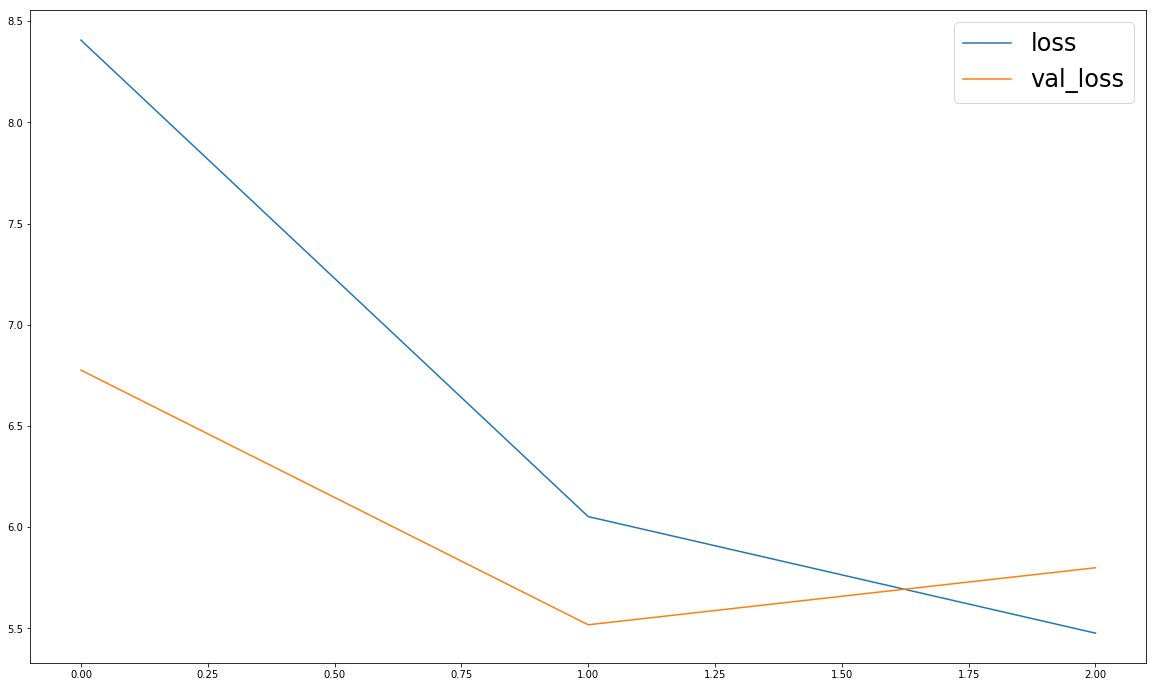

In [7]:
##########################################################################
# # # # # # # #            visualize the loss          # # # # # # # # # #
##########################################################################
plt.figure(figsize=(20,12))
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend(loc='upper right', prop={'size': 24});

In [ ]:
##################################################################################
# # # # # # # # # # #            SSD INFERENCING            # # # # # # # # # # # #
##################################################################################

# 1: Set the generator for the predictions.

predict_generator = val_dataset.generate(batch_size=1,
                                         shuffle=True,
                                         transformations=[convert_to_3_channels,
                                                          resize],
                                         label_encoder=None,
                                         returns={'processed_images',
                                                  'filenames',
                                                  'inverse_transform',
                                                  'original_images',
                                                  'original_labels'},
                                         keep_images_without_gt=False)

# 2: Generate samples.

batch_images, batch_filenames, batch_inverse_transforms, batch_original_images, batch_original_labels = next(predict_generator)

i = 0 # Which batch item to look at

print("Image:", batch_filenames[i])
print()
print("Ground truth boxes:\n")
print(np.array(batch_original_labels[i]))


# Predict.

y_pred = model.predict(batch_images)

confidence_threshold = 0.2

# Perform confidence thresholding.
y_pred_thresh = [y_pred[k][y_pred[k,:,1] > confidence_threshold] for k in range(y_pred.shape[0])]

# Convert the predictions for the original image.
y_pred_thresh_inv = apply_inverse_transforms(y_pred_thresh, batch_inverse_transforms)

np.set_printoptions(precision=2, suppress=True, linewidth=90)
print("Predicted boxes:\n")
print('   class   conf xmin   ymin   xmax   ymax')
print(y_pred_thresh_inv[i])

Image: /media/auv/Untitled/201009_PacStorm/d20100923_1/down_images/20100923.113613.03258.jpg

Ground truth boxes:

[[   1  525 1547  740 1656]]
Predicted boxes:

   class   conf xmin   ymin   xmax   ymax
[]


In [ ]:
##################################################################################
# # # # # # # # # # #            SSD EVALUATION            # # # # # # # # # # # #
##################################################################################

################ TENSOR BOARD STUFF ##############################

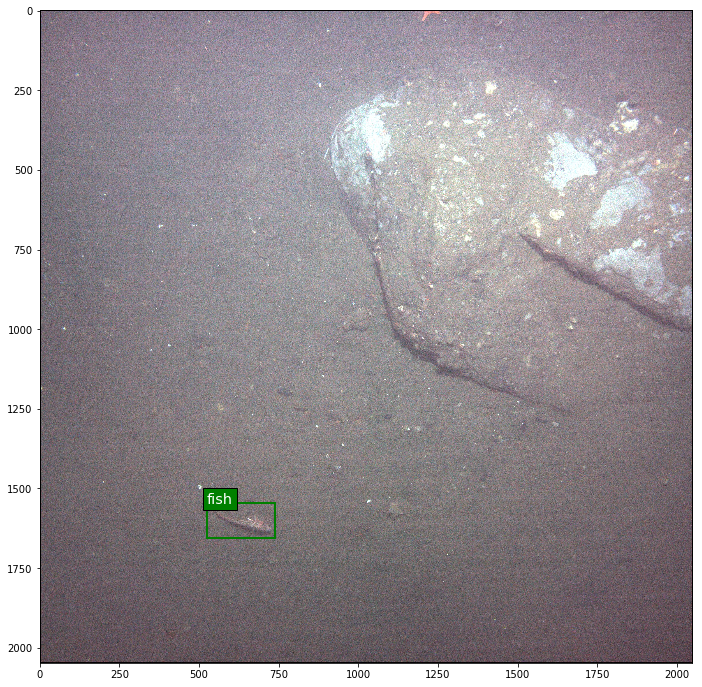

In [18]:
##################################################################################
# # # # # # # # # # #            SSD VISUALIZATION            # # # # # # # # # # # #
##################################################################################
# Display the image and draw the predicted boxes onto it.

# Set the colors for the bounding boxes
colors = plt.cm.hsv(np.linspace(0, 1, 21)).tolist()

plt.figure(figsize=(20,12))
plt.imshow(batch_original_images[i])

current_axis = plt.gca()

for box in batch_original_labels[i]:
    xmin = box[1]
    ymin = box[2]
    xmax = box[3]
    ymax = box[4]
    label = '{}'.format(classes[int(box[0])])
    current_axis.add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, color='green', fill=False, linewidth=2))  
    current_axis.text(xmin, ymin, label, size='x-large', color='white', bbox={'facecolor':'green', 'alpha':1.0})

for box in y_pred_thresh_inv[i]:
    xmin = box[2]
    ymin = box[3]
    xmax = box[4]
    ymax = box[5]
    color = colors[int(box[0])]
    label = '{}: {:.2f}'.format(classes[int(box[0])], box[1])
    current_axis.add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, color=color, fill=False, linewidth=2))  
    current_axis.text(xmin, ymin, label, size='x-large', color='white', bbox={'facecolor':color, 'alpha':1.0})